In [1]:
%load_ext autoreload
%autoreload 2

<span style="font-size:35px">**Contextual Analysis of Tennis Playing Styles**</span>


<span style="font-size:20px">**Introduction**</span>

This notebook presents a context-specific analysis of tennis playing styles, using **clustering** and a **sequential pattern mining** analysis. The main goal is to identify and analyze tactical playing styles in professional tennis using real shot-level data, with a focus on how these styles vary by match context.

Regarding the **clustering analysis** the key idea is to search for clusters of **players** that have a similar playing style, analyzing each player's behavior separately in distinct tactical contexts, defined by:
* **Surface**: clay, hard, grass
* **Point situation**: serve/return

For a total of six independent contexts, each with its own clustering.

For each player, in each context, a set of features is constructed through a dedicated feature creation process.

This type of analysis can have a role for:
* **Match preparation**: have an overview of the opponent playing style.
* **Style tracking**: track how a player’s tactical style changes across the contexts.

The goal of the **sequential pattern analysis** instead, is to identify frequent shot sequences in the opening phase of a point for a given player, along with information about their support, win percentage, and most frequent outcome, always computed individually for each of the six defined contexts. This helps the player understand how they perform in different contexts, and which strategies are effective or ineffective.


First, a preprocessing phase is performed on the point dataset obtained from https://github.com/JeffSackmann/tennis_MatchChartingProject. This dataset includes a large number of points recorded from 2020 to the end of 2024 from the ATP World Tour, ATP Challenger Tour and ITF tour, the top level tennis tournament categories, with each record containing the complete sequence of shots for a point, along with metadata such as tournament name, player names, and more. The list of points is ordered so that the points belonging to a specific match appear in the sequence they were played.

In [ ]:
import pandas as pd

df_men = pd.read_csv('points_datasets/charting-m-points-2020s-original.csv', low_memory=False)

df_men

In tennis, during each point, a player can be either the server or the returner. The server has two chances to land a valid serve, so the point can start with either a first or a second serve.
The fields **1st** and **2nd** represent the sequence of shots played following a successful first or second serve, respectively. If the first serve is in, the 2nd field will be NaN. If the first serve is out, the 1st field will still be recorded to indicate the attempted serve.<br>
The entire sequence of shots is codified with alphanumeric characters, each one represents a specific feature of the shot:
* **type**: forehand, backand, slice, dropshot, ...
* **direction**: down the line, in the middle, crosscourt
* **serve direction**: in the middle, out wide, ...
* **serve outcome**: ace, fault type
* **serve response depth**: deep, mid, short
* **point outcome**: winner, forced error, unforced error
* other particular events.

The file [get_mapping_dictionaries.py](get_mapping_dictionaries.py) contains a complete codification mapping of alphanumeric characters.<br><br>

<span style="font-size:20px">**Clustering Analysis**</span>

<span style="font-size:15px">**Surface field building**</span>

The original dataset does not contain information about the surface, so that a manual feature creation is performed.

In [ ]:
import pandas as pd

df_men = pd.read_csv('../points_datasets/charting-m-points-2020s-original.csv', low_memory=False)
tournaments = df_men["match_id"].str.extract(r'\w*-\w*-(.*?)-.*')[0].unique()


tournaments_and_surfaces={'United_Cup':"hard", 'NextGen_Finals':"hard", 'Yokkaichi_CH':"hard", 'Temuco_CH':"hard",
       'Maia_CH':"clay", 'Puerto_Vallarta_CH':"hard", 'Davis_Cup_Finals':"hard", 'Montemar_CH':"clay",
       'Roverto_CH':"hard", 'Yokohama_CH':"hard", 'Tour_Finals':"hard", 'Champaign_CH':"hard",
       'Helsinki_CH':"hard", 'Knoxville_CH':"hard", 'Paris_Masters':"hard", 'Brazzaville_CH':"clay",
       'Guayaquil_CH':"clay", 'Bratislava_2_CH':"clay", 'Charlottesville_CH':"hard",
       'Sydney_CH':"hard", 'Basel':"hard", 'Curitiba_CH':"clay", 'Brest_CH':"hard", 'Vienna':"hard",
       'Six_Kings_Slam':"hard", 'Antwerp':"hard", 'Stockholm':"hard", 'Campinas_CH':"clay",
       'Villa_Maria_CH':"clay", 'Shanghai_Masters':"hard", 'Tiburon_CH':"hard", 'Beijing':"hard",
       'Tokyo':"hard", 'Antofagasta_CH':"clay", 'Hangzhou':"hard", 'Saint_Tropez_CH':"hard",
       'Chengdu':"hard", 'Davis_Cup_World_Group':"hard", 'Dobrich_CH':"clay", 'US_Open':"hard",
       'Winston_Salem':"hard", 'Cincinnati_Masters':"hard", 'Canada_Masters':"hard",
       'Bogota_CH':"clay", 'Lincoln_CH':"hard", 'Lexington_CH':"hard", 'Olympics':"hard",
       'Luedenscheid':"clay", 'Washington':"hard", 'Paris_Olympics':"clay", 'Umag':"clay",
       'Chicago_CH':"hard", 'Atlanta':"hard", 'Hamburg':"grass", 'Gstaad':"clay", 'Newport':"grass",
       'Granby_CH':"hard", 'Bastad':"clay", 'Braunschweig_CH':"clay", 'Wimbledon':"grass",
       'Winnipeg_CH':"hard", 'ITF_Tokyo':"hard", 'Karlsruhe_CH':"clay", 'Bloomfield_Hills_CH':"hard",
       'Eastbourne':"grass", 'Queens_Club':"grass", 'Halle':"grass", 'Sassuolo_CH':"clay",
       's_Hertogenbosch':"grass", 'Stuttgart':"grass", 'Roland_Garros':"clay",
       'Roland_Garros_Juniors':"clay", 'Prostejov_CH':"clay", 'Vicenza_CH':"clay", 'Geneva':"clay",
       'Rome_Masters':"clay", 'Bordeaux_CH':"clay", 'Madrid_Masters':"clay", 'Cagliari_CH':"clay",
       'Guangzhou_CH':"hard", 'Madrid':"clay", 'Munich':"clay", 'Bucharest':"clay", 'Barcelona':"clay",
       'Acapulco_CH':"hard", 'Monte_Carlo_Masters':"clay", 'Estoril':"clay", 'Barcelona_CH':"clay",
       'Miami_Masters':"hard", 'San_Luis_Potosi_CH':"clay", 'Indian_Wells_Masters':"hard",
       'Sao_Leopoldo_CH':"hard", 'Asuncion_CH':"clay", 'Szekesfehervar_CH':"clay", 'Santiago':"clay",
       'Dubai':"hard", 'Acapulco':"hard", 'Rio_de_Janeiro':"clay", 'Los_Cabos':"hard", 'Doha':"hard",
       'Rotterdam':"hard", 'Delray_Beach':"hard", 'Buenos_Aires':"clay", 'Marseille':"hard",
       'Cordoba':"clay", 'Dallas':"hard", 'Montpellier':"hard", 'Davis_Cup_Qualifiers':"hard",
       'Cleveland_CH':"hard", 'Australian_Open':"hard", 'Australian_Open_Juniors':"hard",
       'Quimper_CH':"hard", 'Buenos_Aires_CH':"clay", 'Adelaide':"hard", 'Auckland':"hard",
       'Brisbane':"hard", 'Hong_Kong':"hard", 'Dutch_Championships':"clay", 'Ismaning_CH':"grass",
       'Astana':"hard", 'Kitzbuhel':"clay", 'Amersfoort_CH':"clay", 'Lyon':"clay", 'Rome':"clay",
       'Aix_En_Provence_CH':"clay", 'Rome_CH':"clay", 'Banja_Luka':"clay", 'Marrakech':"clay",
       'Houston':"clay", 'Manama_CH':"hard", 'Davis_Cup_WG2':"hard", 'Tigre_CH':"clay", 'Oeiras_CH':"clay",
       'Nonthaburi_CH':"hard", 'Pune':"hard", 'Valencia_CH':"clay", 'Roanne_CH':"hard", 'Bergamo_CH':"hard",
       'Vilnius_CH':"hard", 'Naples':"clay", 'Naples_CH':"clay", 'Ortisei_CH':"hard", 'Gijon':"hard",
       'Florence':"hard", 'Mouilleron_CH':"hard", 'Alicante_CH':"clay", 'Tel_Aviv':"hard", 'Sofia':"hard",
       'Seoul':"hard", 'Orleans_CH':"hard", 'Metz':"hard", 'Laver_Cup':"hard", 'San_Diego':"hard",
       'Rennes_CH':"hard", 'Tulln_CH':"clay", 'San_Benedetto_del_Tronto_CH':"clay",
       'Indianapolis_CH':"hard", 'Verona_CH':"clay", 'Rome_GA_CH':"clay", 'Wimbledon_Juniors':"grass",
       'Corrientes_CH':"clay", 'Shymkent_CH':"clay", 'Zagreb_CH':"clay", 'Belgrade':"hard",
       'Barletta_CH':"clay", 'Lugano_CH':"hard", 'Zadar_CH':"clay", 'ITF_Santo_Domingo':"clay",
       'Forli_CH':"clay", 'Sydney':"hard", 'Melbourne':"hard", 'ATP_Cup':"hard", 'French_Club':"clay",
       'Pau_CH':"hard", 'Bratislava_CH':"clay", 'Tenerife_CH':"hard", 'Eckental_CH':"grass",
       'St_Petersburg':"hard", 'Ercolano_CH':"clay", 'Villena_CH':"hard", 'Napoli_CH':"clay",
       'Santiago_CH':"clay", 'Murcia_CH':"clay", 'Davis_Cup_Group_I':"hard", 'Segovia_CH':"hard",
       'ITF_Champaign':"hard", 'Tokyo_Olympics':"hard", 'Poznan_CH':"clay", 'ITF_The_Hague':"clay",
       'ITF_Alkmaar':"clay", 'Almaty_CH':"hard", 'Lyon_CH':"clay", 'Little_Rock_CH':"hard",
       'Prague_CH':"clay", 'Orlando_CH':"hard", 'Split_CH':"clay", 'Lille_CH':"hard", 'Singapore':"hard",
       'Great_Ocean_Road_Open':"hard", 'Antalya':"clay", 'Lima_CH':"clay", 'Cologne':"hard",
       'Davis_Cup_WG_II':"hard", 'Columbus_CH':"hard", 'Koblenz_CH':"hard", 'New_York':"hard",
       'Punta_del_Este_CH':"clay", 'Bangkok_CH':"hard", 'Noumea_CH':"hard"}

# Directly map surface type using regular expression and dictionary
df_men['surface'] = df_men['match_id'].str.extract(r'\w*-\w*-(.*?)-.*')[0].map(tournaments_and_surfaces)

# Save the updated DataFrame with the 'surface' column to a new file
df_men.to_csv('charting-m-points-2020s.csv', index=False)

<span style="font-size:15px">**Extracting shot sequences from the original dataset**</span>

Both clustering and sequential pattern analysis are performed using the information provided by the shot codifications. In this preprocessing phase the usefeful information from the **1st** and **2nd** field of the original dataset are extracted, then the datasets used for clustering are created.<br>

First of all, we iterate throw all the players and the surfaces. Using the functions `get_service_points_df()` and `get_response_points_df()` in the file [get_df_by_player.py](get_df_by_player.py), the dataset filtered by the current player and surface is calculated. Then using `get_shots_in_1st_serve_points()` and `get_shots_in_2nd_serve_points()` in the file [get_shots.py](get_shots.py), a new dataframe is built, containing three fields:

* `point`: a list of codes each one represents a shot in the point
* `won_by_player`: True if won, False otherwise
* `outcome`: outcome type (winner, forced error, unforced error).

Since the dataset still includes both the player's and the opponent's shots, a new transformation is applied using dedicated functions `get_shots_by_server` and `get_shots_by_receiver`, from the file [get_shots_wo_opponent_shots.py](get_shots_wo_opponent_shots.py), in order to obtain only the player's shots.

A dictionary `player_contexts_data` contains the player shots for the specific context, where the context is the couple *surface={clay, hard, grass}* and *type of point={on serve, on response}*.

<span style="font-size:15px">**Feature building**</span>

Now a new dataset for clustering purpose can be built. In particular 2 type of features are built: 
* **Generic features**: (`build_generic_features()`, file [feature_building.py](feature_building.py))
    * `average_point_length`: reflects the player tendency either to conclude fast the point, or to be more conservative.
    * `net_points_rate`: an high rate reflects a familiarity with the net approach, that usually corresponds to an offensive playing style.
    * `net_points_won_rate`: an high rate reflects good skills with volleys.
    * `winners_rate`: an high rate corresponds to an offensive playing style.
    * `unforced_errors_rate`: an high rate corresponds to an offensive playing style.
    * `slices_rate`: an high rate reflects variety in player style. 
    * `dropshots_rate`: an high rate reflects a eclectic style.
    * `crosscourt_rate`: useful info.
    * `middlecourt_rate`: useful info.
    * `down_the_line_rate`: useful info.
    * `ace_rate`: computed only for "on serve" context. An high rate corresponds to a "big server" style.
    * `average_response_depth`: computed only for "on response" context. The deeper the response is, the better is the player on response.
<br>
<br>
    
    
* **Opening phase features**: (`build_opening_phase_features()`, file [feature_building.py](feature_building.py)) This group of features captures the player’s behavior during the first three shots of a point. This is an important indicator of playing style, as the opening phase has the greatest influence on how the point unfolds. Each of these features is computed for all three shots, resulting in a total of nine features.
    * `forehand_ground_rate`
    * `backhand_ground_rate`
    * `slice_shot_rate`
<br>
<br>
    Serve direction features are constructed only for points where the serve is the first shot.
    * `wide_serve_rate`
    * `body_serve_rate`
    * `down_the_T_serve_rate`
    
<span style="font-size:15px">**Final datasets building**</span>

Once the features for each context are extracted, the final datasets are created. There will be six final datasets for clustering, corresponding to all possible combinations of *surface={clay, hard, grass}* and *type of point={on serve, on response}*, where each tuple identifies a player. (`build_final_dataset`, in file [feature_building.py](feature_building.py)).






In [ ]:
import pandas as pd

from costants import PLAYERS, MIN_PLAYERS, PLAYER_SURFACES_DICT, MIN_NUM_OF_POINTS
from feature_building import build_final_dataset, build_generic_features, \
    build_opening_phase_features
from utils import *
from get_df_by_player import get_service_points_df, get_response_points_df
from get_shots import get_shots_in_2nd_serve_points, get_shots_in_1st_serve_points
from get_shots_wo_opponent_shots import get_shots_by_receiver, get_shots_by_server
from collections import Counter, defaultdict
import re
import os


all_features_by_context = defaultdict(list)  # Dictionary to accumulate features for basic context

for player in PLAYERS:
    player_contexts_data = {}  # Temporary dictionary for current player data

    for surface in PLAYER_SURFACES_DICT.get(player, []):
        # extracting the dataframe with the points where player is serving
        player_on_service = get_service_points_df(player, df_men, surface)

        # extracting the dataframe with the points where player is serving
        player_on_response = get_response_points_df(player, df_men, surface)

        # extracting the points in which the player is serving
        shots_1st_service = get_shots_by_server(get_shots_in_1st_serve_points(player_on_service))
        shots_2nd_service = get_shots_by_server(get_shots_in_2nd_serve_points(player_on_service))

        # extracting the points where the player is in response
        shots_1st_response = get_shots_by_receiver(get_shots_in_1st_serve_points(player_on_response))
        shots_2nd_response = get_shots_by_receiver(get_shots_in_2nd_serve_points(player_on_response))

        player_contexts_data.update({f"{player} on serve, on {surface}": (pd.concat([shots_1st_service.copy(),
                                                                                     shots_2nd_service.copy()]),
                                                                          pd.concat([shots_1st_service.copy(),
                                                                                     shots_2nd_service.copy()])),
                                     f"{player} on response, on {surface}": (
                                         pd.concat([shots_1st_response.copy(), shots_2nd_response.copy()]),
                                         pd.concat([shots_1st_response.copy(), shots_2nd_response.copy()]))})
        
        # iterate for each context, that is, each type of point (serve or response) and for each shot (1st or 2nd)
        for context, (shots, shots_to_filter) in player_contexts_data.items():
            if len(shots) < MIN_NUM_OF_POINTS:
                continue

            # filter shots by >= SHOT_LENGTH and cut to the first SHOT_LENGTH
            filtered_shots = filter_and_trim_shots(shots_to_filter)
            if len(filtered_shots) < MIN_NUM_OF_POINTS:
                continue

            # builds generic features using all points
            generic_features = build_generic_features(player, context, shots)

            # builds opening features using filtered points
            opening_phase_features = build_opening_phase_features(context, filtered_shots)

            # Check for duplicate keys
            common_keys = set(generic_features.keys()) & set(opening_phase_features.keys())
            if common_keys:
                print(
                    f"Warning: duplicates keys found. {context}: {common_keys}")

            # Combine features into a single dictionary
            combined_features = {**generic_features, **opening_phase_features, 'player': player}

            # Extract the base context (without the player name) to use as a key
            # Group data from different players for the same context type
            try:
                # Find the first occurrence of the player's name followed by a space and get the rest
                base_context = context.split(f"{player} ", 1)[1]
                print(f"Context for {player}: {base_context}")
            except IndexError:
                # Fallback in the unlikely case that the context format is different
                print(f"Warning: non standard format'{context}'")
                base_context = context

            # Add the combined features to the list for the corresponding base context
            all_features_by_context[base_context].append(combined_features.copy())
            
# Build all the final datasets 
final_datasets = build_final_dataset(all_features_by_context)

# Create a directory to save the CSV files, if it doesn't exist
output_dir = "feature_datasets_csv_reduced_contexts"
os.makedirs(output_dir, exist_ok=True)

# Iterate over each element of the dictionary and save the DataFrames to a CSV file
for name, df in final_datasets.items():
    # Replace any invalid characters in the file name
    safe_name = re.sub(r'[^\w\-_\. ]', '_', name)
    file_path = os.path.join(output_dir, f"{safe_name}.csv")

    # Save the DataFrame in CSV format
    df.to_csv(file_path, index=True)
    print(f"Saved: {file_path}")

For example, the dataset "hard, on serve", looks like this:

In [ ]:
import pandas as pd

on_serve_on_hard = pd.read_csv('feature_datasets_csv_reduced_contexts/on serve_ on hard.csv', low_memory=False)
on_serve_on_hard

<span style="font-size:15px">**Preprocessing phase**</span>

**Correlation analysis**: An analysis of the constructed features is now performed. All features are numerical, mostly rates and averages, so a correlation matrix through the Pearson's coefficient is computed to identify potential relationships between them.

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

features_dataset_dir = 'feature_datasets_csv_reduced_contexts/'

# Iterate over all files in the specified folder
for dataset_name in os.listdir(features_dataset_dir):
    print(dataset_name)
    # Check if the file is a CSV
    if dataset_name.endswith('.csv'):
        # Build the full path to the file
        file_path = os.path.join(features_dataset_dir, dataset_name)
        # Load the dataset
        df = pd.read_csv(file_path, low_memory=False)
        feature_cols = [col for col in df.columns if col not in ["player"]]
        corr_matrix = df[feature_cols].corr()

    # Iterate over rows and columns of the correlation matrix
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix.columns)):
            corr = corr_matrix.iloc[i, j]
            if (corr > 0.6 or corr < -0.6) and i!=j:
                print(f"{dataset_name} riga: {corr_matrix.index[i]}, colonna: {corr_matrix.columns[j]}")

    # View the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Matrice di Correlazione per {dataset_name}')
    plt.show()

The analysis reveals that some features are highly correlated.
First of all, the **forehand_rate** and **backhand_rate** are strongly negatively correlated in both opening shot contexts. This is quite expected, as the forehand is naturally the opposite of the backhand.
To address this, three new features are created: `opening_1st_ground_fh_bh_ratio`, `opening_2nd_ground_fh_bh_ratio`, and `opening_3rd_ground_fh_bh_ratio`, which aggregate the information into a single value.<br><br>
Secondly, the **slice_rate in the opening phase** is highly positively correlated with the overall **slice_rate**.
This is quite expected, as they essentially represent the same information.
Unlike the case of forehand and backhand rates, the decision here is to keep the general feature and discard the one specific to the opening phase.
In fact, data analysis shows that the slice is used less frequently in the opening phase, resulting in very low percentages.
Instead, the overall **slice_rate** is more informative, as it strongly characterizes the player's playing style.

**Feature normalization**: all the feature are normalized using z-score normalization. This ensure all the features to have mean equal to 0 and standard deviation equal to 1. 

In [ ]:
import os
import pandas as pd
import numpy as np

features_dataset_dir = '../feature_datasets_csv_reduced_contexts/'
features_dataset_dir_reduced_features = '../feature_datasets_csv_reduced&scaled_features/'

# Iterate through all files in directory
for dataset_name in os.listdir(features_dataset_dir):
    if dataset_name.endswith('.csv'):
        file_path = os.path.join(features_dataset_dir, dataset_name)
        df = pd.read_csv(file_path)
        dest_file_path = os.path.join(features_dataset_dir_reduced_features, dataset_name)

        # Calculate forehand/backhand ratios for all three shots
        df['opening_2nd_ground_fh_bh_ratio'] = df['opening_2nd_forehand_ground'] / df['opening_2nd_backhand_ground']
        df['opening_3rd_ground_fh_bh_ratio'] = df['opening_3rd_forehand_ground'] / df['opening_3rd_backhand_ground']

        # Drop original columns
        columns_to_drop = ['opening_2nd_forehand_ground', 'opening_2nd_backhand_ground',
                           'opening_3rd_forehand_ground', 'opening_3rd_backhand_ground', 'opening_2nd_slice_shot','opening_3rd_slice_shot']

        if 'on response' in dataset_name:
            df['opening_1st_ground_fh_bh_ratio'] = df['opening_1st_forehand_ground'] / df['opening_1st_backhand_ground']
            columns_to_drop.append('opening_1st_forehand_ground')
            columns_to_drop.append('opening_1st_backhand_ground')
            columns_to_drop.append('opening_1st_slice_shot')

        df = df.drop(columns=columns_to_drop)

        # Normalize the features values with z-score normalization
        feature_cols = [col for col in df.columns if col not in ["player"]]
        X = df[feature_cols].values
        X_scaled = StandardScaler().fit_transform(X)
        
        # Create a new normalized DataFrame
        df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

        # add the "player" column again
        df_scaled["player"] = df["player"].values

        # Save modified dataset
        df_scaled.to_csv(dest_file_path, index=False)

Now the clustering analysis can start. First of all, the datasets are uploaded.

In [2]:
import os
import pandas as pd

dfs = []
features_dataset_dir = 'feature_datasets_csv_reduced&scaled_features/'

for dataset_name in os.listdir(features_dataset_dir):
    if dataset_name.endswith('.csv'):
        file_path = os.path.join(features_dataset_dir, dataset_name)
        dfs.append((dataset_name, pd.read_csv(file_path, low_memory=False)))

In order to understand if the datasets has a non-uniform distribution of points, so that a clustering analysis can be performed, the hopkins statistic is computed throw the function `hopkins()` in the file [run_clustering.py](run_clustering.py). A 0.75 Hopkins statistic indicates clustering tendency with a 90% confidence level. The results show a Hopkins value between 0.7 and 0.8 across all datasets, averaged over 30 iterations.

In [ ]:
from sklearn.preprocessing import StandardScaler
from run_clustering import hopkins

for name, dataframe in dfs:
    feature_cols = [col for col in dataframe.columns if col not in ["player"]]
    print(name)
    mean, std_dev, values = hopkins(dataframe[feature_cols].values)
    print(f"Hopkins statistic (df): {mean:.3f} ± {std_dev:.3f}\n")

The clustering approach aims to identify **four** distinct groups that effectively capture the stylistic differences in tennis, as suggested in the article from Harvard Sports Analysis [Sorting Strokes: Classifying Tennis Players Based on Stats and Style](https://harvardsportsanalysis.org/2021/07/sorting-strokes-classifying-tennis-players-based-on-stats-and-style). To achieve this, different algorithms that require the number of clusters as a parameter are tested.<br>

Clustering performed on the raw data without applying any dimensionality reduction exhibits suboptimal results. Although the Hopkins statistic indicates a significant clustering tendency, the high dimensionality of the datasets—14 features for the response datasets and 16 features for the serve datasets—triggers the curse of dimensionality, adversely impacting clustering performance.
The execution of **kmeans**, within the function `run_kmeans_clustering()` in the file [run_clustering.py](run_clustering.py), shows bad performances on silhouette score and DBI score.
The Davies–Bouldin Index (DBI) is a metric used to evaluate the quality of clustering by assessing both intra-cluster compactness and inter-cluster separation. It does so by computing, for each cluster, a similarity measure that compares its dispersion with the distance to the nearest neighboring cluster. The final DBI score is obtained by averaging these similarity measures across all clusters. A lower DBI value indicates better clustering performance, meaning that the clusters are both compact and well-separated. Conversely, higher values suggest overlapping or loosely defined clusters. In practice, values below 1 correspond to well-defined clusters.

on response_ on clay.csv
Silhouette score (KMeans): 0.139
DBI score (KMeans): 1.892


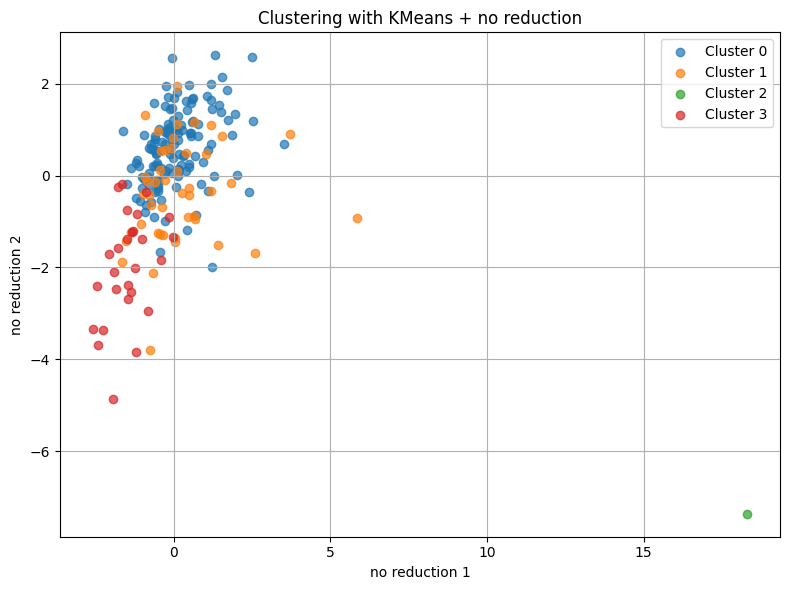

on response_ on grass.csv
Silhouette score (KMeans): 0.090
DBI score (KMeans): 2.213


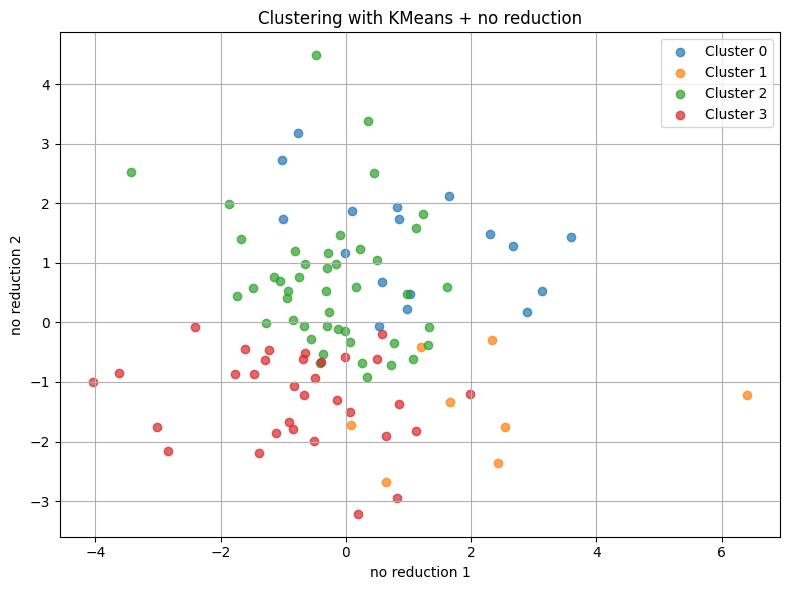

on response_ on hard.csv
Silhouette score (KMeans): 0.097
DBI score (KMeans): 1.909


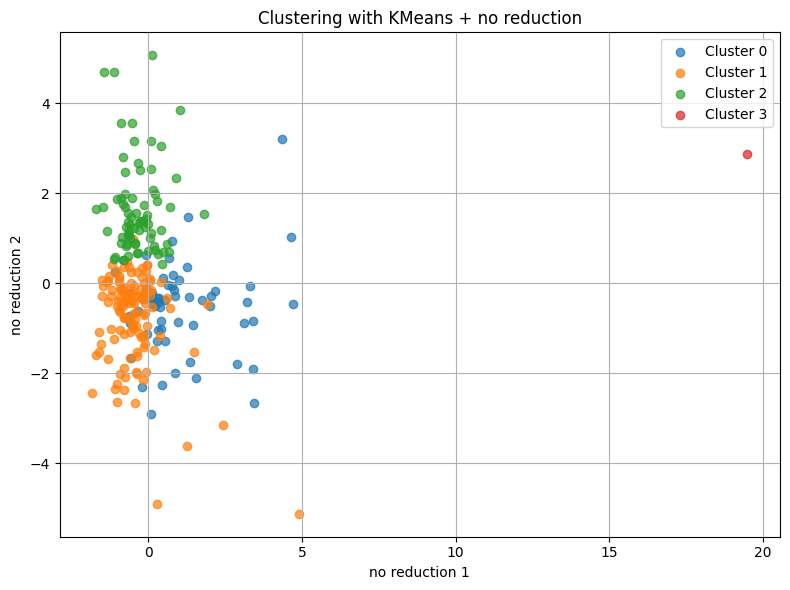

on serve_ on clay.csv
Silhouette score (KMeans): 0.097
DBI score (KMeans): 2.028


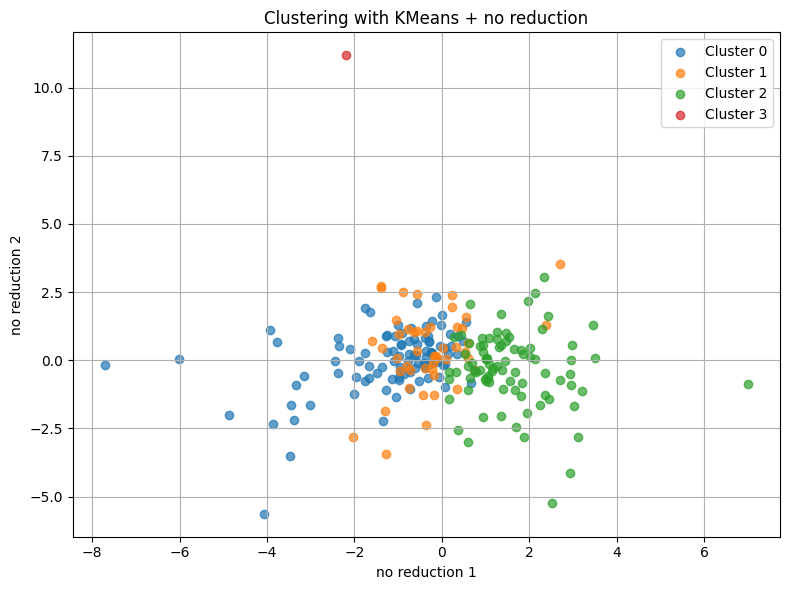

on serve_ on grass.csv
Silhouette score (KMeans): 0.086
DBI score (KMeans): 2.155


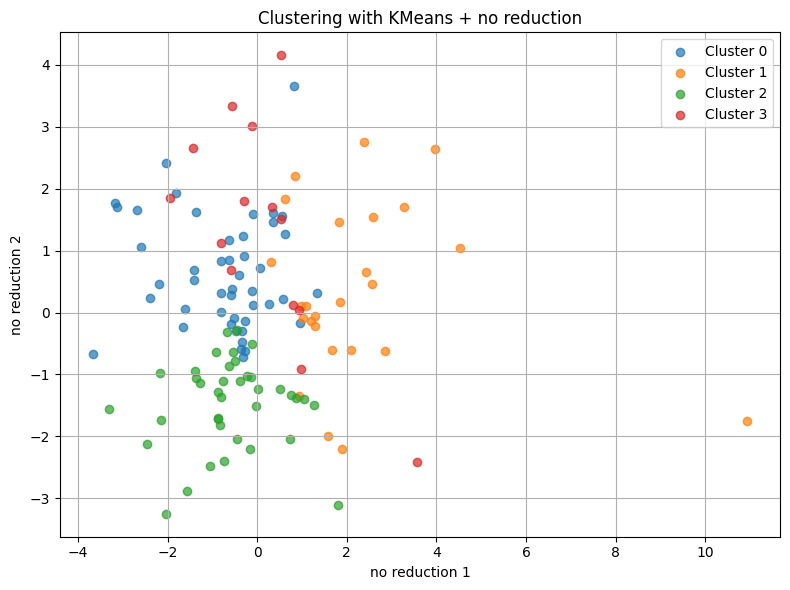

on serve_ on hard.csv
Silhouette score (KMeans): 0.083
DBI score (KMeans): 2.147


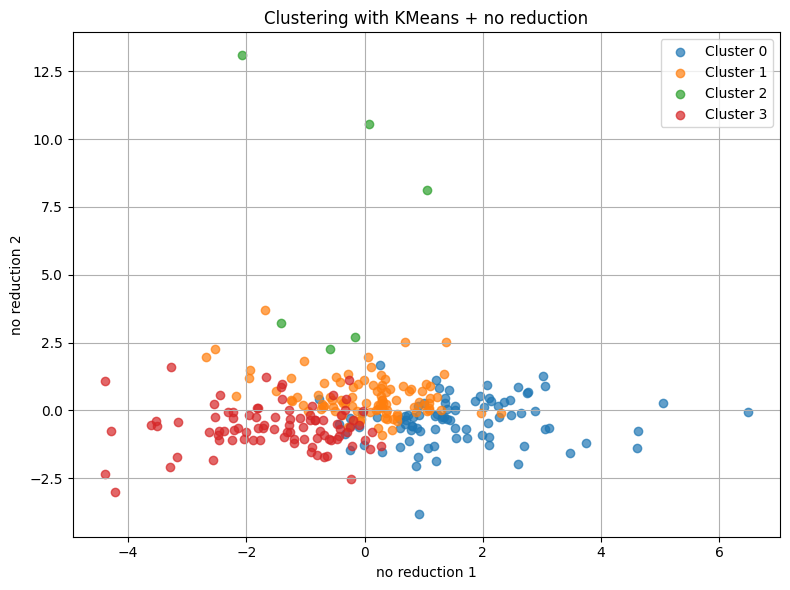

In [4]:
from run_clustering import *

dfs_clustered_kmeans = []

for name, dataframe in dfs:
    print(name)
    df_clustered = run_kmeans_clustering(dataframe)
    dfs_clustered_kmeans.append((name, df_clustered))

To improve performance, PCA is applied to reduce dimensionality while retaining 80% of the variance in the dataset. Additionally, K-Means is improved by randomizing the initial centroid selection 50 times and retaining only the best result, in terms of silouhette score and DBI score.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

dfs_pca=[]
for name, dataframe in dfs:
    feature_cols = [col for col in dataframe.columns if col not in ["player"]]
    values = dataframe[feature_cols].values
    
    # Keep enough features to explain 80% of the variance
    pca = PCA(n_components=0.8)  
    X_pca = pca.fit_transform(values)

    # Create column names: PCA_1, PCA_2, ..., PCA_n
    pca_col_names = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
    
    # Create a new DataFrame
    dfs_pca.append((name, pd.DataFrame(X_pca, columns=pca_col_names, index=dataframe.index)))

on response_ on clay.csv
Best seed: 11
Silhouette score (best): 0.183
DBI score (best): 1.794


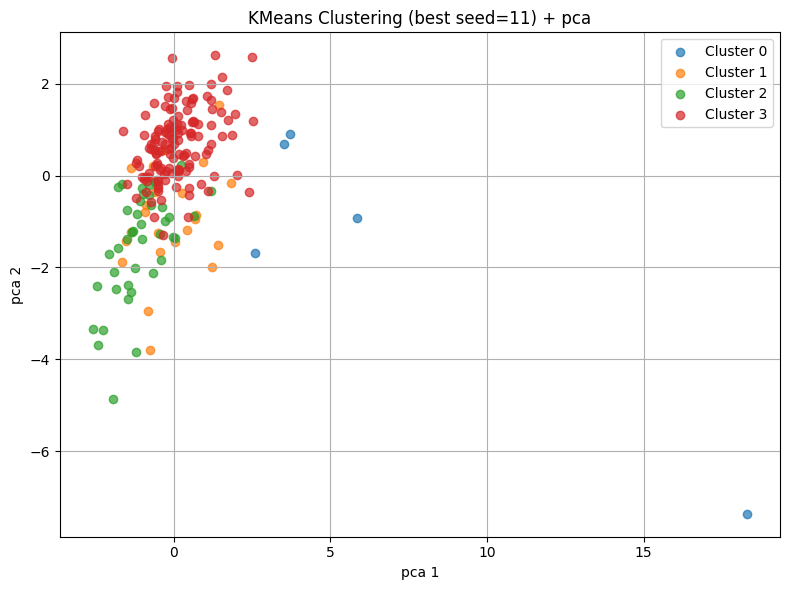

on response_ on grass.csv
Best seed: 6
Silhouette score (best): 0.147
DBI score (best): 1.881


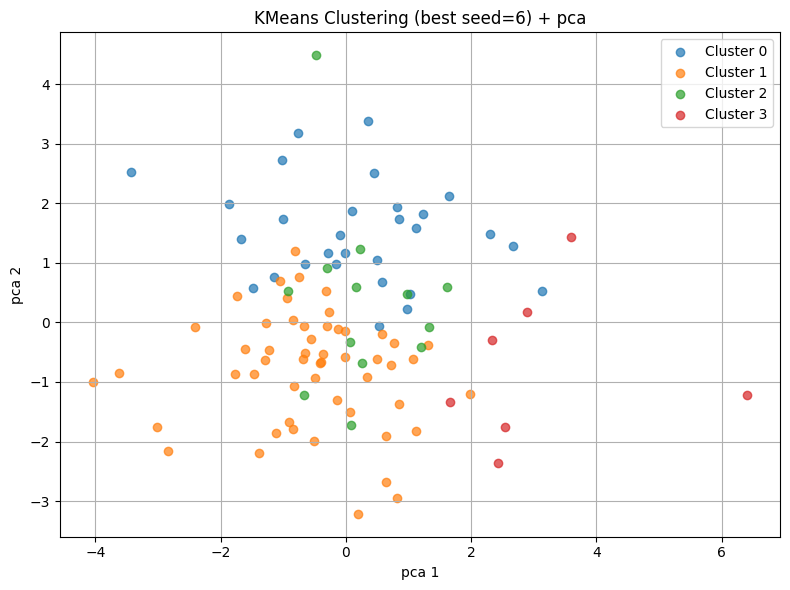

on response_ on hard.csv
Best seed: 28
Silhouette score (best): 0.143
DBI score (best): 1.733


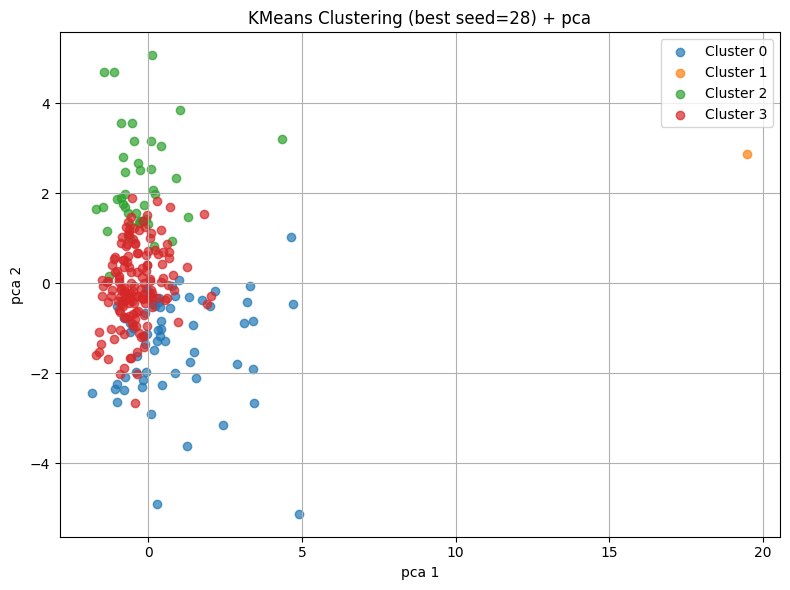

on serve_ on clay.csv
Best seed: 41
Silhouette score (best): 0.207
DBI score (best): 1.720


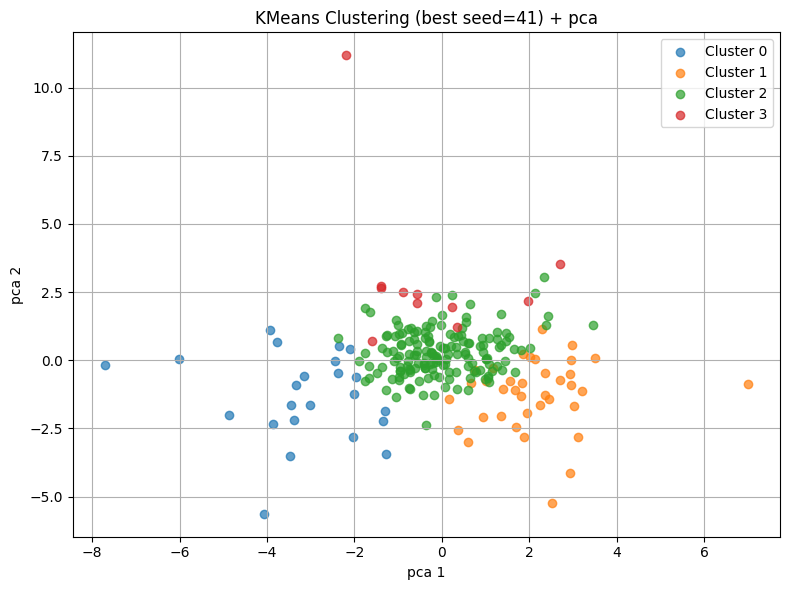

on serve_ on grass.csv
Best seed: 28
Silhouette score (best): 0.142
DBI score (best): 1.592


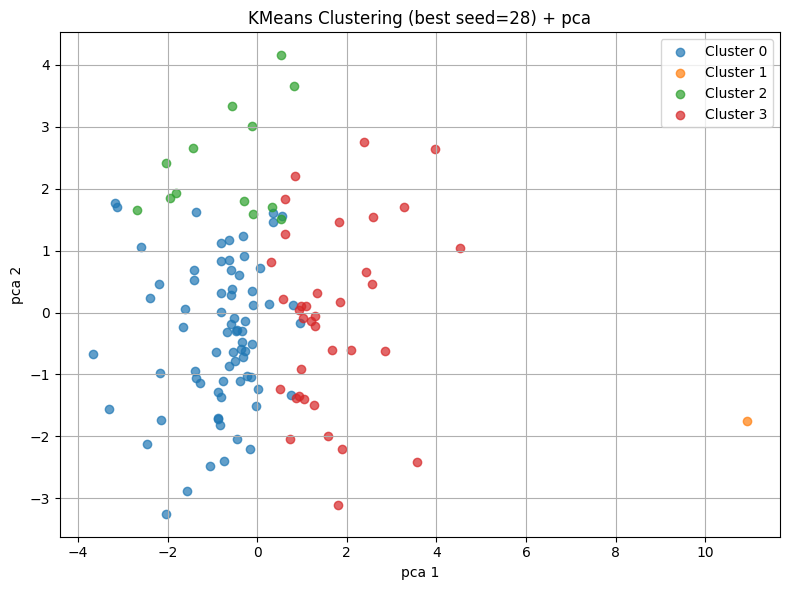

on serve_ on hard.csv
Best seed: 1
Silhouette score (best): 0.146
DBI score (best): 1.351


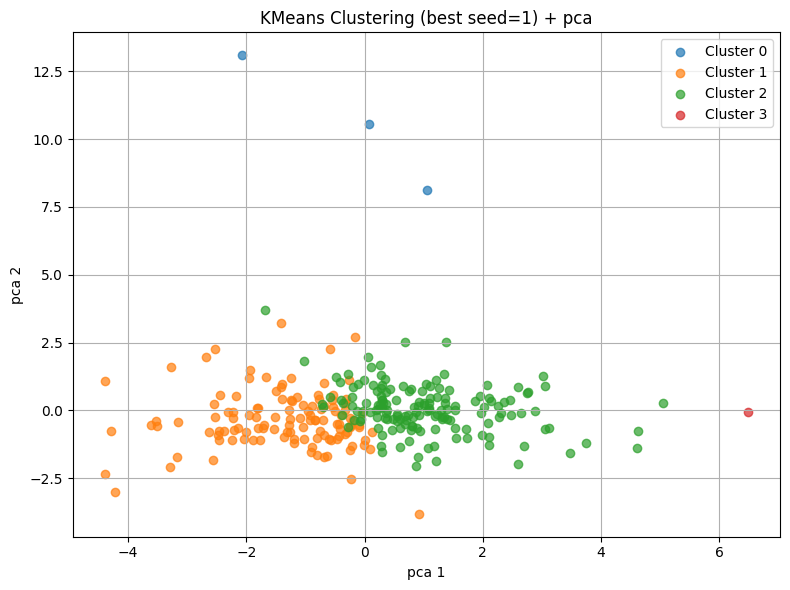

In [6]:
from run_clustering import run_kmeans_clustering, run_kmeans_clustering_multiple

dfs_clustered_pca_kmeans = []

for name, dataframe in dfs_pca:
    print(name)
    df_clustered = run_kmeans_clustering_multiple(dataframe, dimensionality_reduction="pca")
    dfs_clustered_pca_kmeans.append((name, df_clustered))

Even with PCA retaining 80% of the variance, the performance remains poor. Only when reducing the variance threshold to 40% does a slight improvement appear (still with a low silhouette coefficient around 0.25), but this comes at the cost of losing significant feature variance.<br>

A solution come from another feature reduction techique, [UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction)](https://umap-learn.readthedocs.io/en/latest/). From UMAP website: "UMAP is a fairly flexible non-linear dimension reduction algorithm. It seeks to learn the manifold structure of your data and find a low dimensional embedding that preserves the essential topological structure of that manifold.". In practice, UMAP is a nonlinear dimensionality reduction technique. It works in three main steps:

* Graph Construction: UMAP builds a weighted graph where data points are connected based on their local neighborhood (using nearest neighbors). The distance between points is modeled as a probability distribution that captures local structure.

* Graph Optimization: It then optimizes a low-dimensional representation (e.g., 2D or 3D) by preserving the structure of the original high-dimensional graph. This is done by minimizing the difference (cross-entropy) between the high-dimensional and low-dimensional graphs.

* Embedding Output: The result is a projection of the data that preserves both local and some global relationships, making it suitable for clustering tasks.

In order to evaluate how well UMAP transforms the original dataset, a metric called **trustworthiness** can be computed. Trustworthiness measures whether points that are close in the UMAP space were also close in the original space. The metric ranges from 0 to 1, where 1 indicates perfect trustworthiness, and values below 1 suggest that some distortion has been introduced.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import trustworthiness
import umap

dfs_umap_2d = []

dfs_umap_8d = []

umap_components = (2, 8)
for name, dataframe in dfs:
    feature_cols = [col for col in dataframe.columns if col not in ["player"]]
    values = dataframe[feature_cols].values
    for umap_comp in umap_components:
        # UMAP reduction with default neighbors parameter set to 15
        reducer = umap.UMAP(n_components=umap_comp, random_state = 42, n_jobs=1)
        X_umap = reducer.fit_transform(values)
        
        # Create column names: UMAP_1, UMAP_2, ..., UMAP_n
        umap_col_names = [f'UMAP_{i+1}' for i in range(X_umap.shape[1])]

        if umap_comp == 2:
            # Create a new DataFrame and include 'player' column
            df_umap = pd.DataFrame(X_umap, columns=umap_col_names, index=dataframe.index)
            df_umap['player'] = dataframe['player']
            dfs_umap_2d.append((name, df_umap))
        else:
            # Create a new DataFrame and include 'player' column
            df_umap = pd.DataFrame(X_umap, columns=umap_col_names, index=dataframe.index)
            df_umap['player'] = dataframe['player']
            dfs_umap_8d.append((name, df_umap))
    
        # trustworthiness calculation
        trust = trustworthiness(values, X_umap, n_neighbors=15)
        print(f"Trustworthiness UMAP {umap_comp}D: {trust:.3f}")

Trustworthiness UMAP 2D: 0.796
Trustworthiness UMAP 8D: 0.840
Trustworthiness UMAP 2D: 0.765
Trustworthiness UMAP 8D: 0.827
Trustworthiness UMAP 2D: 0.788
Trustworthiness UMAP 8D: 0.834
Trustworthiness UMAP 2D: 0.786
Trustworthiness UMAP 8D: 0.836
Trustworthiness UMAP 2D: 0.785
Trustworthiness UMAP 8D: 0.840
Trustworthiness UMAP 2D: 0.789
Trustworthiness UMAP 8D: 0.849


The results show a good feature transformation, with a low level of distortion in both 2 and 8 dimensions. Now, kmeans performances increase significantly, with a silhouette coefficient around 0.4 and a DBI score around 0.8.

KMeans clustering:

on response_ on clay.csv
umap dimensions: 2
Best seed: 10
Silhouette score (best): 0.402
DBI score (best): 0.815


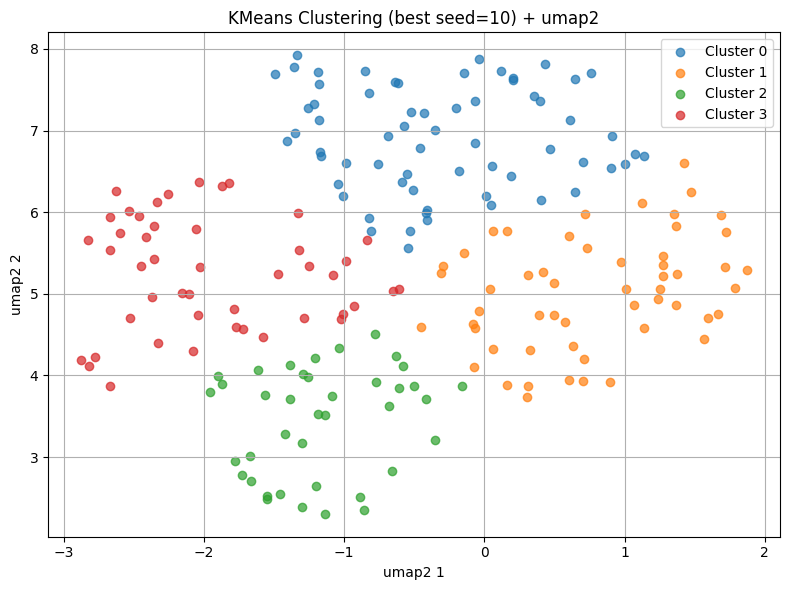

on response_ on grass.csv
umap dimensions: 2
Best seed: 18
Silhouette score (best): 0.366
DBI score (best): 0.822


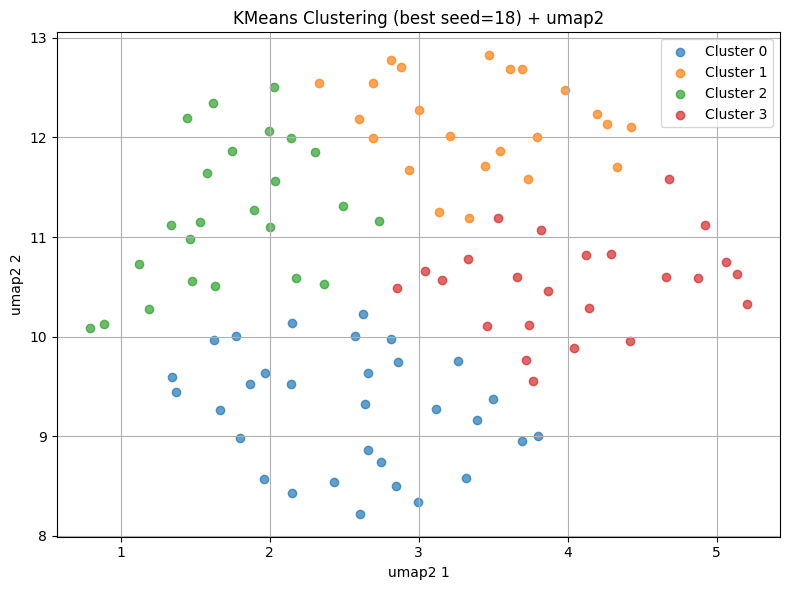

on response_ on hard.csv
umap dimensions: 2
Best seed: 32
Silhouette score (best): 0.425
DBI score (best): 0.750


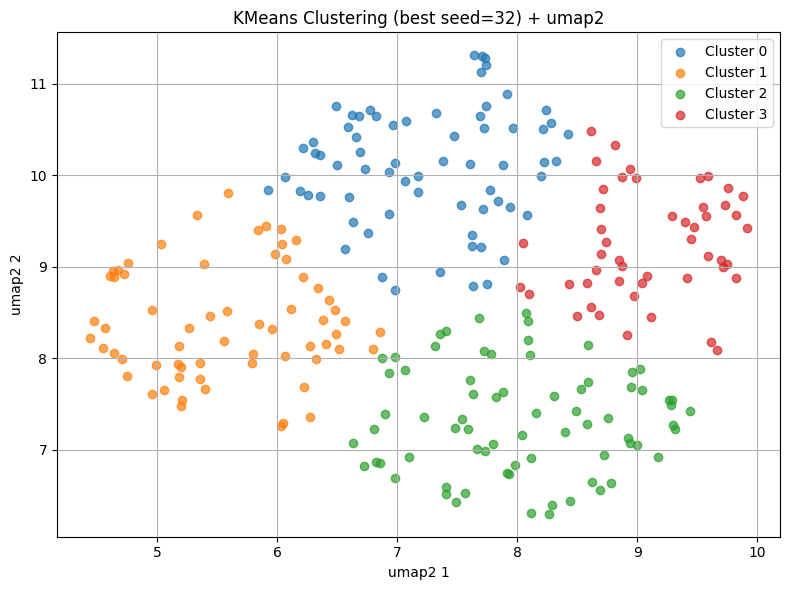

on serve_ on clay.csv
umap dimensions: 2
Best seed: 2
Silhouette score (best): 0.412
DBI score (best): 0.788


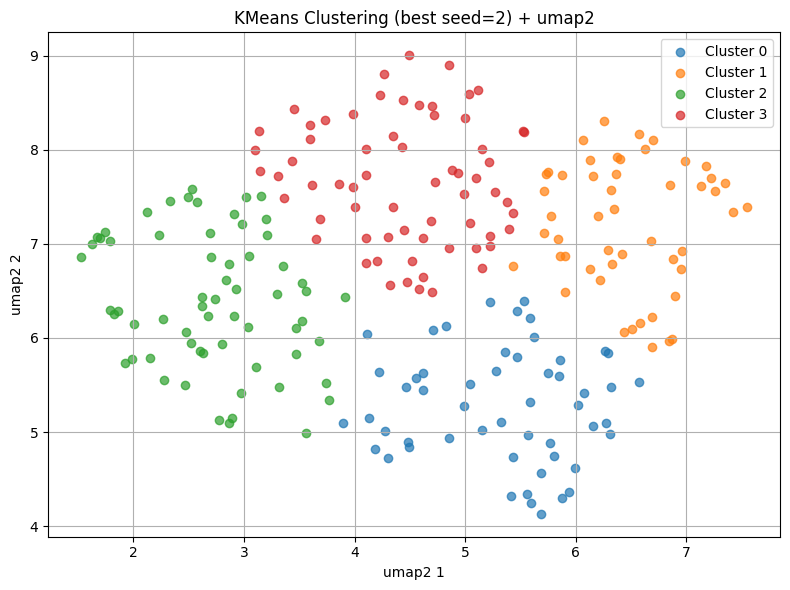

on serve_ on grass.csv
umap dimensions: 2
Best seed: 28
Silhouette score (best): 0.389
DBI score (best): 0.841


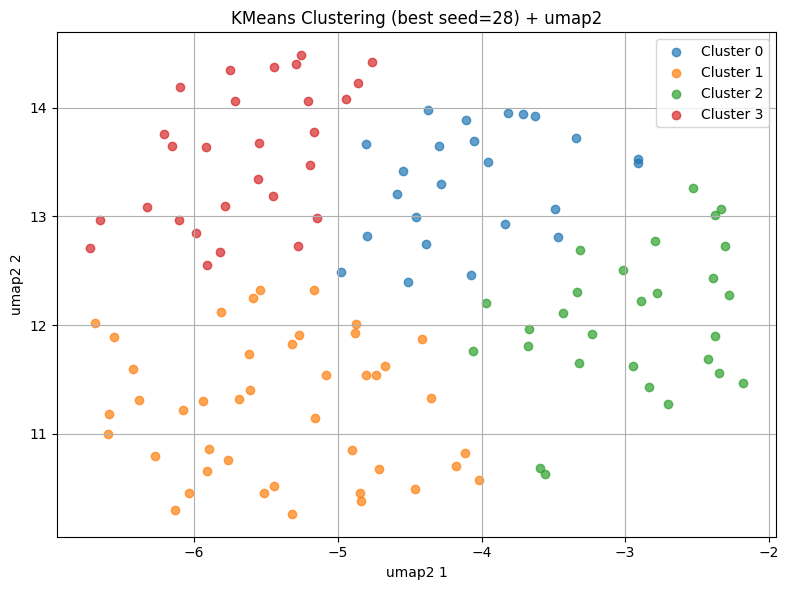

on serve_ on hard.csv
umap dimensions: 2
Best seed: 35
Silhouette score (best): 0.387
DBI score (best): 0.817


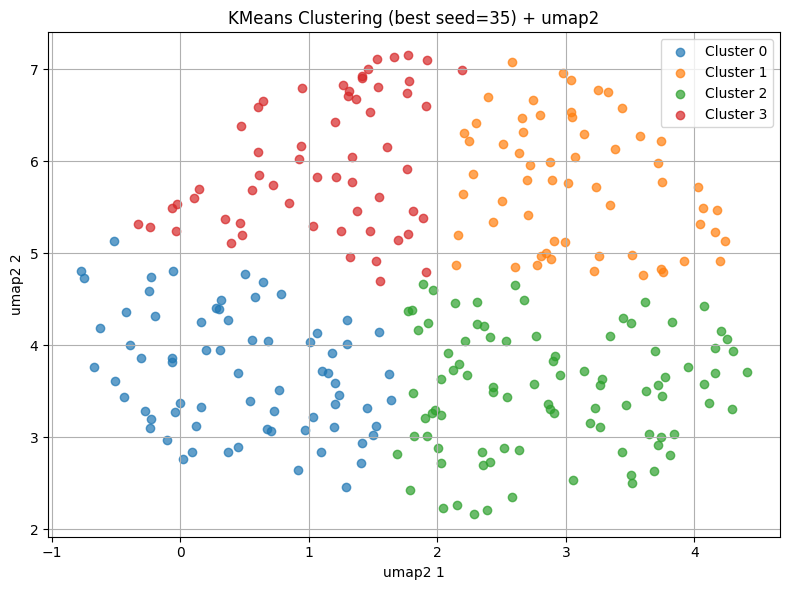

on response_ on clay.csv
umap dimensions: 8
Best seed: 24
Silhouette score (best): 0.267
DBI score (best): 1.339


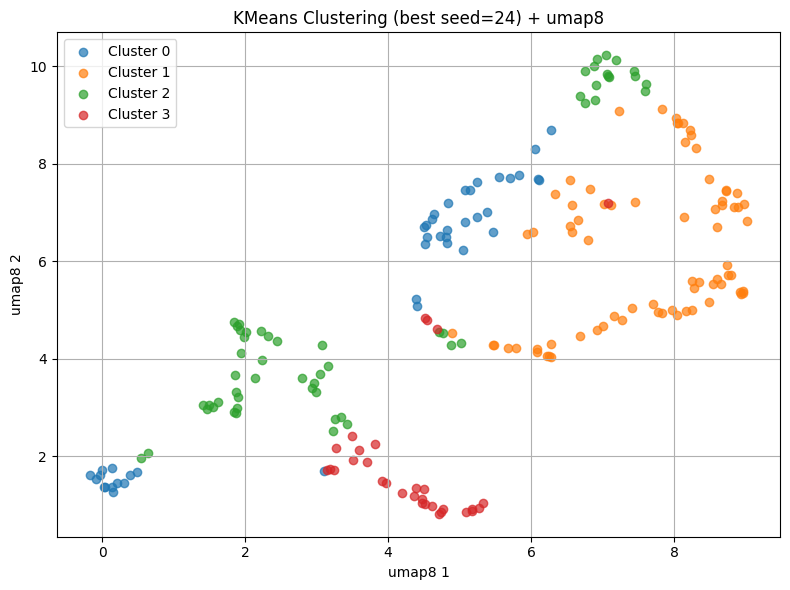

on response_ on grass.csv
umap dimensions: 8
Best seed: 38
Silhouette score (best): 0.270
DBI score (best): 1.121


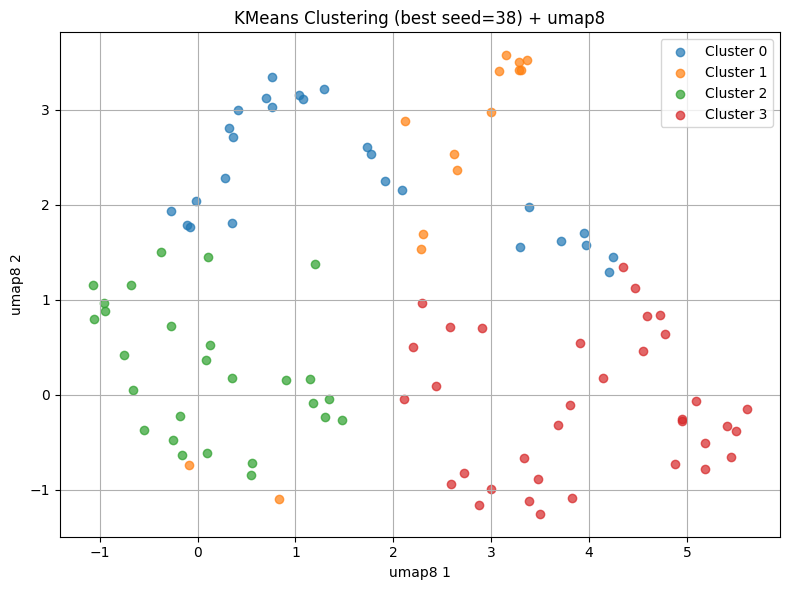

on response_ on hard.csv
umap dimensions: 8
Best seed: 20
Silhouette score (best): 0.323
DBI score (best): 1.125


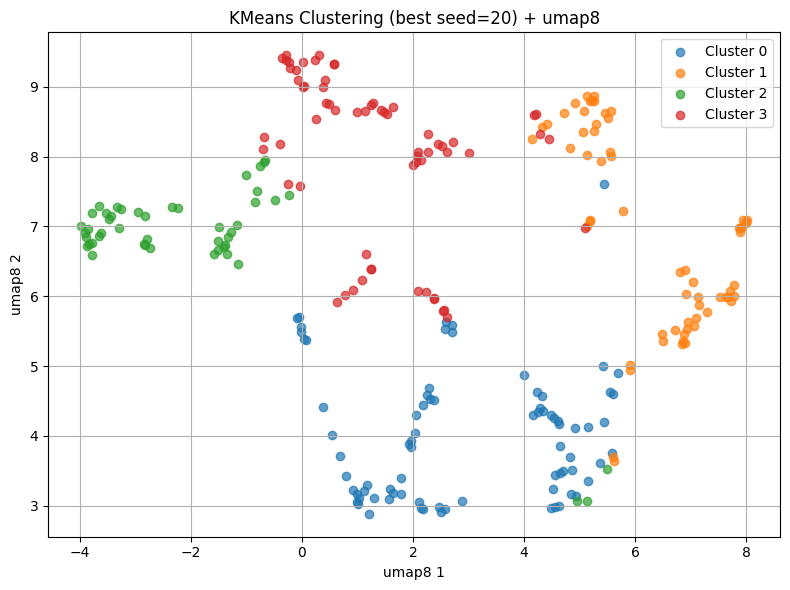

on serve_ on clay.csv
umap dimensions: 8
Best seed: 16
Silhouette score (best): 0.310
DBI score (best): 1.177


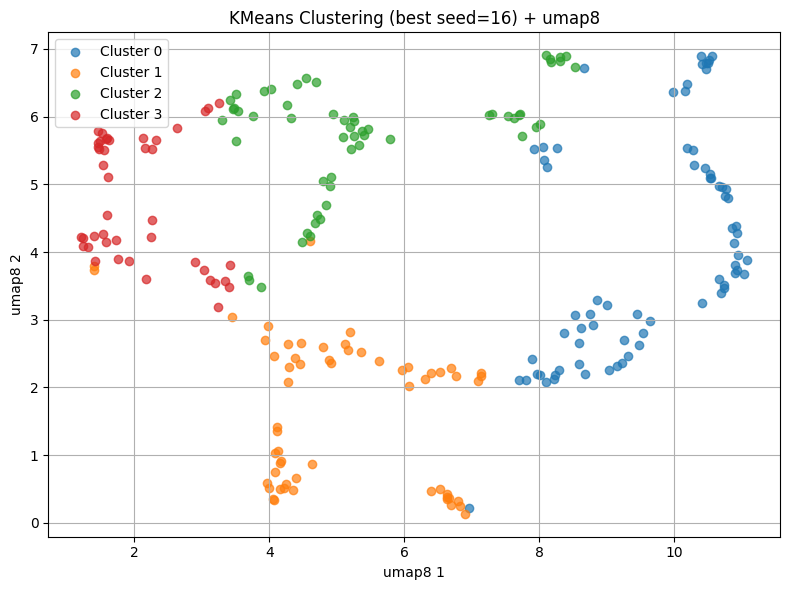

on serve_ on grass.csv
umap dimensions: 8
Best seed: 34
Silhouette score (best): 0.306
DBI score (best): 1.121


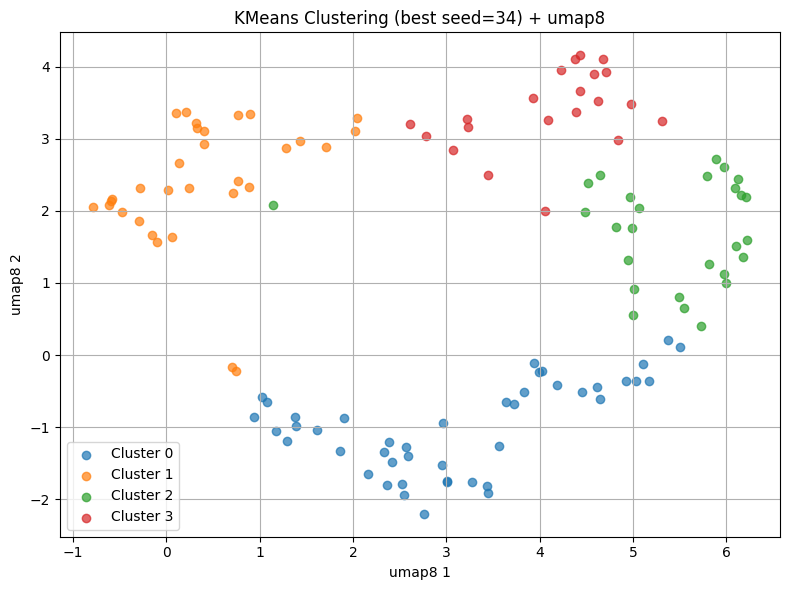

on serve_ on hard.csv
umap dimensions: 8
Best seed: 2
Silhouette score (best): 0.282
DBI score (best): 1.250


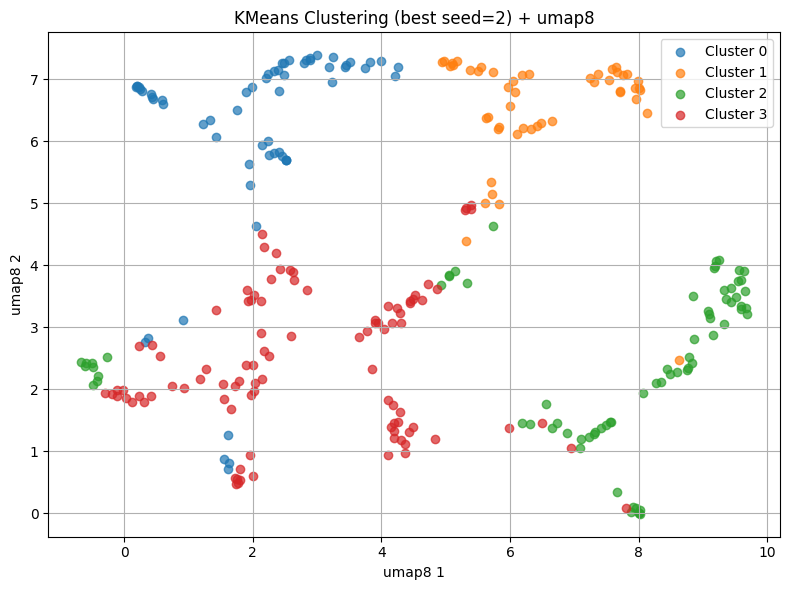

In [8]:
from run_clustering import run_kmeans_clustering
from run_clustering import run_kmeans_clustering_multiple


dfs_clustered_kmeans2d = []
dfs_clustered_kmeans8d = []

for dfs_umap in (dfs_umap_2d, dfs_umap_8d):
    umap_comp = 2 if dfs_umap is dfs_umap_2d else 8
    for name, dataframe in dfs_umap:
        print(name)
        print("umap dimensions: " + str(umap_comp))
        metrics = []
        df_clustered = run_kmeans_clustering_multiple(dataframe, dimensionality_reduction="umap"+str(umap_comp))
        if umap_comp == 2:
            dfs_clustered_kmeans2d.append((name, df_clustered))
        else:
            dfs_clustered_kmeans8d.append((name, df_clustered))

Another type of clustering algorithm is now tested, using the UMAP reduction. A hierarchical solution can be useful, since we can specify the number of cluster needed, so that the resulting dendogram can be cutted to obain that number. In particular the `AgglomerativeClustering()` function from **sklearn** id used, inside `run_umap_agglomerative_clustering` in [run_clustering.py](run_clustering.py) file..
Agglomerative clustering:

on response_ on clay.csv
umap dimensions: 2
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.366
Dbi score (Agglomerative + UMAP): 0.833


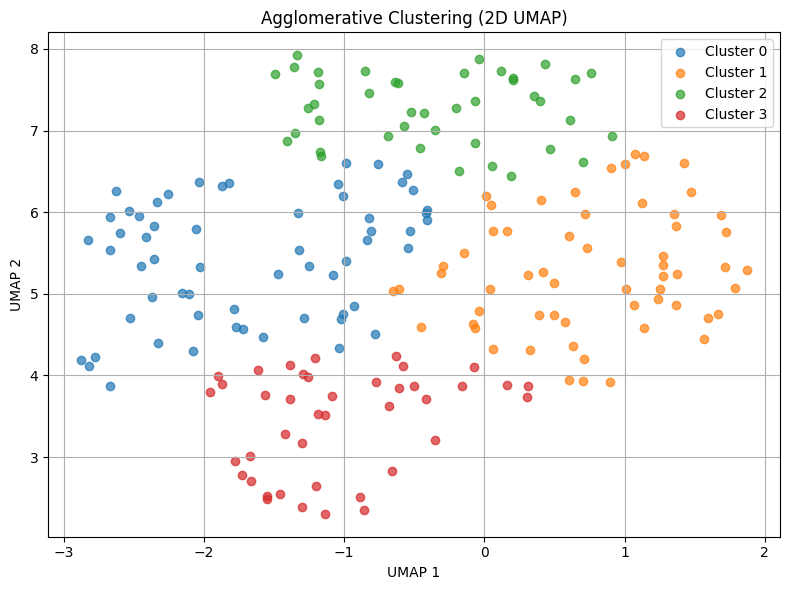

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.366
Dbi score (Agglomerative + UMAP): 0.852


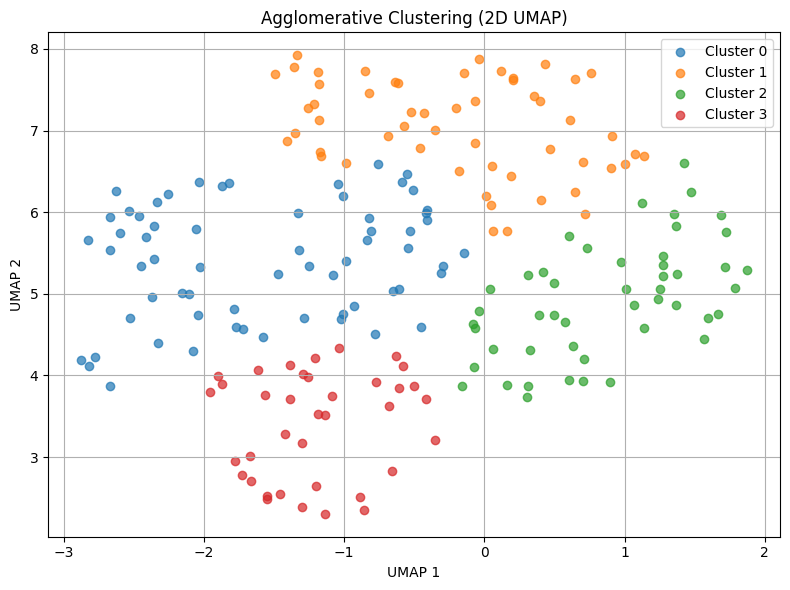

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.036
Dbi score (Agglomerative + UMAP): 0.715


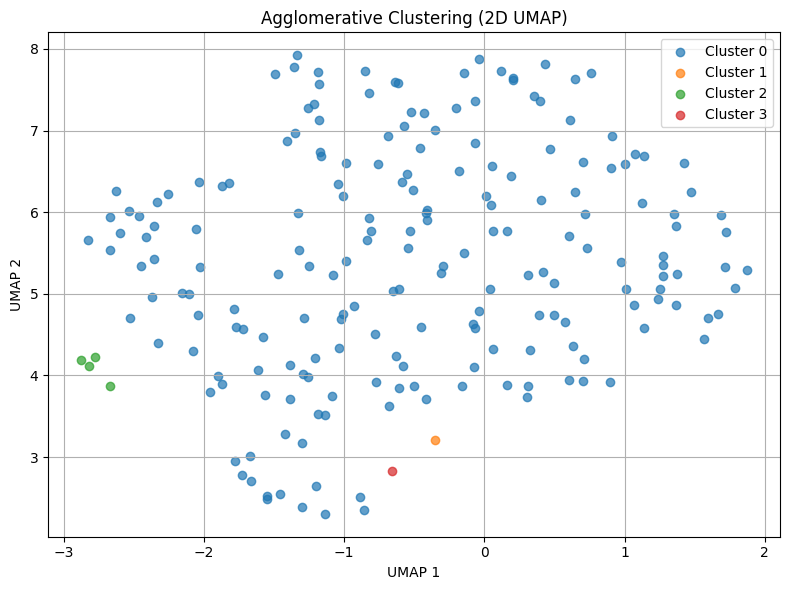

on response_ on grass.csv
umap dimensions: 2
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.318
Dbi score (Agglomerative + UMAP): 0.857


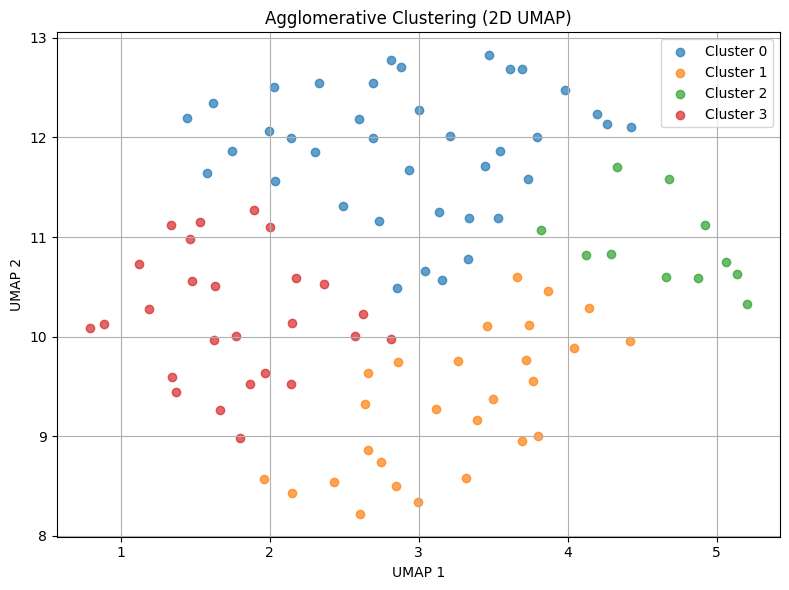

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.341
Dbi score (Agglomerative + UMAP): 0.876


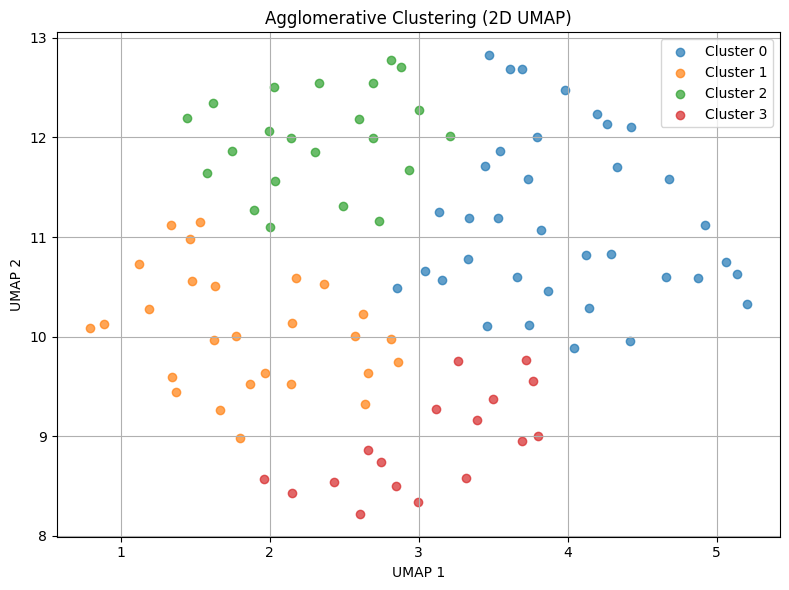

linkage method: single
Silhouette score (Agglomerative + UMAP): 0.142
Dbi score (Agglomerative + UMAP): 1.066


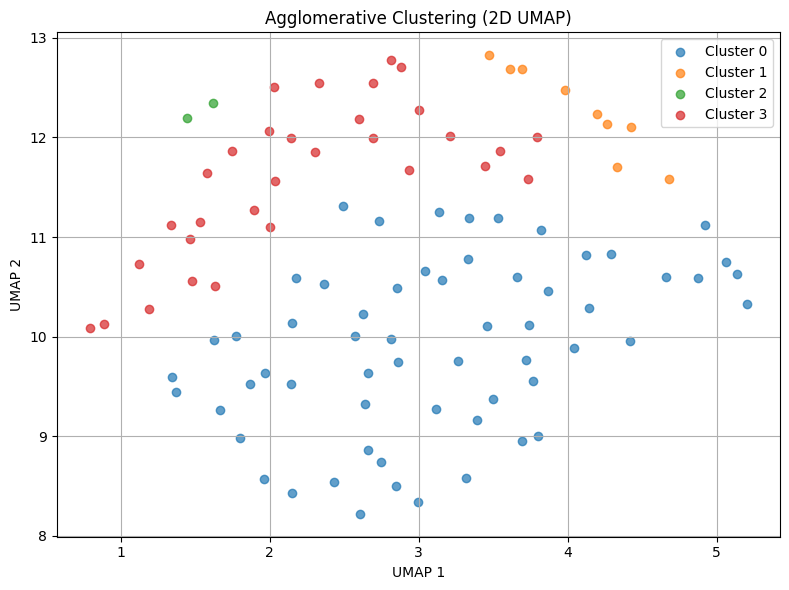

on response_ on hard.csv
umap dimensions: 2
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.401
Dbi score (Agglomerative + UMAP): 0.741


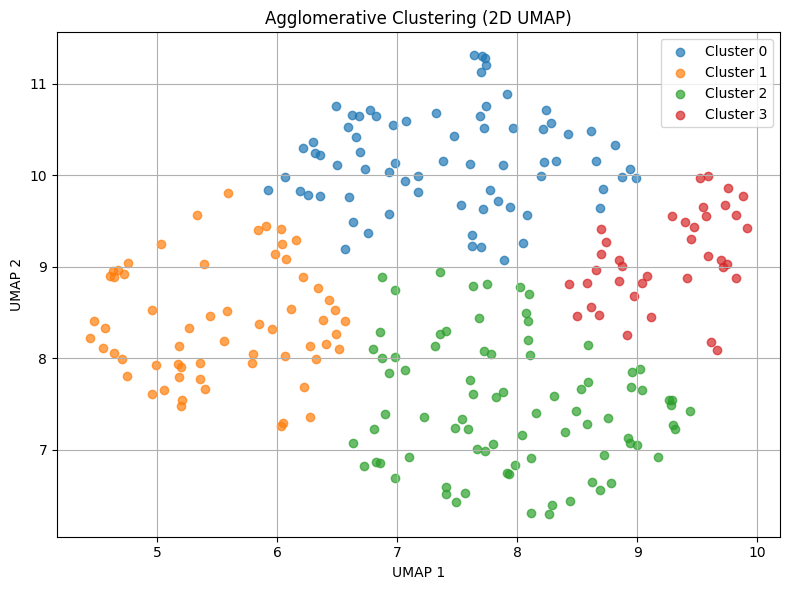

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.366
Dbi score (Agglomerative + UMAP): 0.790


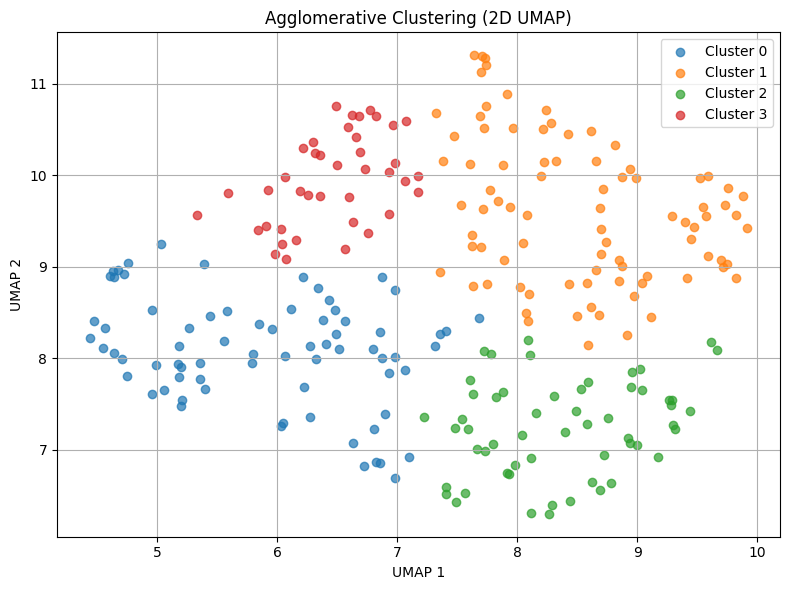

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.357
Dbi score (Agglomerative + UMAP): 1.987


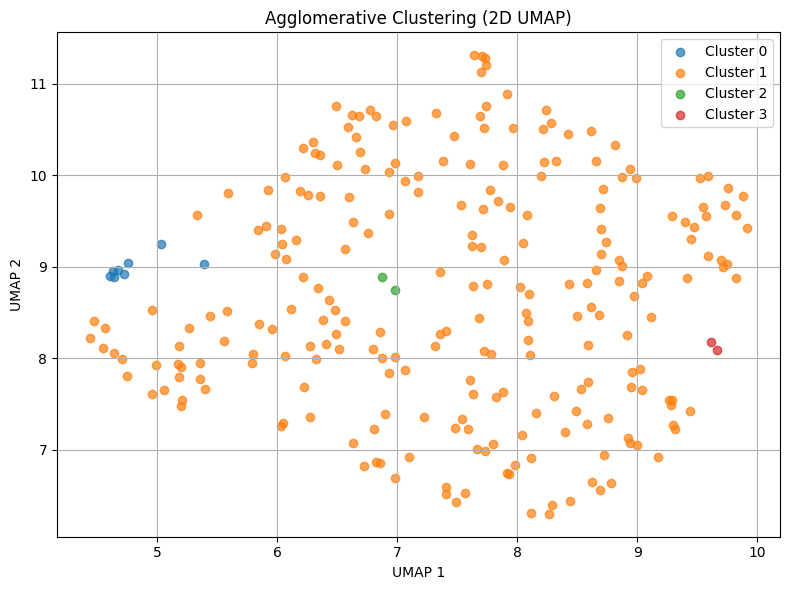

on serve_ on clay.csv
umap dimensions: 2
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.364
Dbi score (Agglomerative + UMAP): 0.828


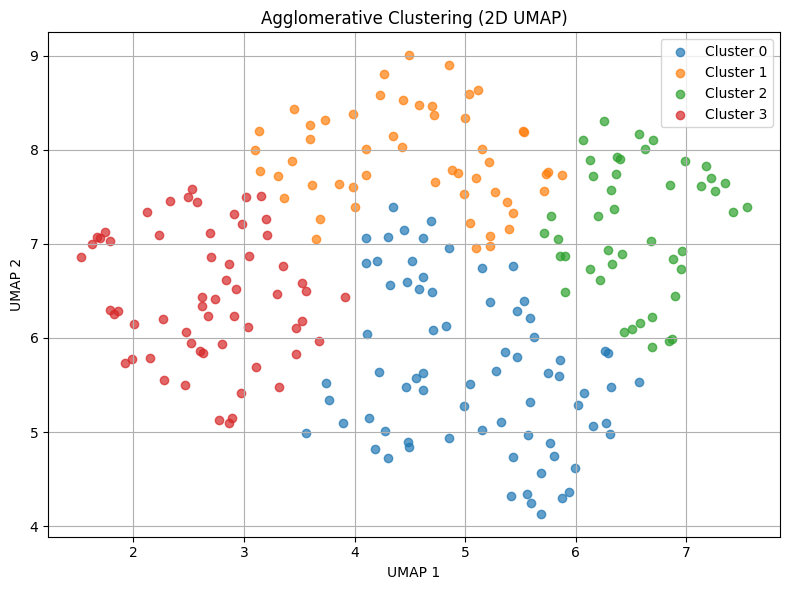

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.346
Dbi score (Agglomerative + UMAP): 0.865


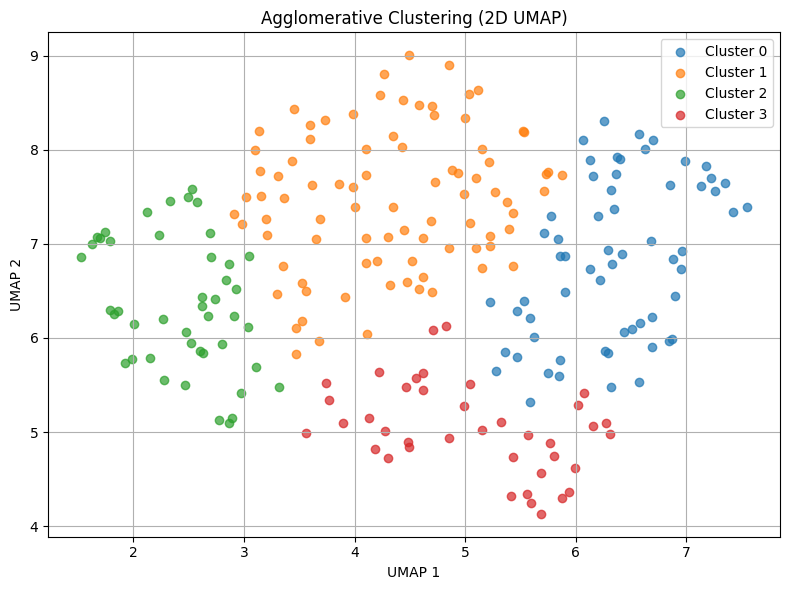

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.385
Dbi score (Agglomerative + UMAP): 1.414


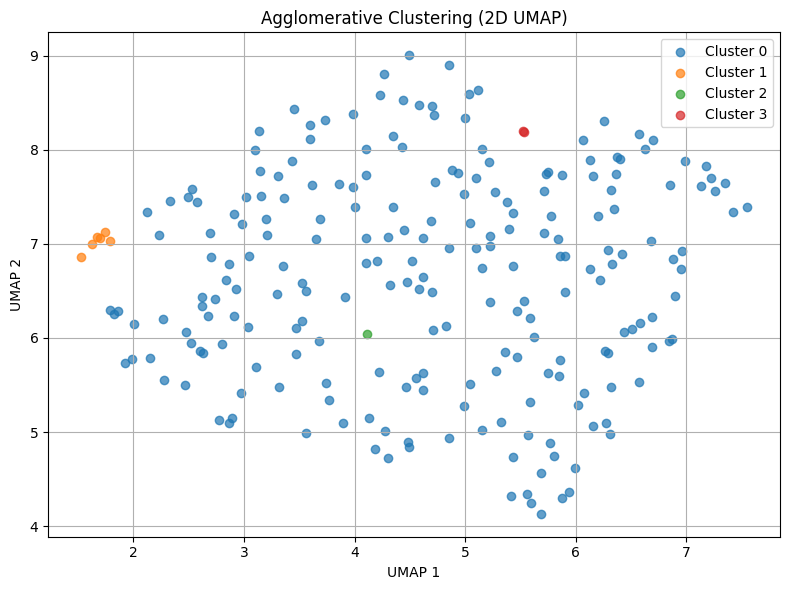

on serve_ on grass.csv
umap dimensions: 2
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.357
Dbi score (Agglomerative + UMAP): 0.964


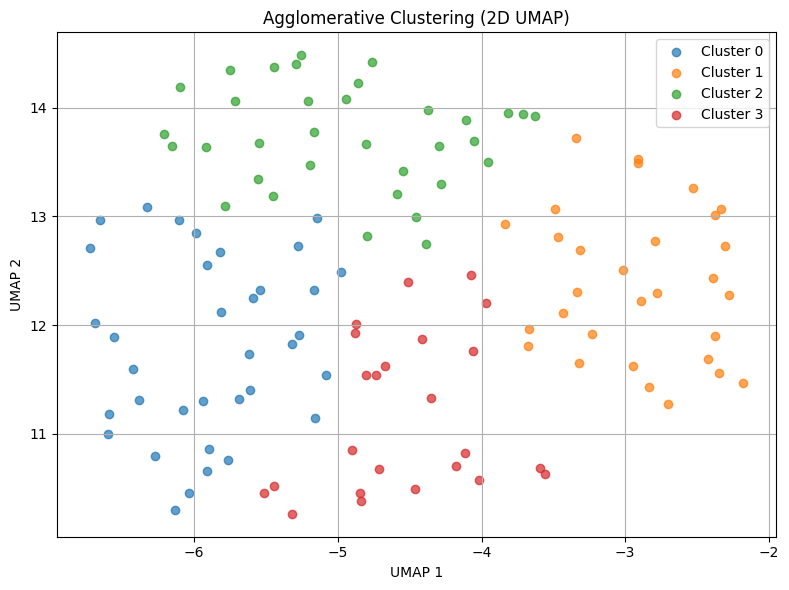

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.350
Dbi score (Agglomerative + UMAP): 0.928


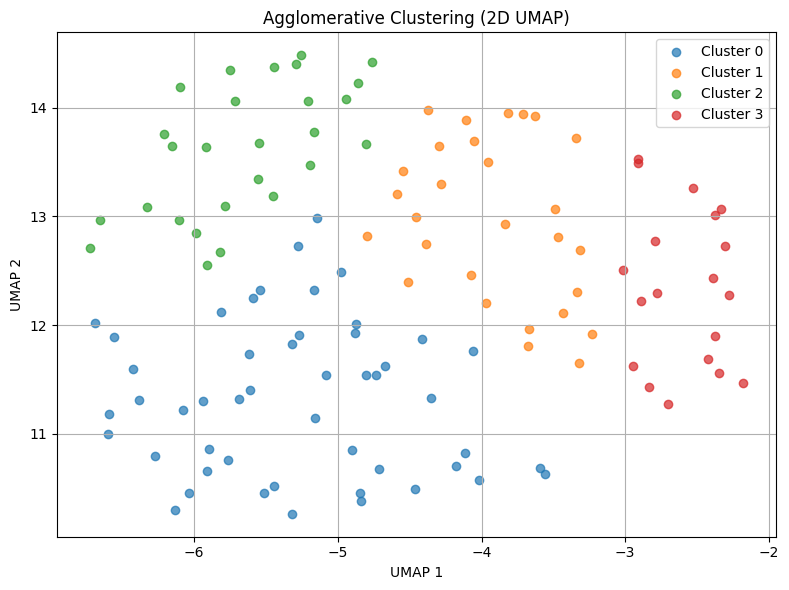

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.255
Dbi score (Agglomerative + UMAP): 1.104


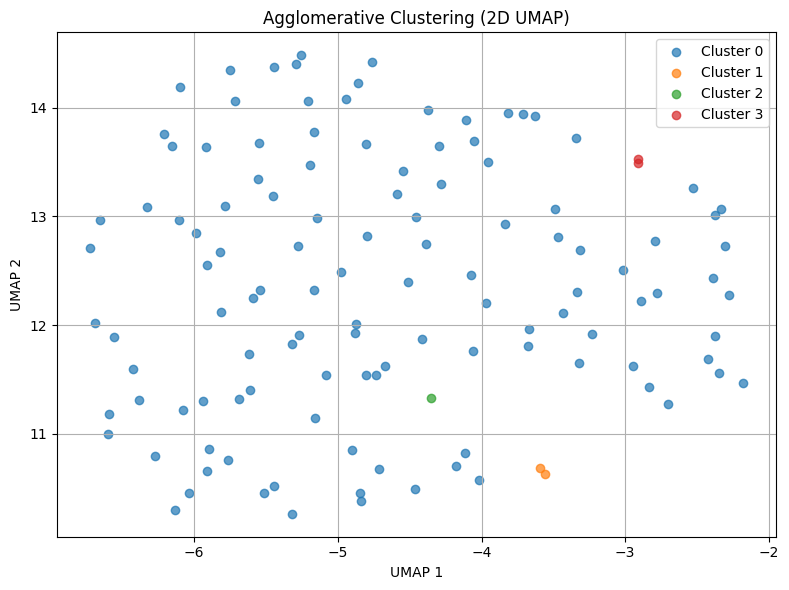

on serve_ on hard.csv
umap dimensions: 2
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.336
Dbi score (Agglomerative + UMAP): 0.858


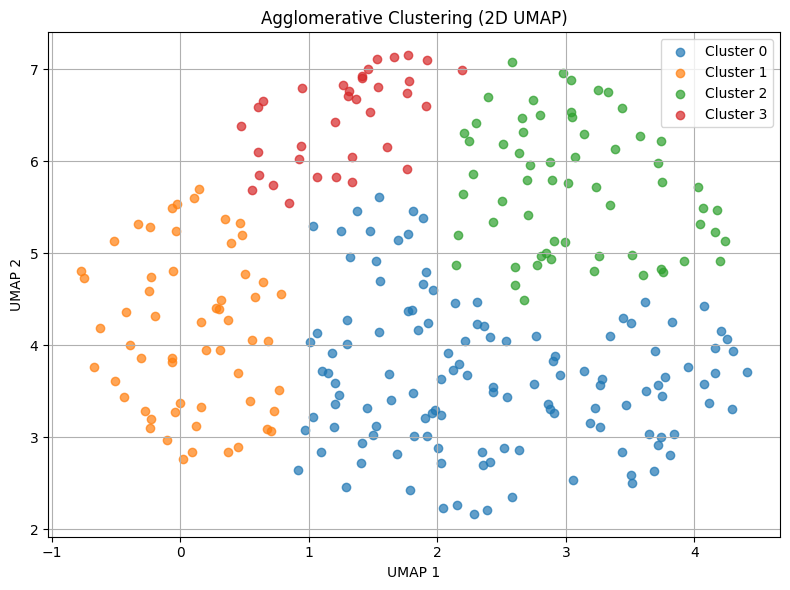

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.323
Dbi score (Agglomerative + UMAP): 0.873


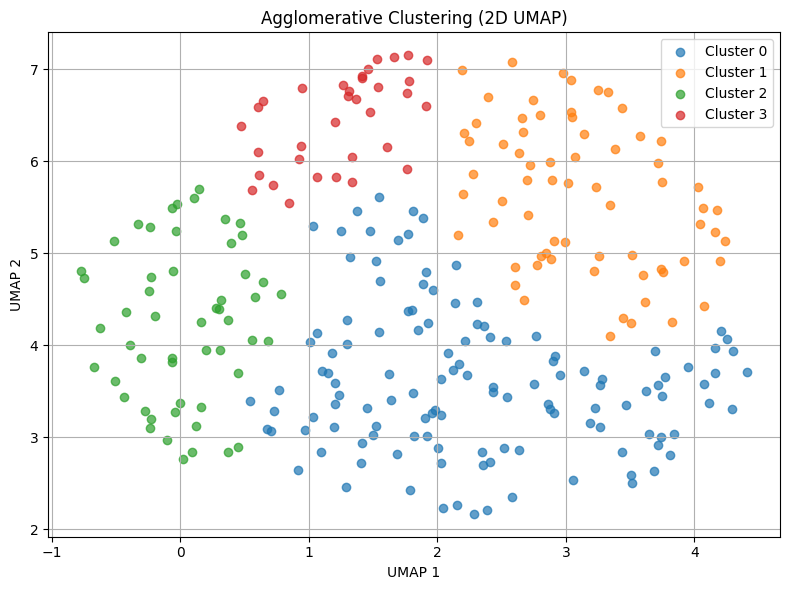

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.335
Dbi score (Agglomerative + UMAP): 0.704


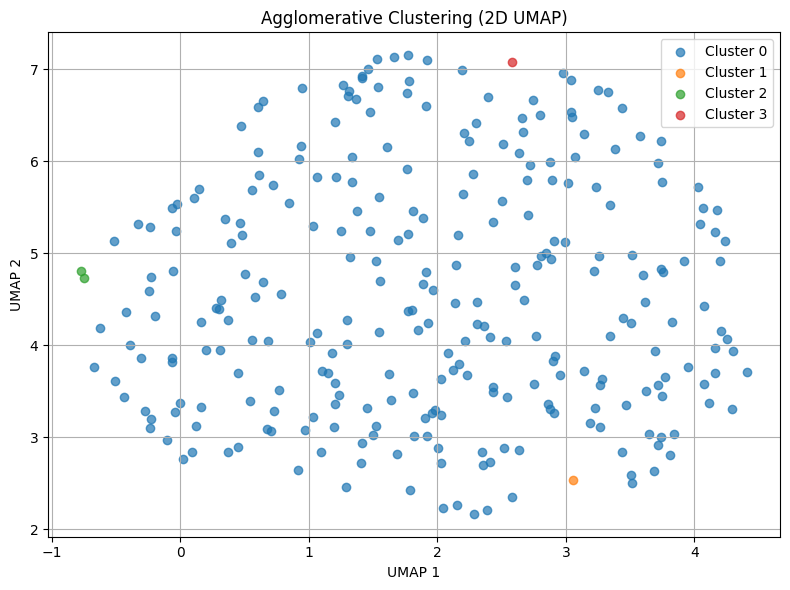

on response_ on clay.csv
umap dimensions: 8
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.230
Dbi score (Agglomerative + UMAP): 1.550


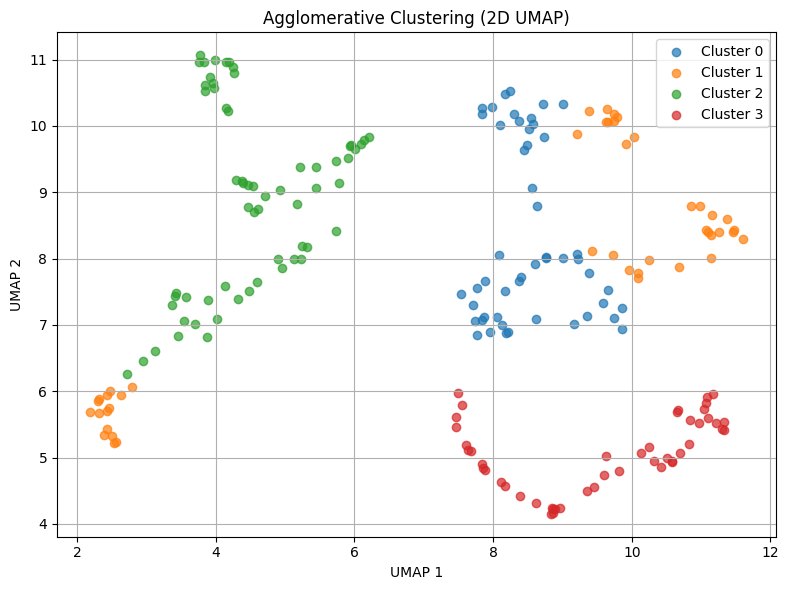

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.245
Dbi score (Agglomerative + UMAP): 1.458


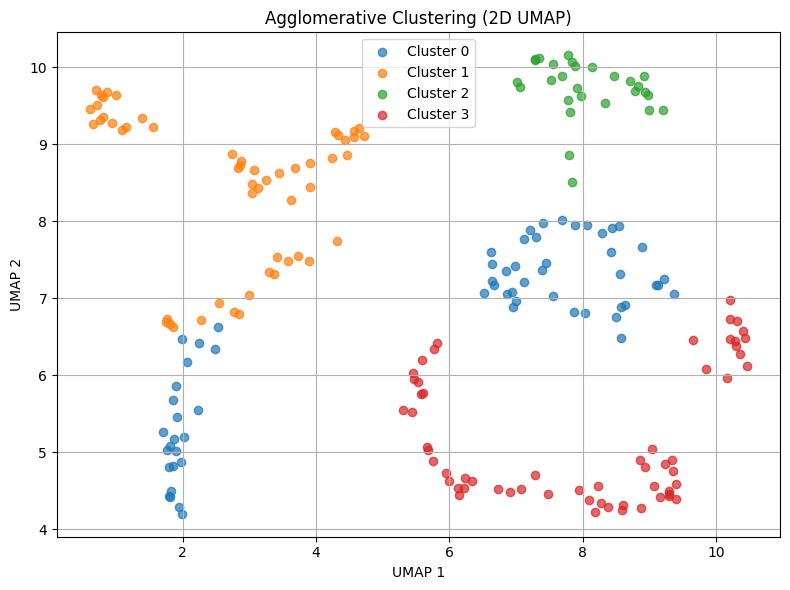

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.273
Dbi score (Agglomerative + UMAP): 1.519


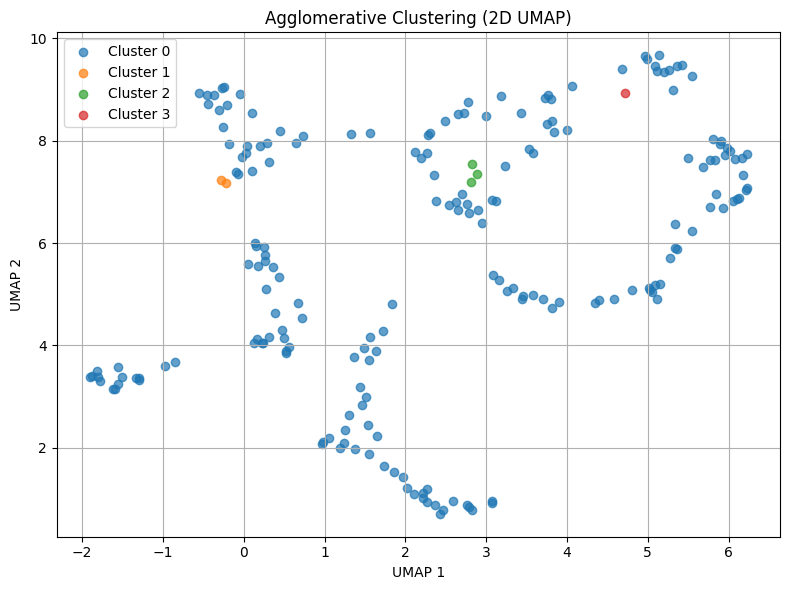

on response_ on grass.csv
umap dimensions: 8
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.217
Dbi score (Agglomerative + UMAP): 1.454


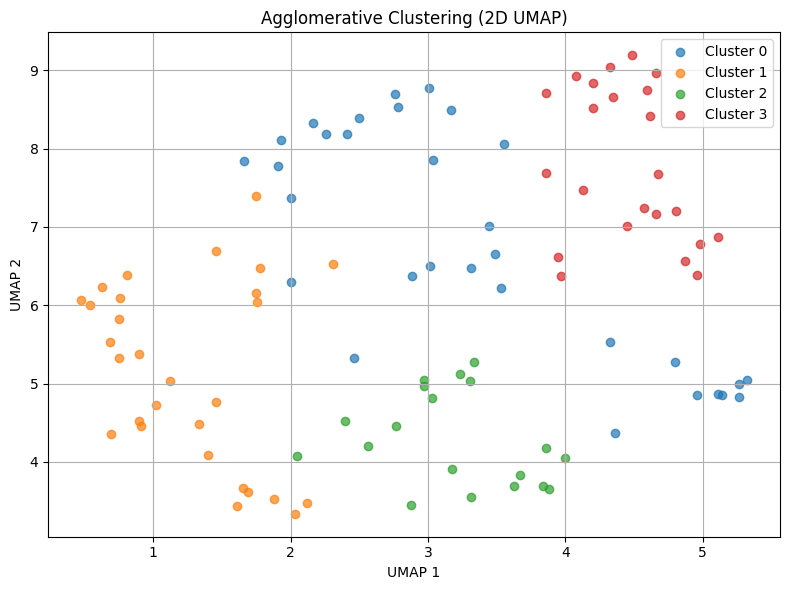

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.247
Dbi score (Agglomerative + UMAP): 1.165


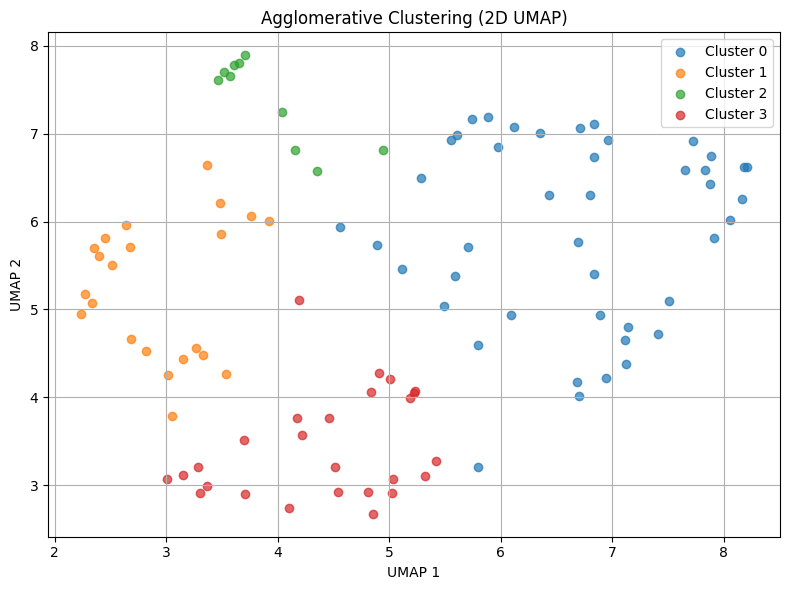

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.119
Dbi score (Agglomerative + UMAP): 1.470


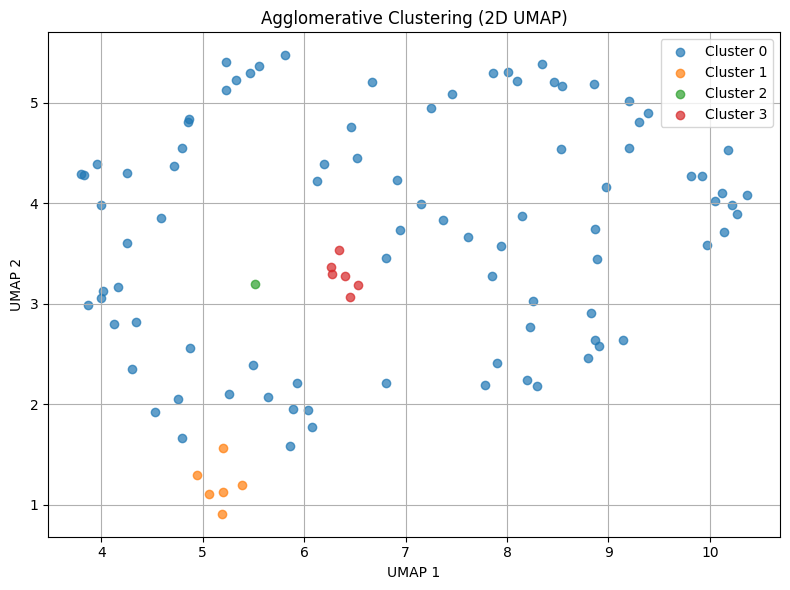

on response_ on hard.csv
umap dimensions: 8
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.293
Dbi score (Agglomerative + UMAP): 1.242


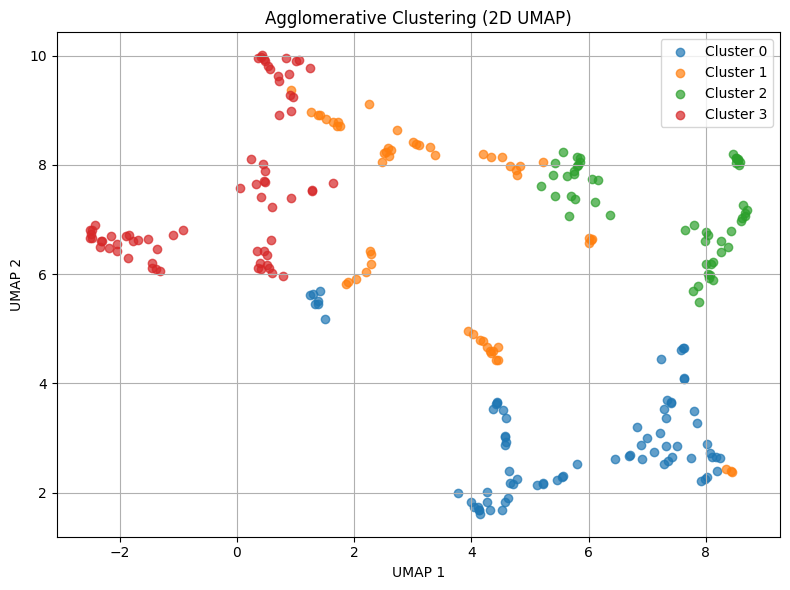

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.316
Dbi score (Agglomerative + UMAP): 1.167


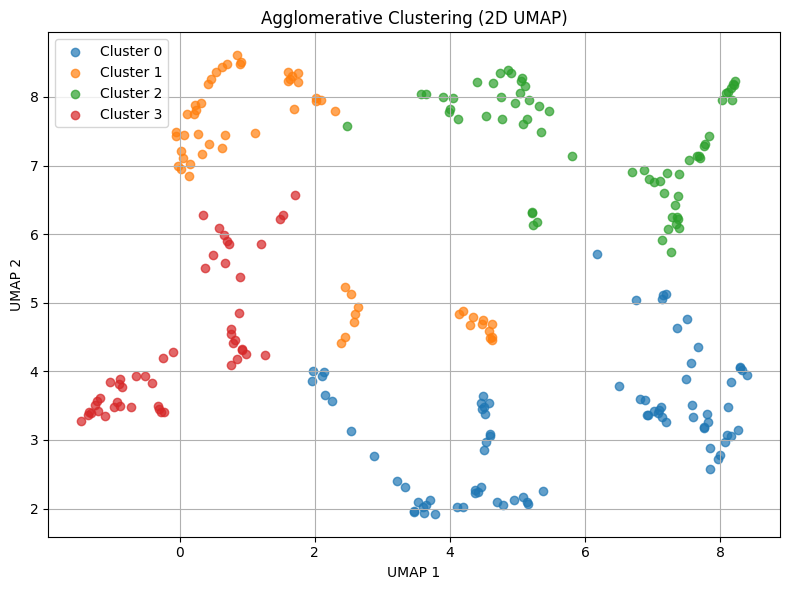

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.230
Dbi score (Agglomerative + UMAP): 1.486


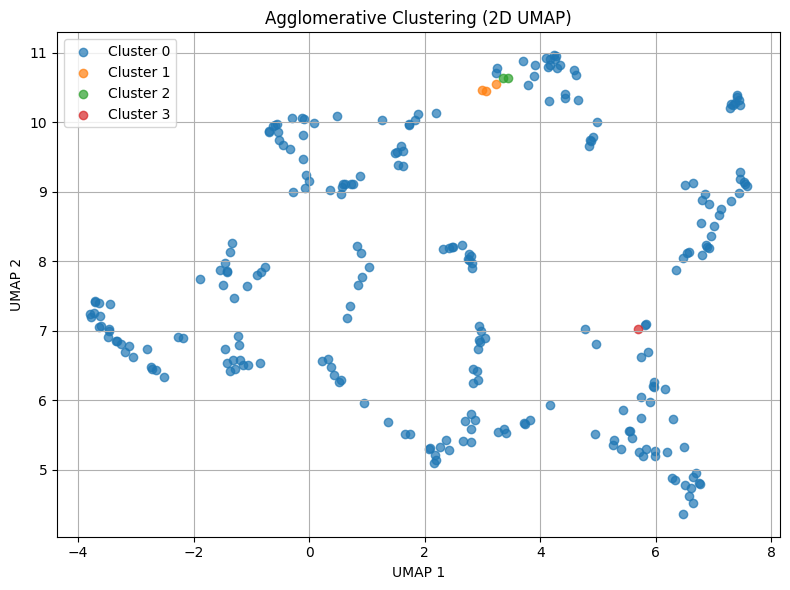

on serve_ on clay.csv
umap dimensions: 8
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.215
Dbi score (Agglomerative + UMAP): 1.501


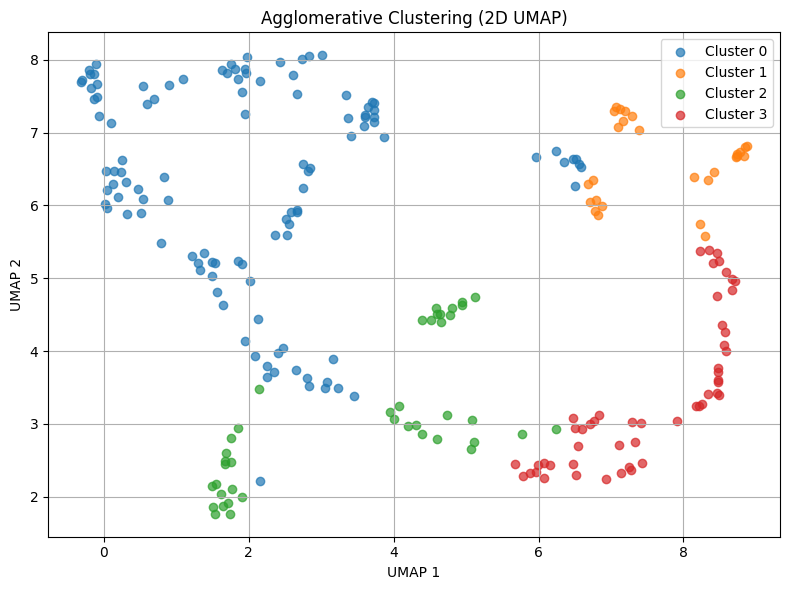

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.276
Dbi score (Agglomerative + UMAP): 1.318


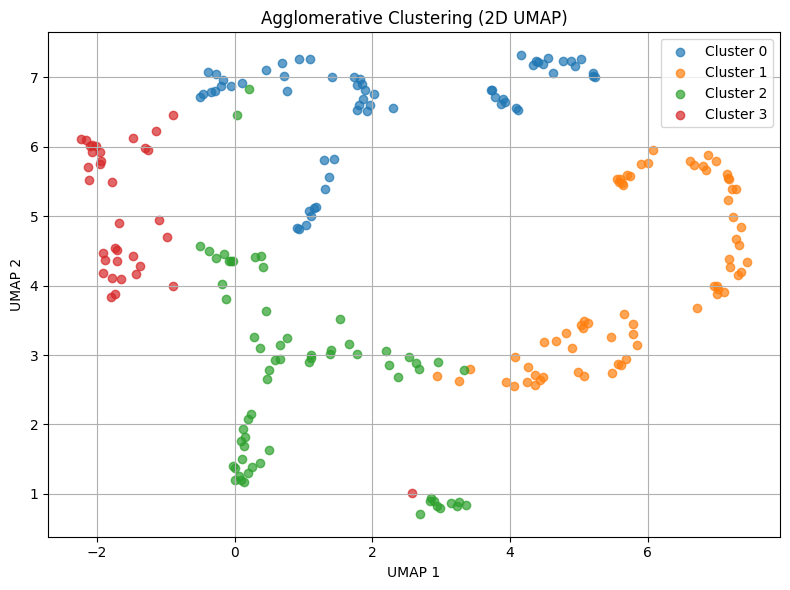

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.253
Dbi score (Agglomerative + UMAP): 1.375


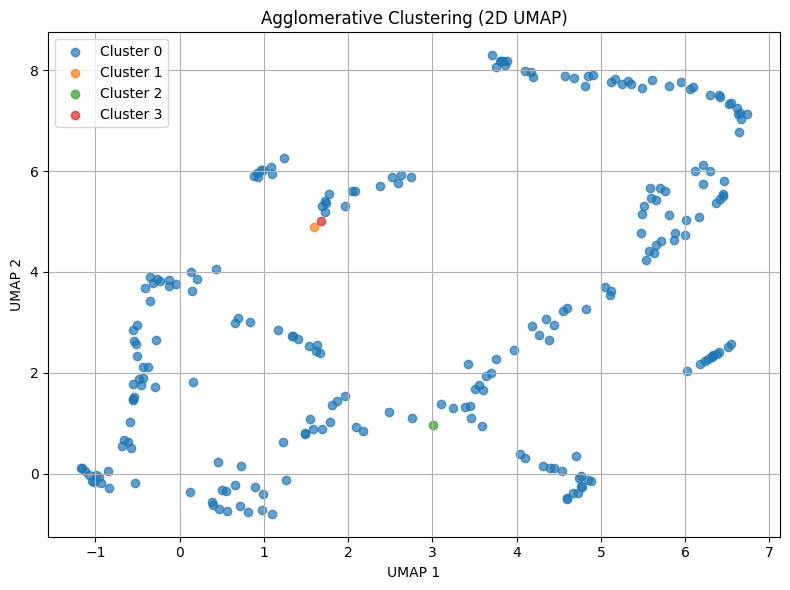

on serve_ on grass.csv
umap dimensions: 8
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.263
Dbi score (Agglomerative + UMAP): 1.344


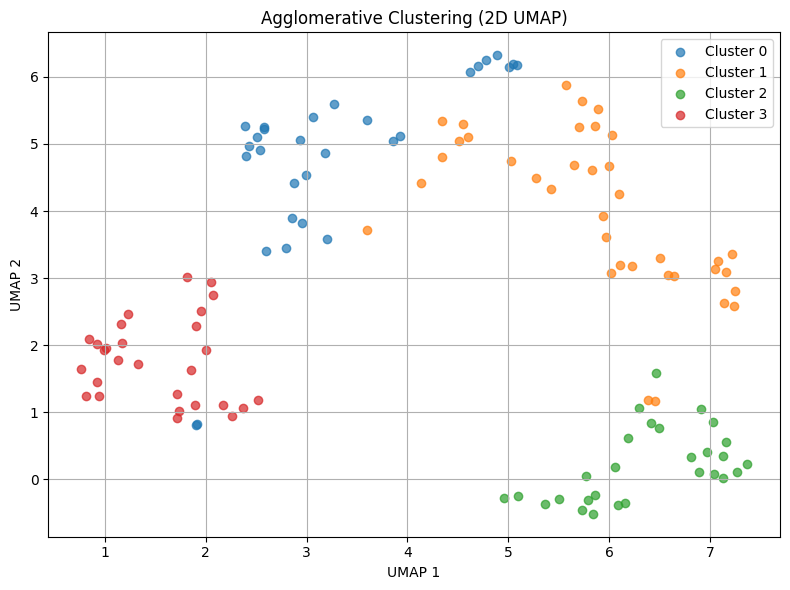

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.266
Dbi score (Agglomerative + UMAP): 1.310


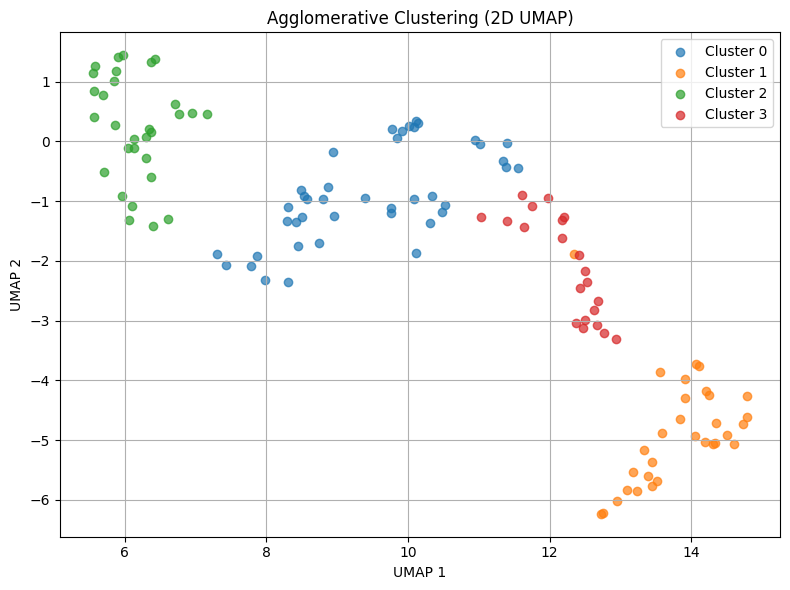

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.098
Dbi score (Agglomerative + UMAP): 1.440


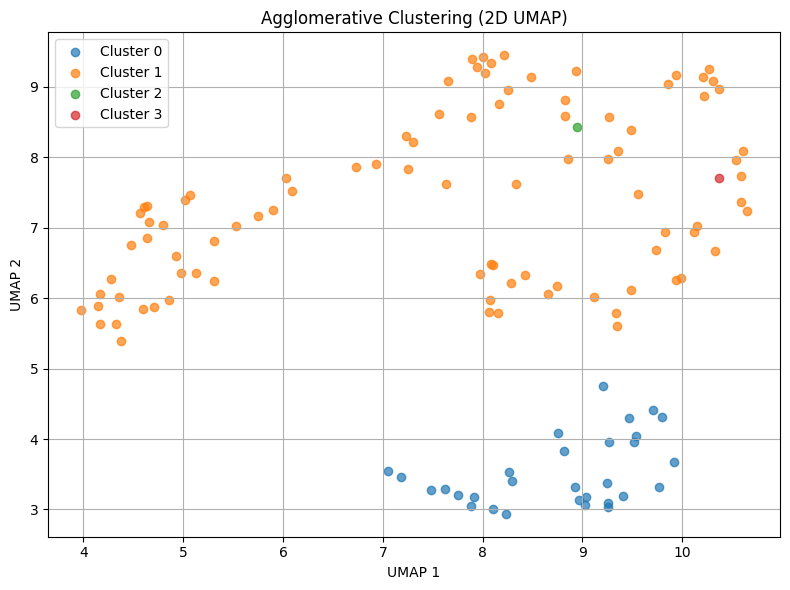

on serve_ on hard.csv
umap dimensions: 8
linkage method: complete
Silhouette score (Agglomerative + UMAP): 0.244
Dbi score (Agglomerative + UMAP): 1.431


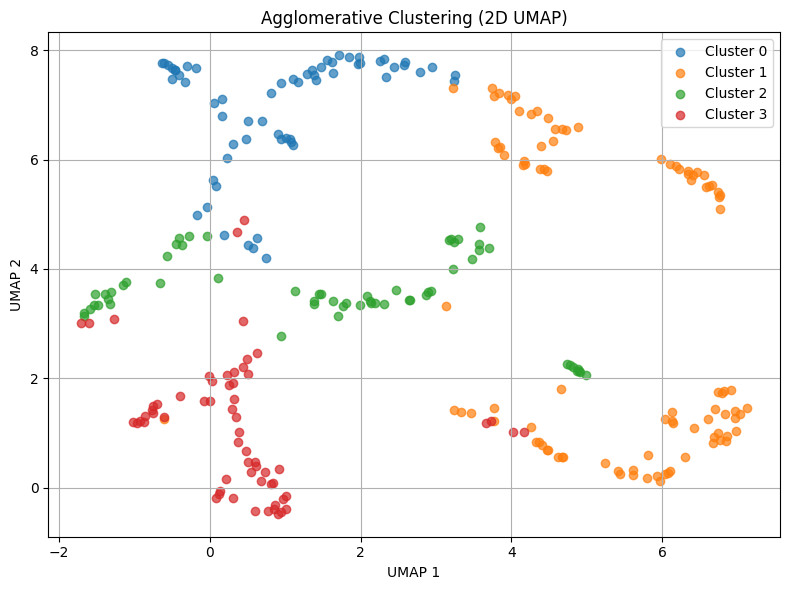

linkage method: average
Silhouette score (Agglomerative + UMAP): 0.235
Dbi score (Agglomerative + UMAP): 1.308


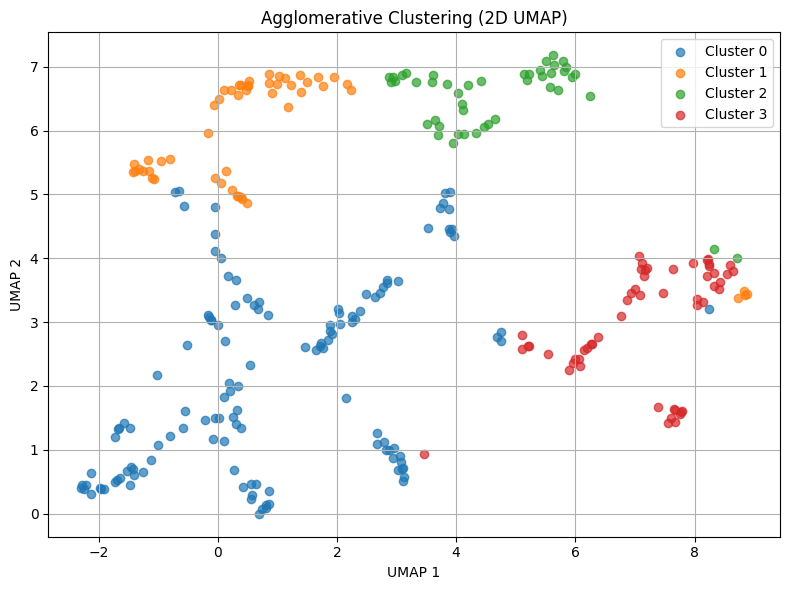

linkage method: single
Silhouette score (Agglomerative + UMAP): -0.281
Dbi score (Agglomerative + UMAP): 1.404


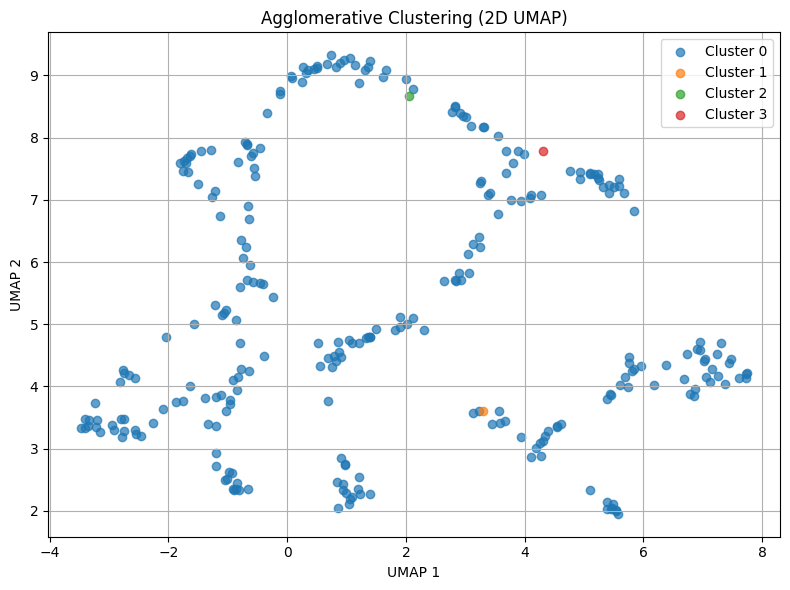

In [9]:
from run_clustering import run_umap_agglomerative_clustering

dfs_clustered_agglomerative_complete2d = []
dfs_clustered_agglomerative_average2d = []
dfs_clustered_agglomerative_single2d = []

dfs_clustered_agglomerative_complete8d = []
dfs_clustered_agglomerative_average8d = []
dfs_clustered_agglomerative_single8d = []

for dfs_umap in (dfs_umap_2d, dfs_umap_8d):
    umap_comp = 2 if dfs_umap is dfs_umap_2d else 8
    for name, dataframe in dfs_umap:
        print(name)
        print("umap dimensions: " + str(umap_comp))
        metrics = []

        # run with complete, single, average linkage methods
        print("linkage method: complete")
        df_clustered = run_umap_agglomerative_clustering(dataframe, linkage='complete', umap_comp = umap_comp)
        
        print("linkage method: average")
        df_clustered = run_umap_agglomerative_clustering(dataframe, linkage='average', umap_comp = umap_comp)
        
        print("linkage method: single")
        df_clustered = run_umap_agglomerative_clustering(dataframe, linkage='single', umap_comp = umap_comp)
        if umap_comp == 2:
            # adding clustered datasets to the lists
            dfs_clustered_agglomerative_complete2d.append((name, df_clustered))
            dfs_clustered_agglomerative_average2d.append((name, df_clustered))
            dfs_clustered_agglomerative_single2d.append((name, df_clustered))
        else:
            # adding clustered datasets to the lists
            dfs_clustered_agglomerative_complete8d.append((name, df_clustered))
            dfs_clustered_agglomerative_average8d.append((name, df_clustered))
            dfs_clustered_agglomerative_single8d.append((name, df_clustered))

Running the algorithms the results are clear, the agglomerative clustering performs well with **complete** and **average** linkage methods, while performs poorly with **single**. This behaviour can be explained by the fact that single linkage tends to form long chain-like clusters, often ignoring natural, well-separated groupings. In contrast, the other linkage methods are better at recognizing distinct cluster shapes. However, agglomerative clustering does not show a significant improvement over KMeans. On the contrary, the metrics indicate a slight drop in performance, with a clear advantage for 2D UMAP over 8D.

Even if the number of cluster parameter cannot being specified, a density based algorithm, OPTICS, is tested, hoping to find a good clustering with the desired number of clusters. The algorithm specifies these parameters: 
* **min_pts**: The minimum number of points to form a dense region in OPTICS clustering. Defaults to 3.
* **xi**: A parameter for OPTICS that determines the minimum steepness on the reachability plot to identify clusters. Defaults to 0.08.
* **min_cluster_size**: The minimum relative size of a cluster in OPTICS as a fraction of the total number of data points. Defaults to 0.1.

OPTICS was tested using this choice of parameters. A noise percentage threshold was fixed at 30%, meaning that the silhouette score was computed only when the number of points classified as noise did not exceed 30% of the total. By varying the algorithm parameters, it becomes clear that, regardless of the configuration, the percentage of noise remains high. This indicates that the point structure lacks clearly defined dense regions. Even in datasets where such regions exist, the large number of noise points makes the use of OPTICS ineffective, given the goal of assigning each player to a cluster.

OPTICS clustering:

on response_ on clay.csv
umap dimensions: 2
Number of clusters:  2
OPTICS found 2 cluster
The noise percentage exceed the user defined treshold.
Noise points: 151
Accepted max number of point classified as noise, based on noise percentage: 60.9


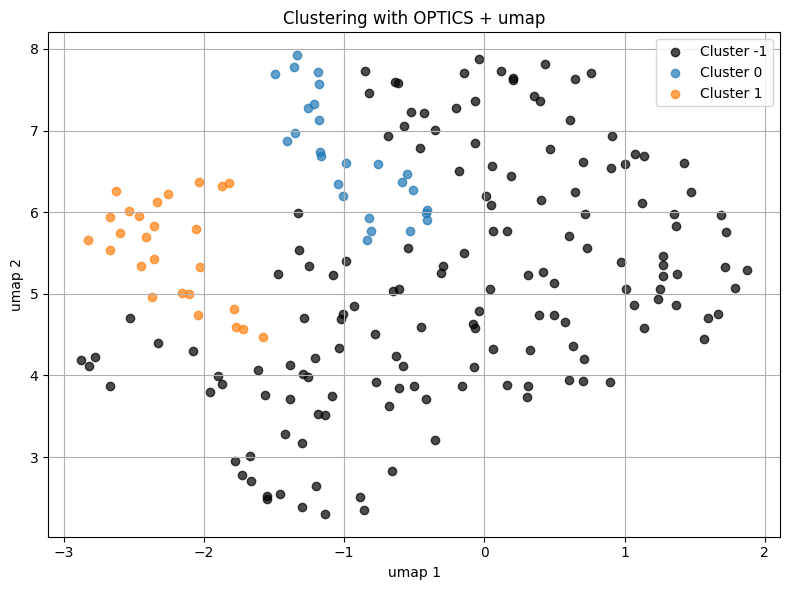

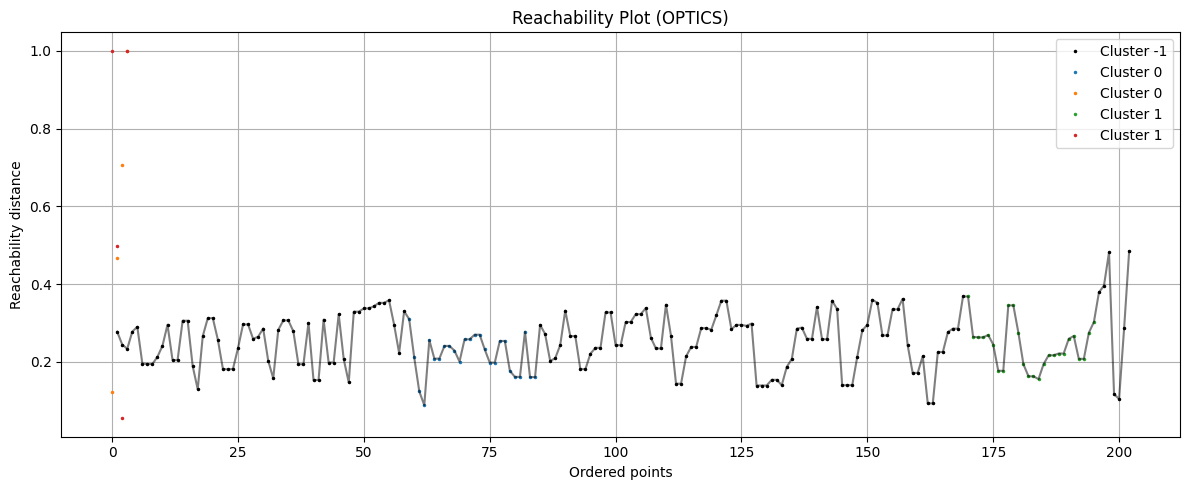

on response_ on grass.csv
umap dimensions: 2
Number of clusters:  2
OPTICS found 2 cluster
The noise percentage exceed the user defined treshold.
Noise points: 59
Accepted max number of point classified as noise, based on noise percentage: 30.599999999999998


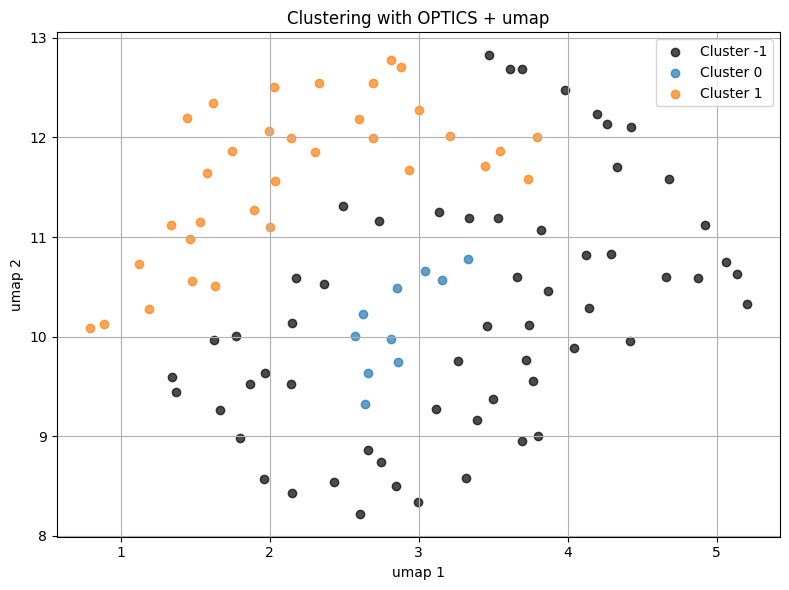

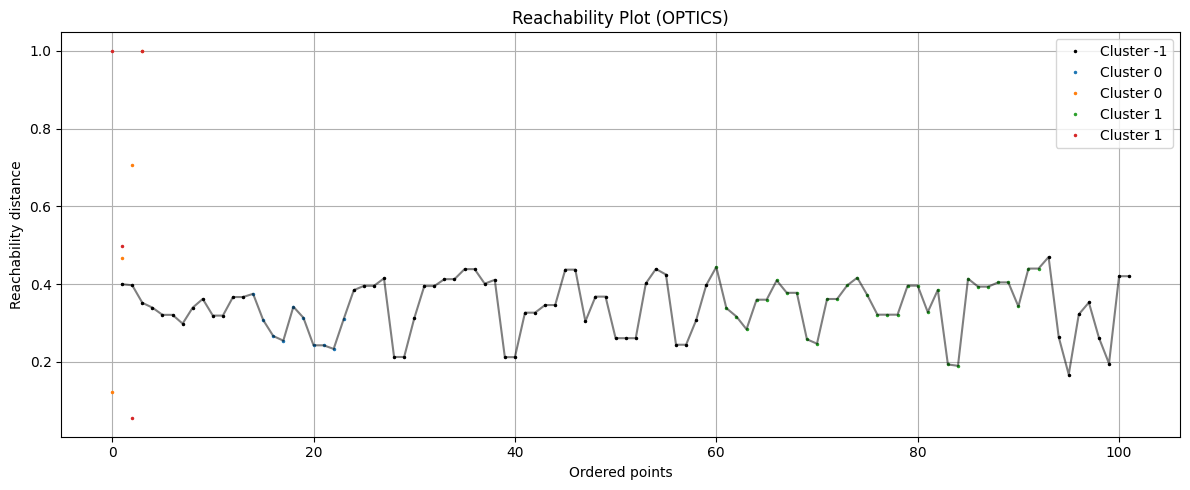

on response_ on hard.csv
umap dimensions: 2
Number of clusters:  2
OPTICS found 2 cluster
The noise percentage exceed the user defined treshold.
Noise points: 172
Accepted max number of point classified as noise, based on noise percentage: 76.2


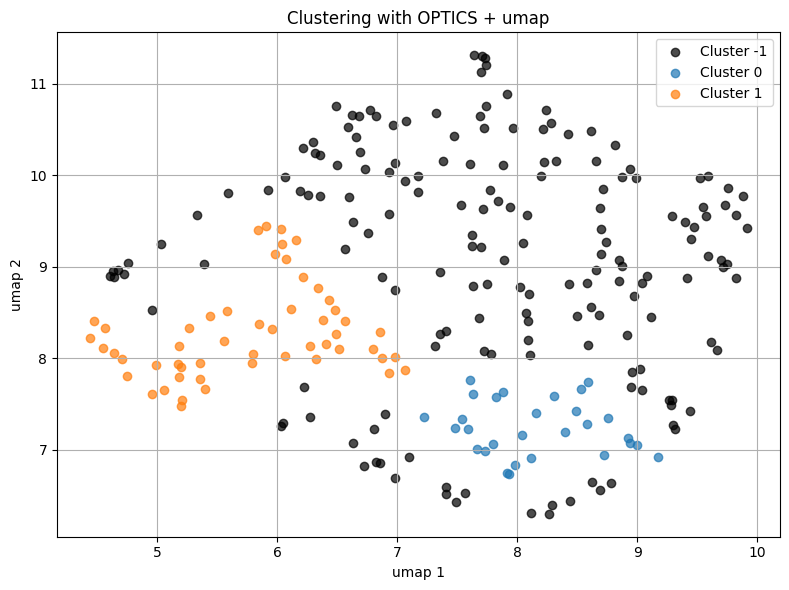

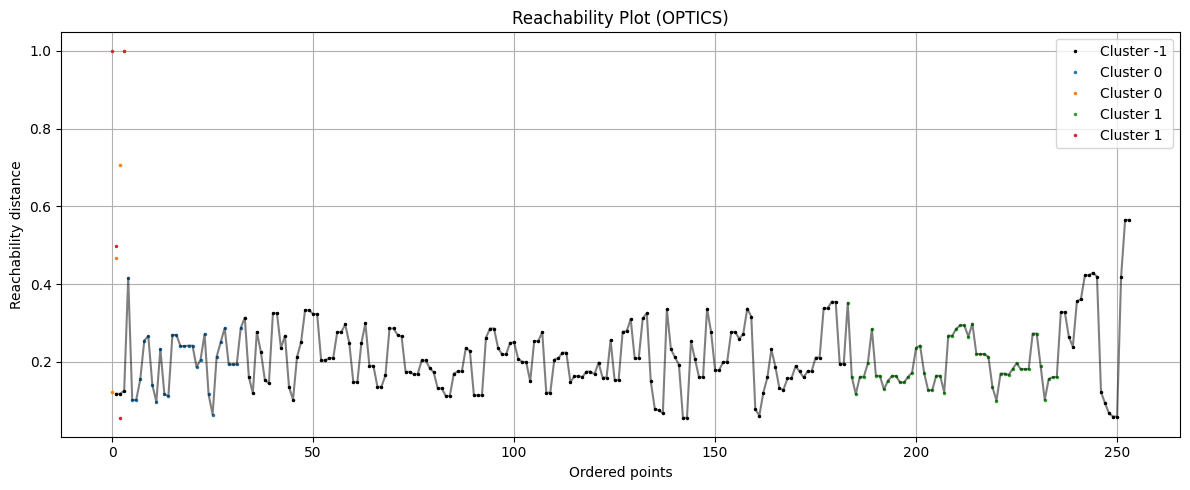

on serve_ on clay.csv
umap dimensions: 2
Number of clusters:  4
OPTICS found 4 cluster
The noise percentage exceed the user defined treshold.
Noise points: 94
Accepted max number of point classified as noise, based on noise percentage: 69.3


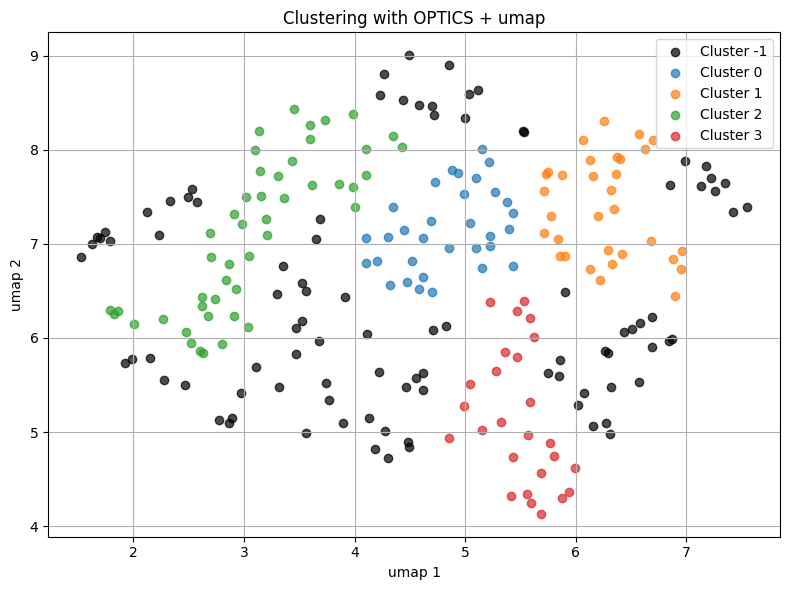

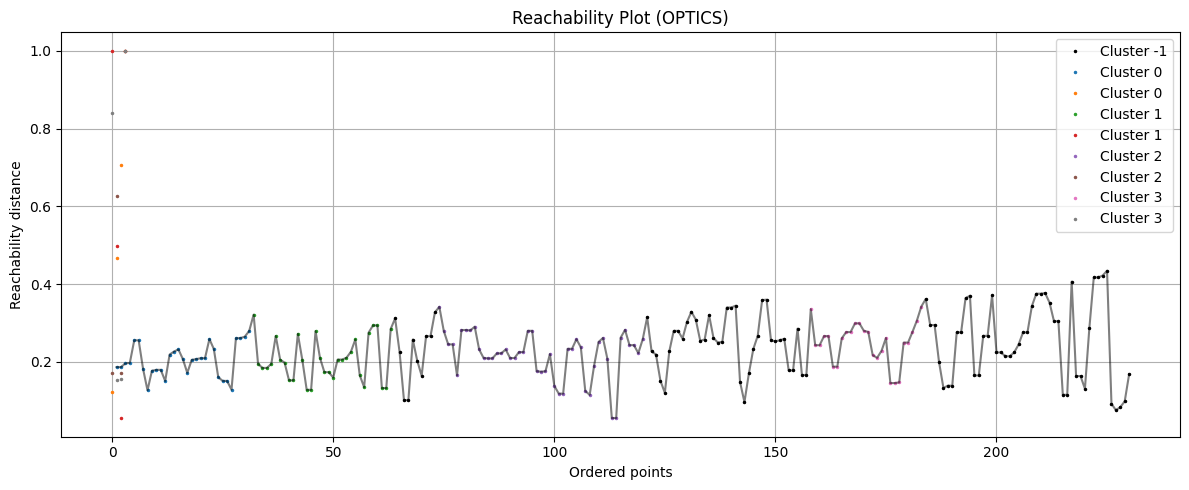

on serve_ on grass.csv
umap dimensions: 2
Number of clusters:  2
OPTICS found 2 cluster
The noise percentage exceed the user defined treshold.
Noise points: 61
Accepted max number of point classified as noise, based on noise percentage: 36.9


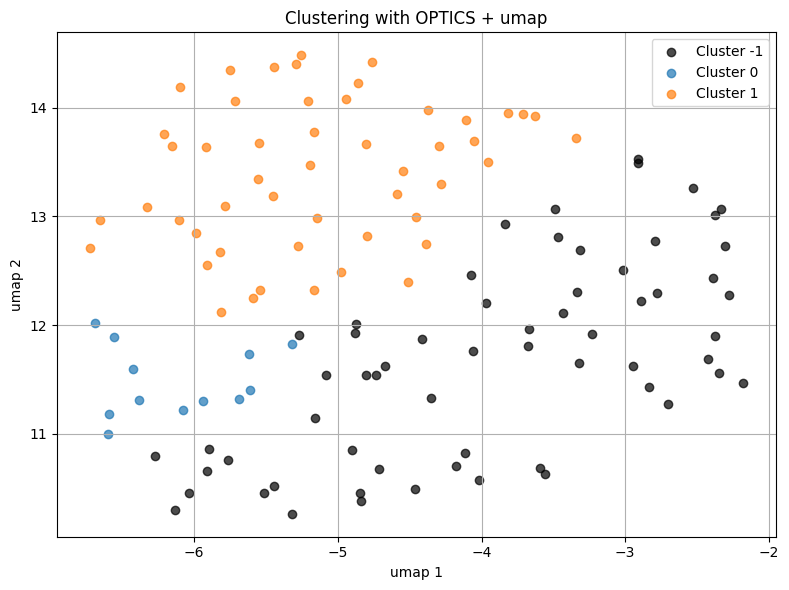

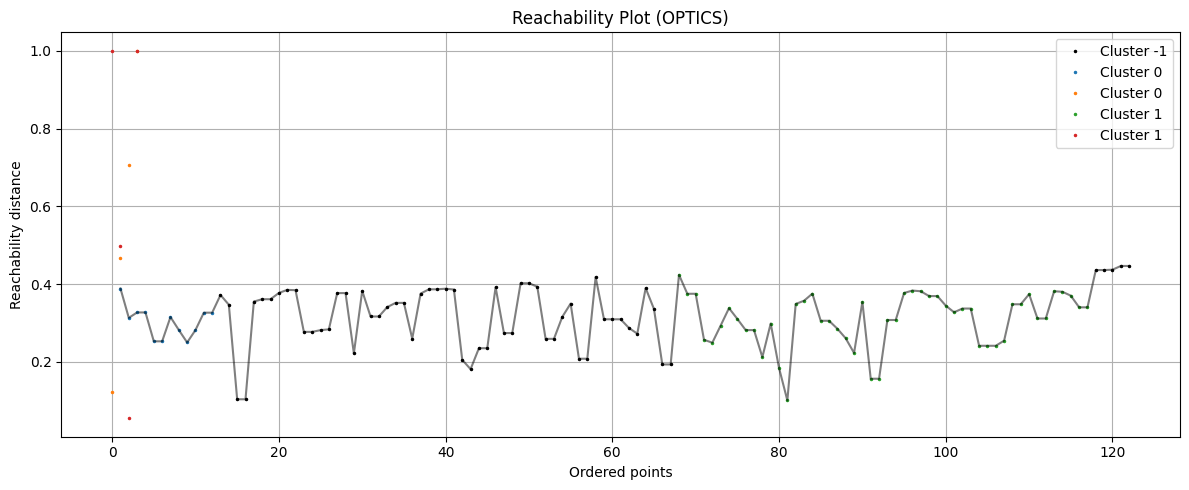

on serve_ on hard.csv
umap dimensions: 2
Number of clusters:  1


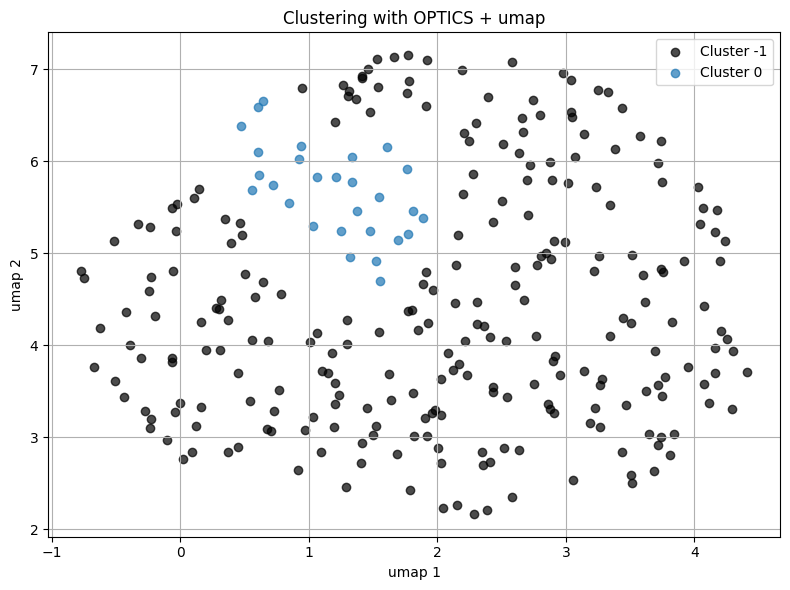

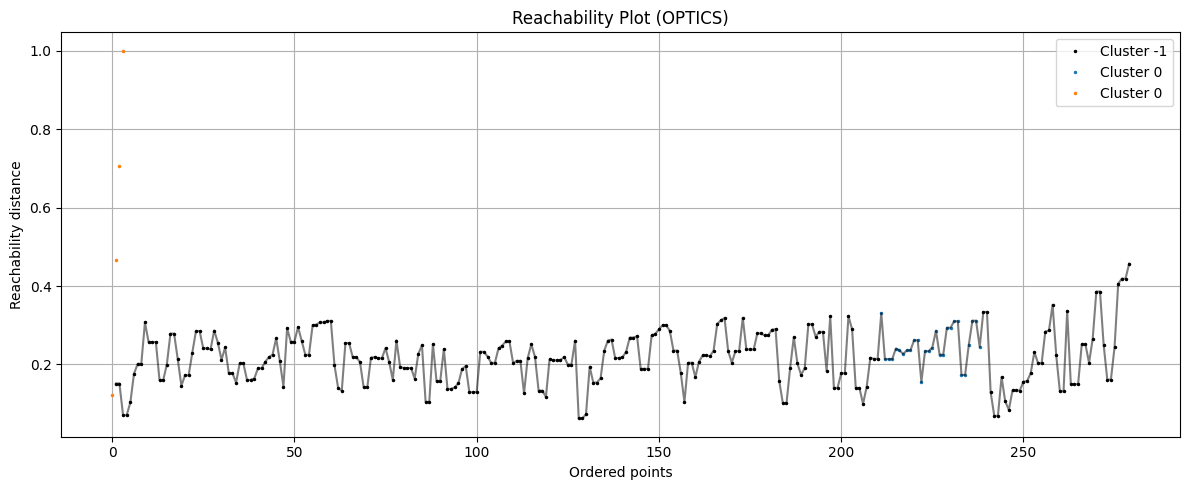

on response_ on clay.csv
umap dimensions: 8
Number of clusters:  2
OPTICS found 2 cluster
The noise percentage exceed the user defined treshold.
Noise points: 128
Accepted max number of point classified as noise, based on noise percentage: 60.9


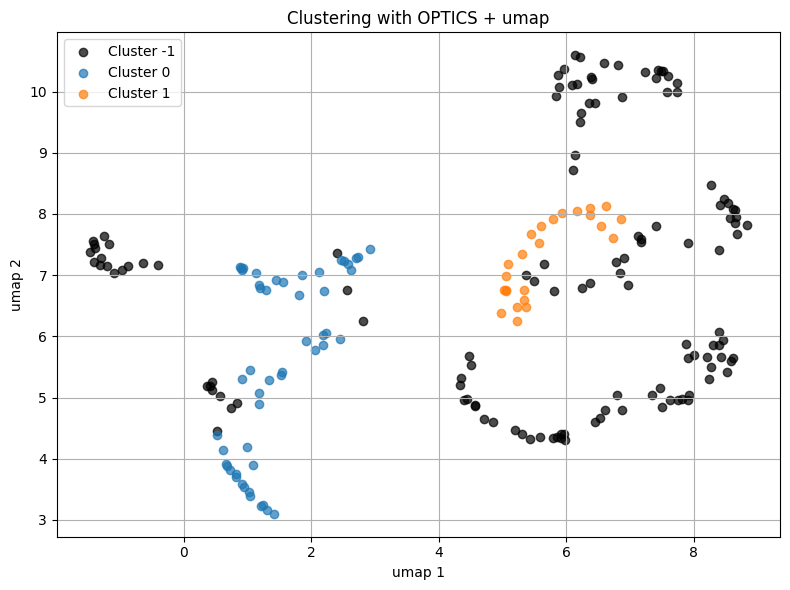

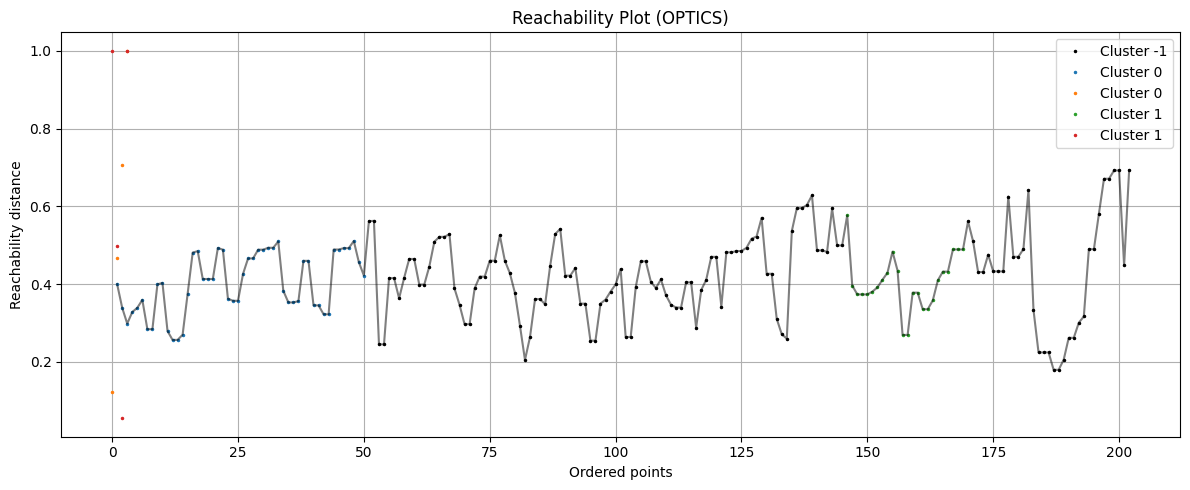

on response_ on grass.csv
umap dimensions: 8
Number of clusters:  1


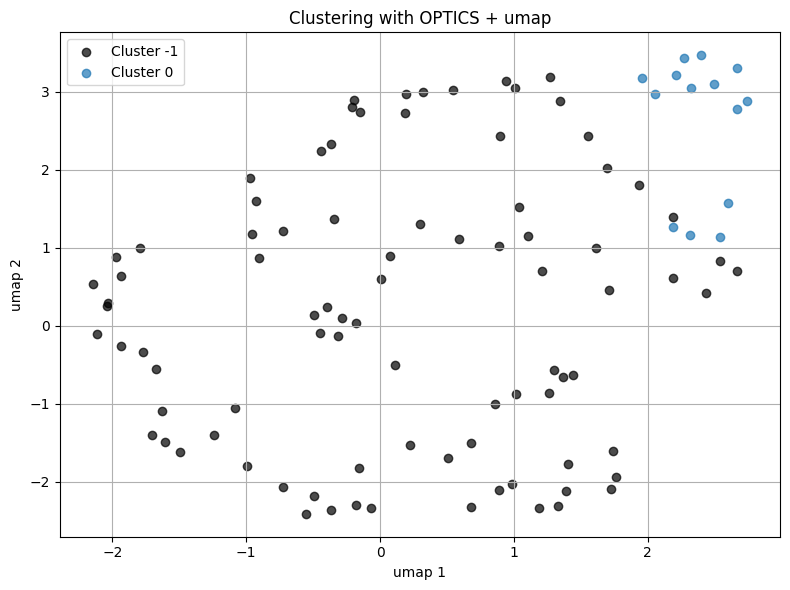

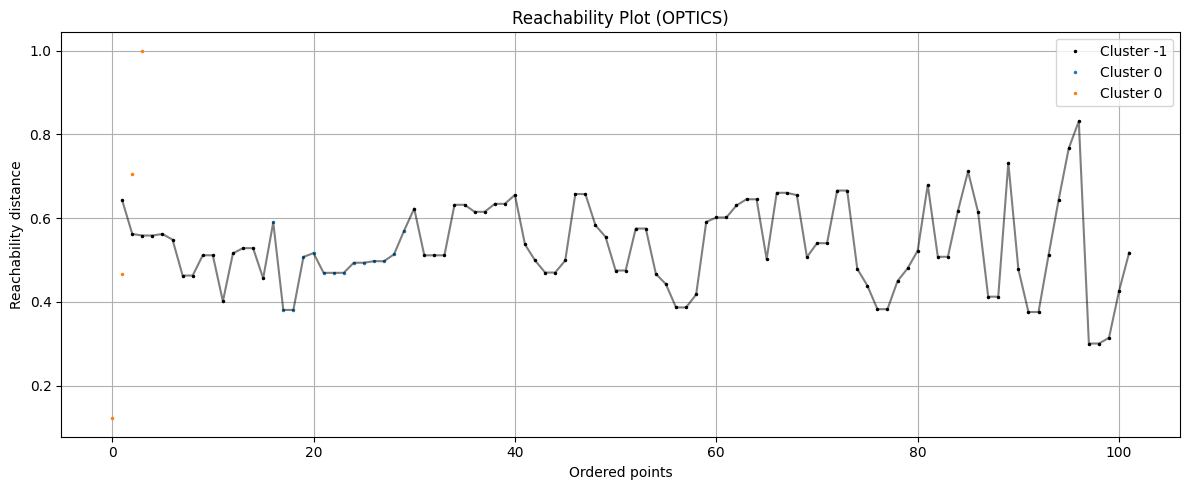

on response_ on hard.csv
umap dimensions: 8
Number of clusters:  3
OPTICS found 3 cluster
The noise percentage exceed the user defined treshold.
Noise points: 146
Accepted max number of point classified as noise, based on noise percentage: 76.2


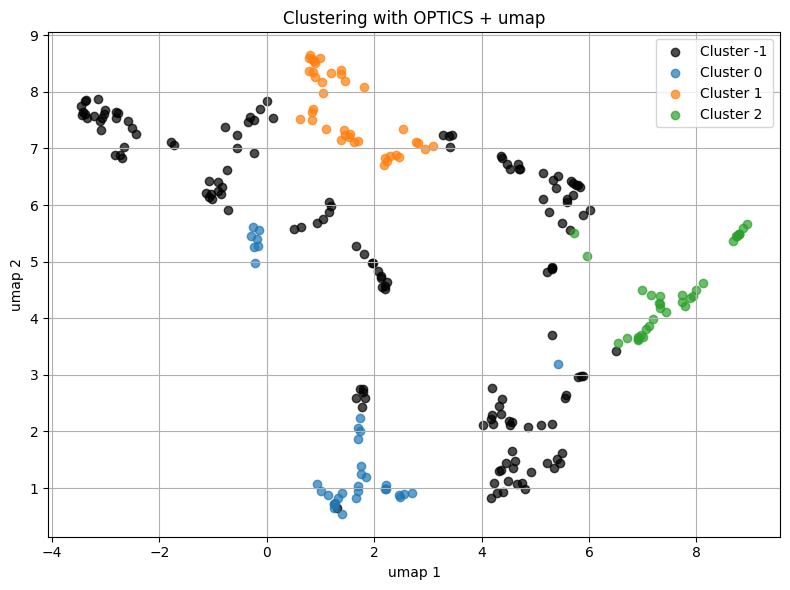

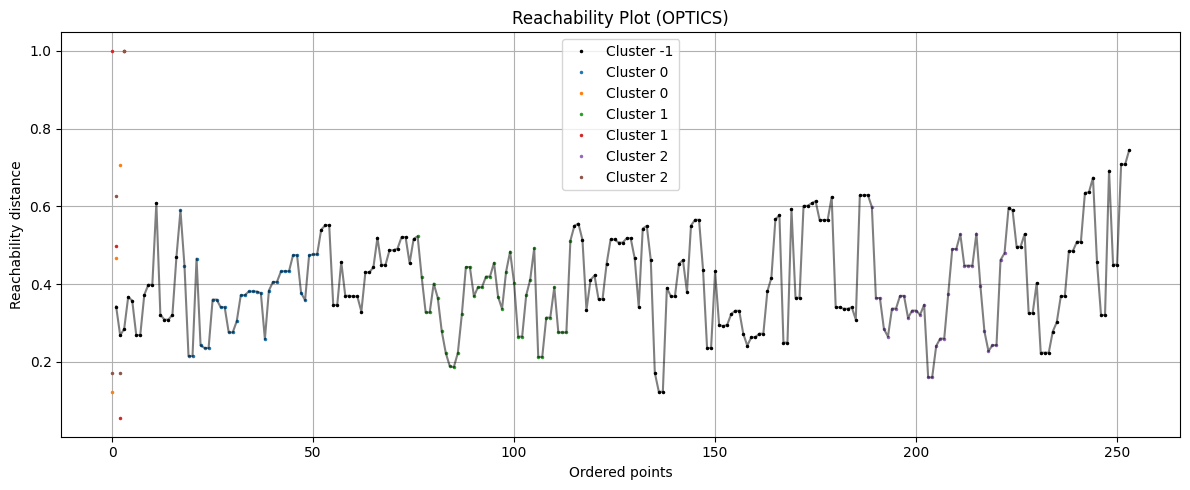

on serve_ on clay.csv
umap dimensions: 8
Number of clusters:  1


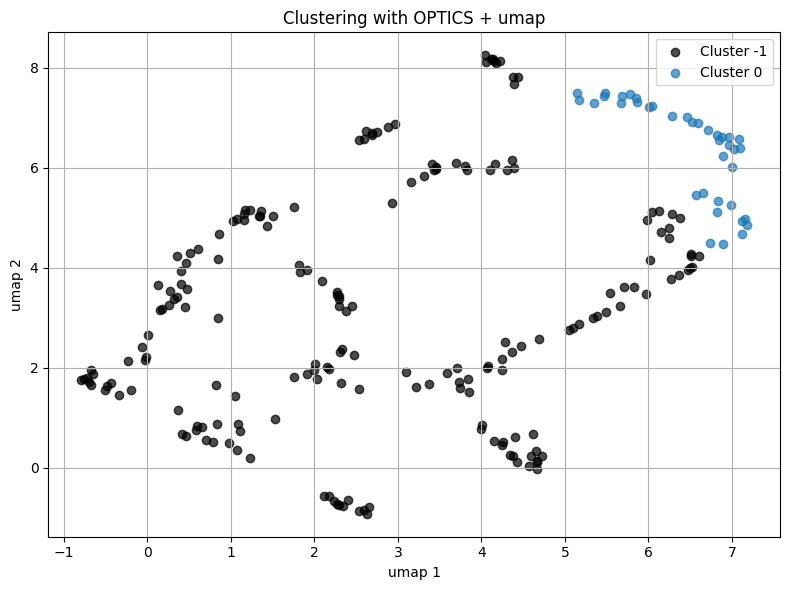

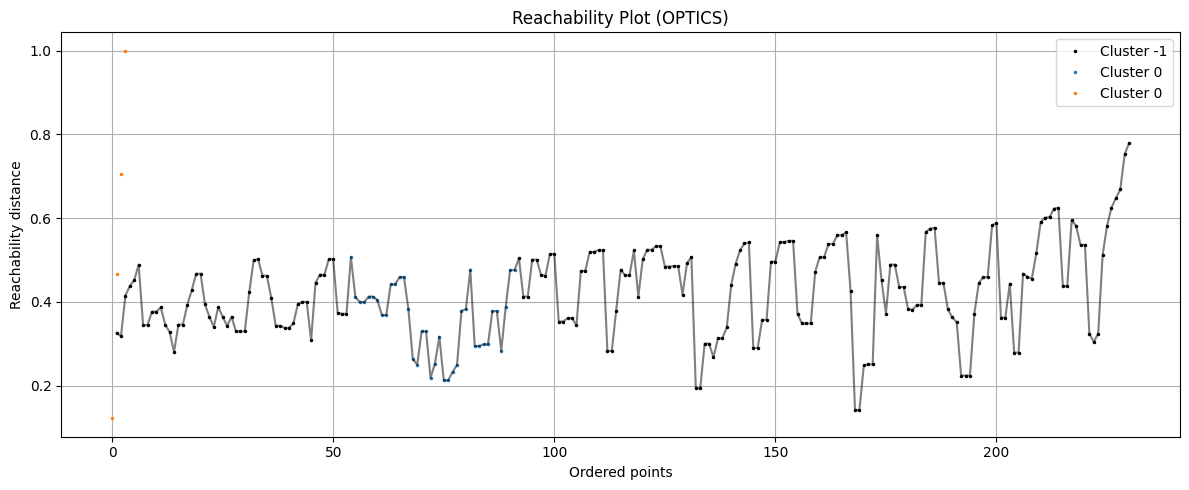

on serve_ on grass.csv
umap dimensions: 8
Number of clusters:  4
OPTICS found 4 cluster
The noise percentage exceed the user defined treshold.
Noise points: 62
Accepted max number of point classified as noise, based on noise percentage: 36.9


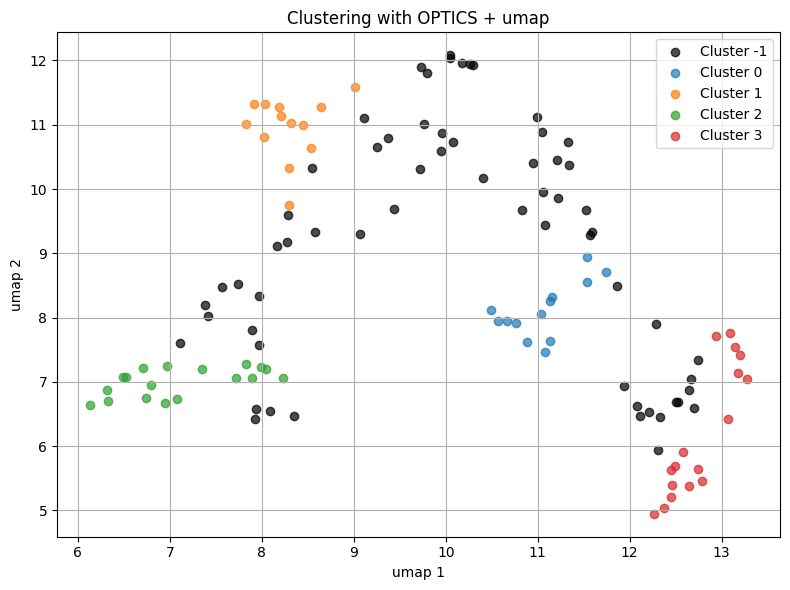

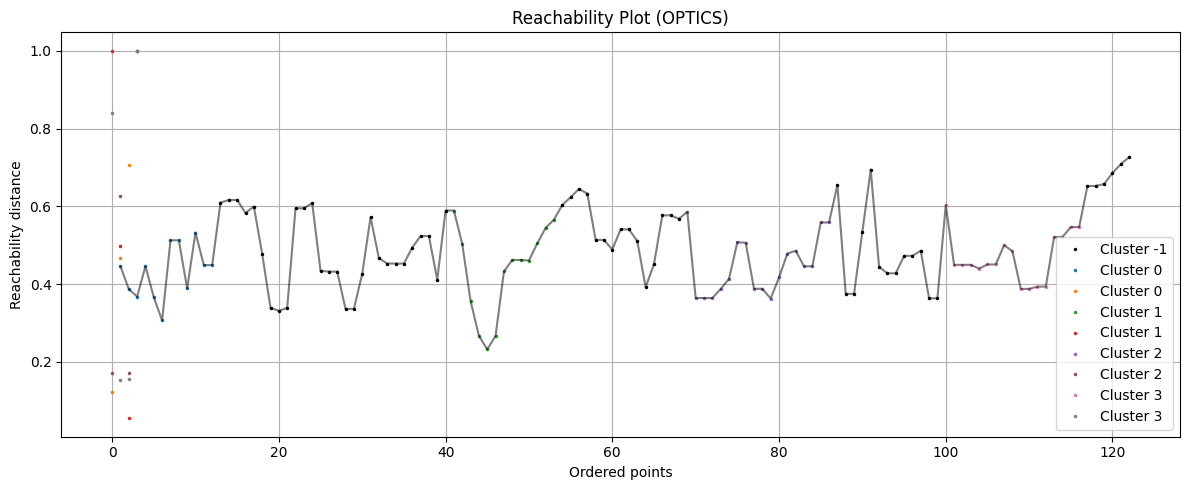

on serve_ on hard.csv
umap dimensions: 8
Number of clusters:  1


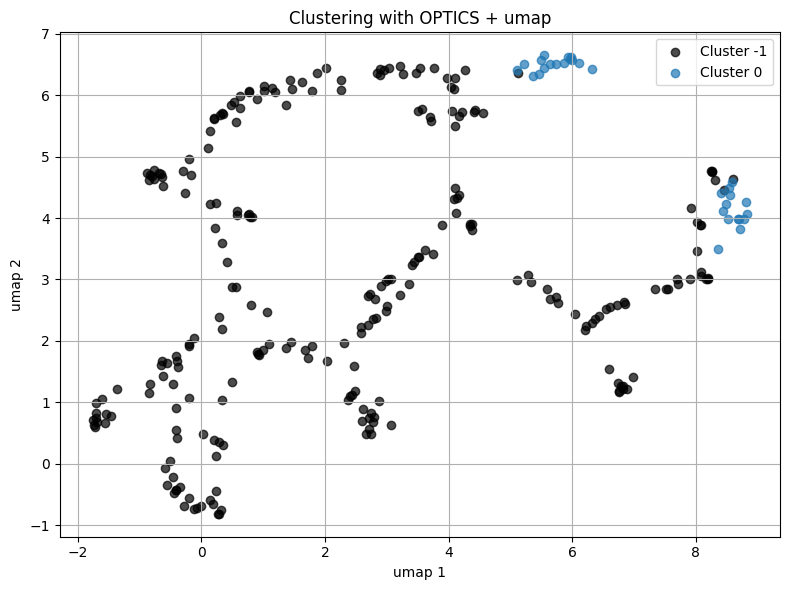

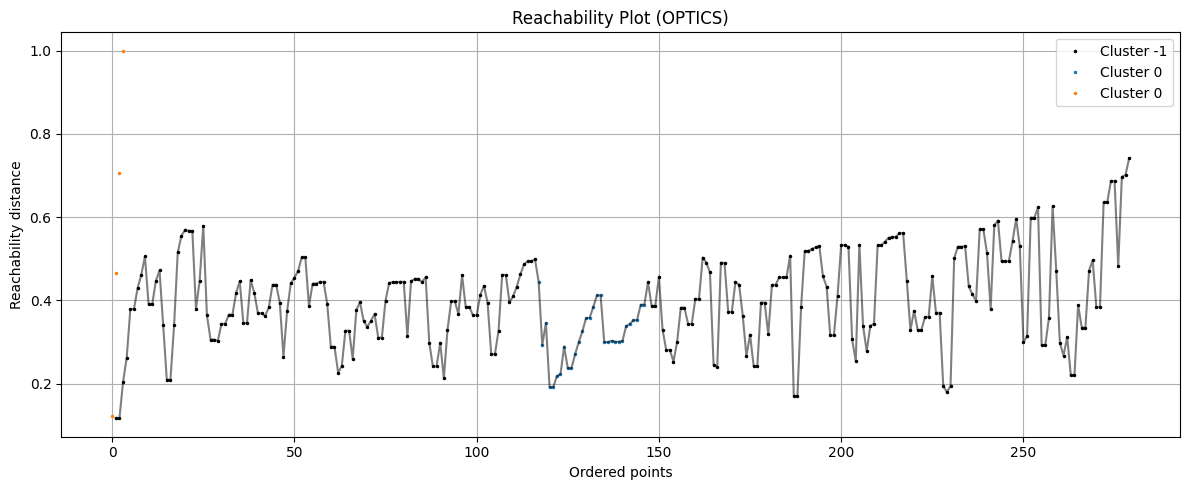

In [11]:
from run_clustering import run_umap_optics_clustering

dfs_clustered_optics = []

for dfs_umap in (dfs_umap_2d, dfs_umap_8d):
    umap_comp = 2 if dfs_umap is dfs_umap_2d else 8
    for name, dataframe in dfs_umap:
        print(name)
        print("umap dimensions: " + str(umap_comp))
        metrics = []
        df_clustered = run_umap_optics_clustering(dataframe, umap_comp=umap_comp)
        dfs_clustered_optics.append((name, df_clustered))

A GMM (Gaussian Mixture Model) is a probabilistic clustering algorithm that assumes the data is generated from a mixture of several multivariate Gaussian distributions.
GMM does not assign points rigidly, instead, it computes for each point the probability of belonging to each cluster. 
Each cluster is represented by a multivariate Gaussian distribution, defined by:
* A mean vector (cluster center),
* A covariance matrix (cluster shape and orientation),
* A prior probability (how large or likely the cluster is overall).

The model learns all these parameters from the data.

**Algorithm steps**:

1. Initialization: The model starts with initial guesses for the parameters (e.g., using KMeans or random initialization).

2. Expectation Step (E-step):
For each data point, compute the posterior probability of belonging to each Gaussian component (i.e., each cluster).

3. Maximization Step (M-step):
Update the parameters (means, covariances, and priors) to maximize the likelihood of the data given these soft assignments.

4. Repeat until convergence:
The algorithm iteratively alternates between E-step and M-step until the model stabilizes (i.e., changes in probabilities or parameters are below a threshold).

This soft clustering approach is useful for analyzing whether some players have hybrid statistics, meaning they do not clearly belong to any single cluster with high certainty.

The algorithm will find elliptical shaped clusters and takes as parameter the number of clusters deisred. The function `run_umap_gmm_clustering()` runs the algorithm and uses, by default, a probability threshold of 90%. If a point does not belong to any cluster with a probability above this threshold, it is considered ambiguous.

The algorithm version used is [GaussianMixture() provided by scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

GMM clustering:

on response_ on clay.csv
umap dimensions: 2


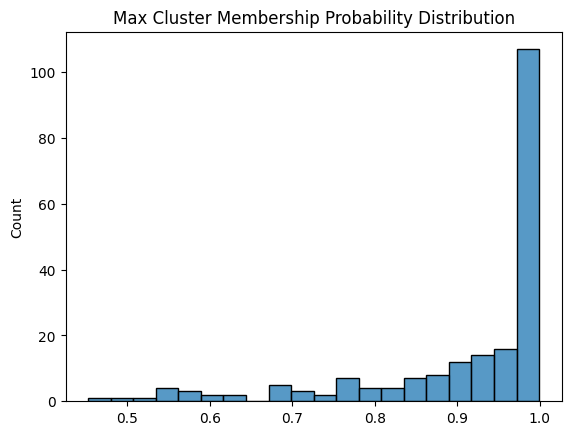

Silhouette score (UMAP + GMM): 0.516
DBI score (UMAP + GMM): 0.674


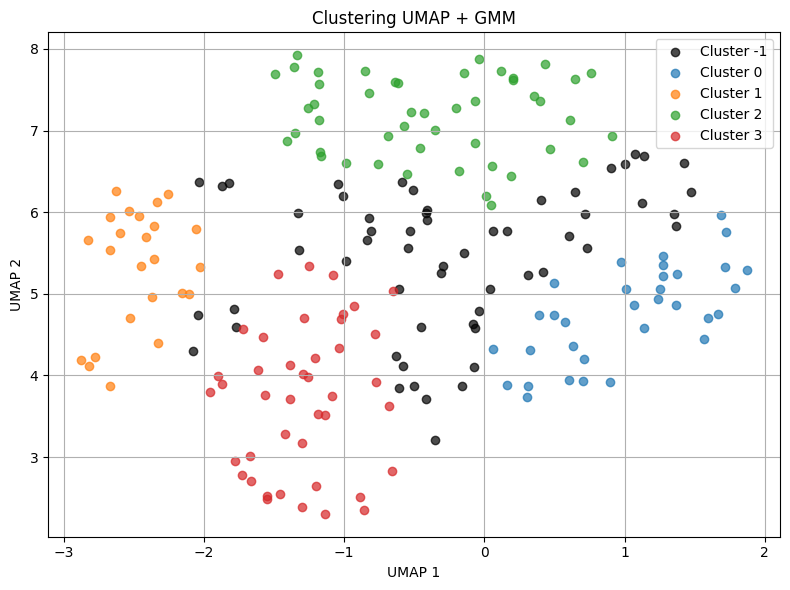

on response_ on grass.csv
umap dimensions: 2


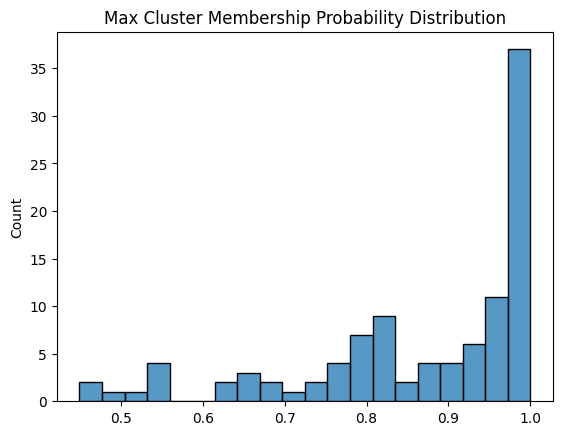

Silhouette score (UMAP + GMM): 0.571
DBI score (UMAP + GMM): 0.551


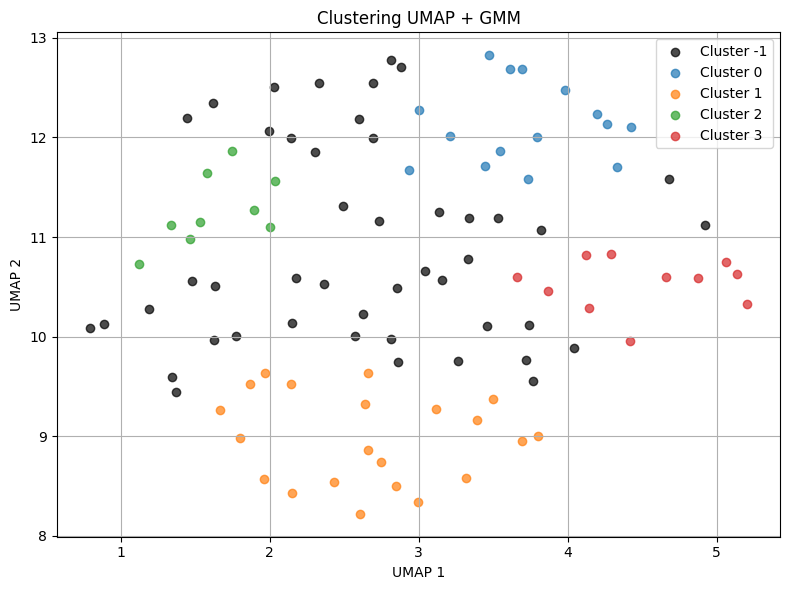

on response_ on hard.csv
umap dimensions: 2


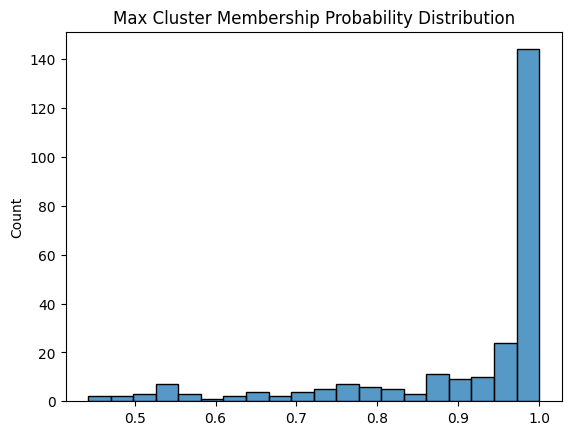

Silhouette score (UMAP + GMM): 0.566
DBI score (UMAP + GMM): 0.578


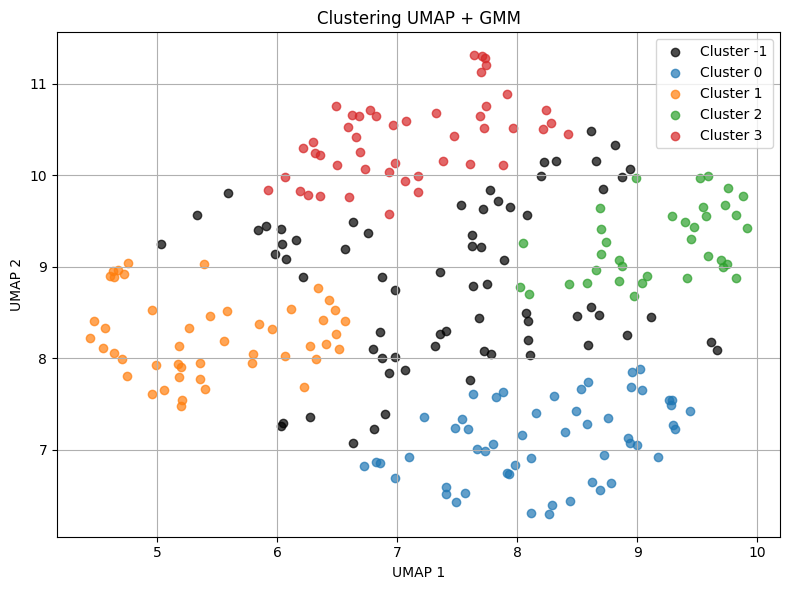

on serve_ on clay.csv
umap dimensions: 2


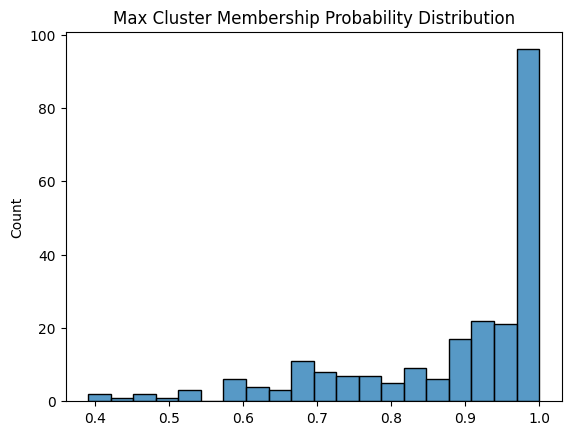

Silhouette score (UMAP + GMM): 0.600
DBI score (UMAP + GMM): 0.539


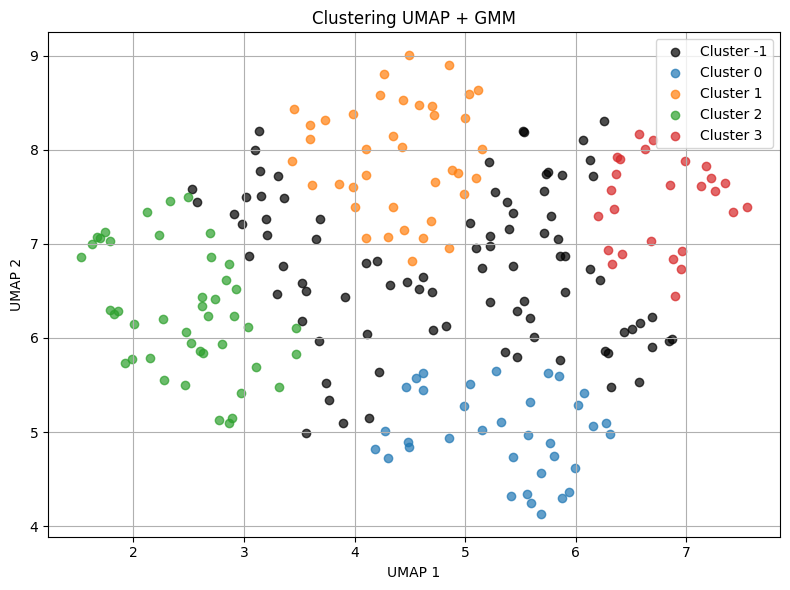

on serve_ on grass.csv
umap dimensions: 2


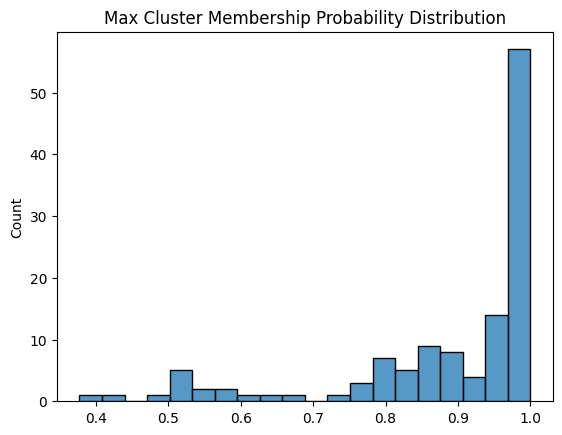

Silhouette score (UMAP + GMM): 0.577
DBI score (UMAP + GMM): 0.580


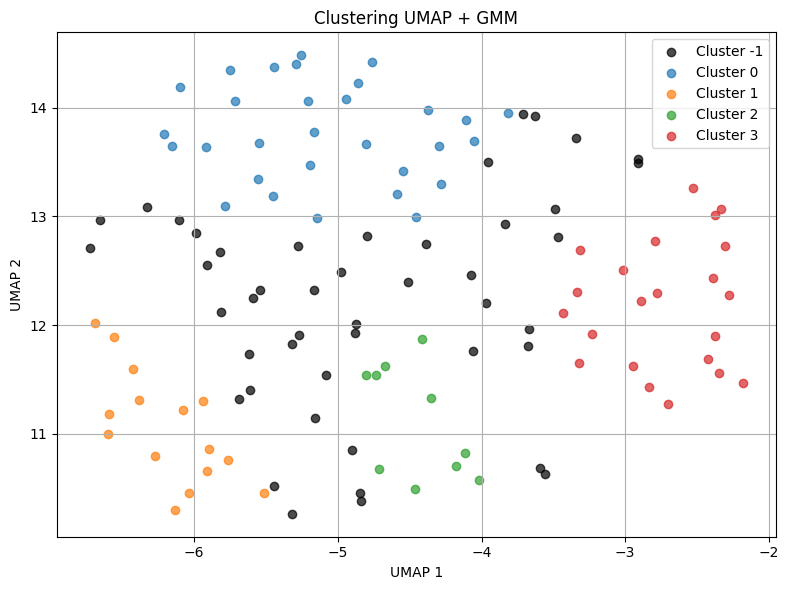

on serve_ on hard.csv
umap dimensions: 2


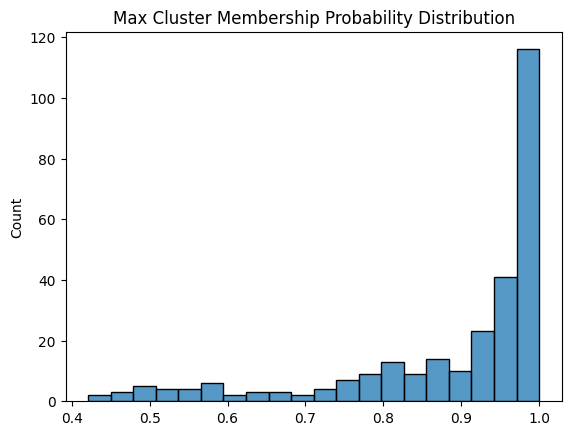

Silhouette score (UMAP + GMM): 0.557
DBI score (UMAP + GMM): 0.618


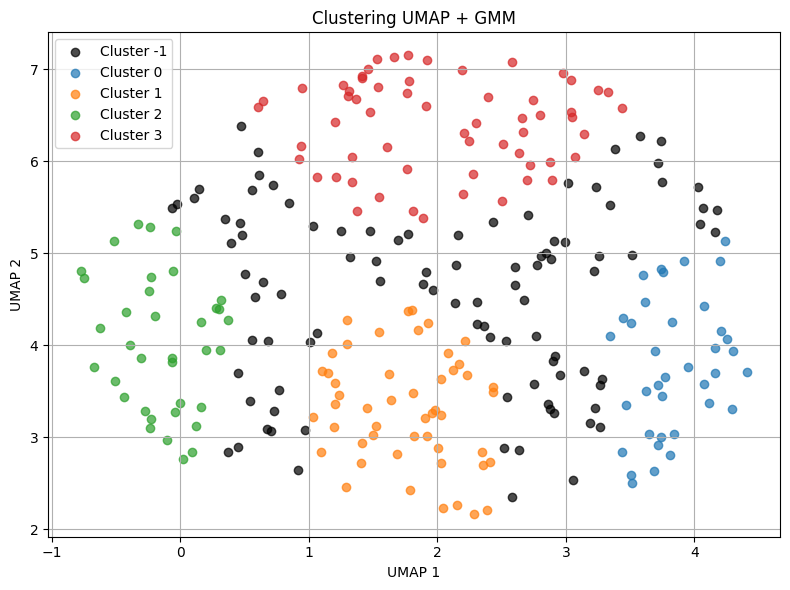

on response_ on clay.csv
umap dimensions: 8


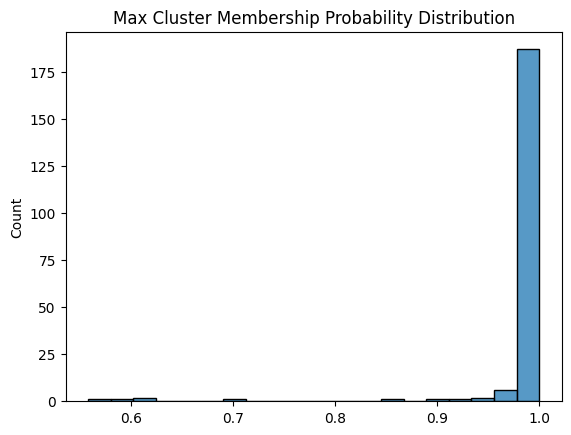

Silhouette score (UMAP + GMM): 0.225
DBI score (UMAP + GMM): 1.468


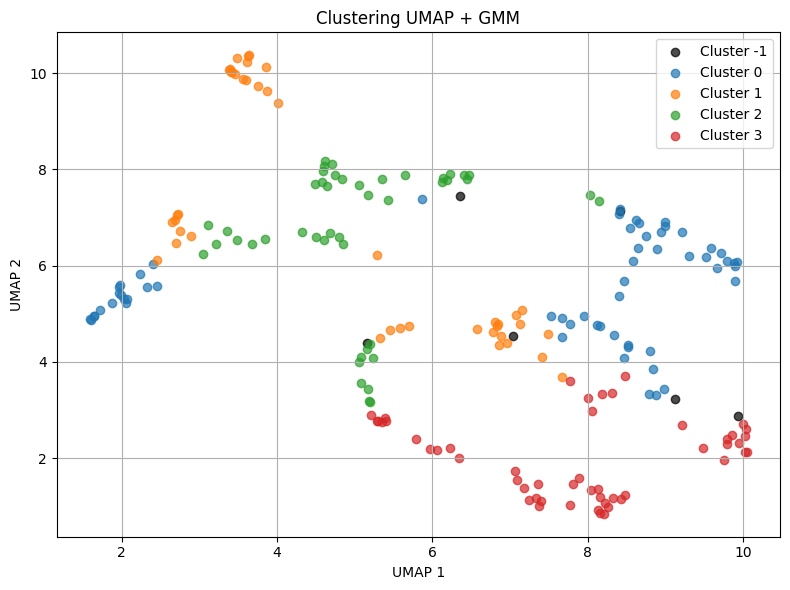

on response_ on grass.csv
umap dimensions: 8


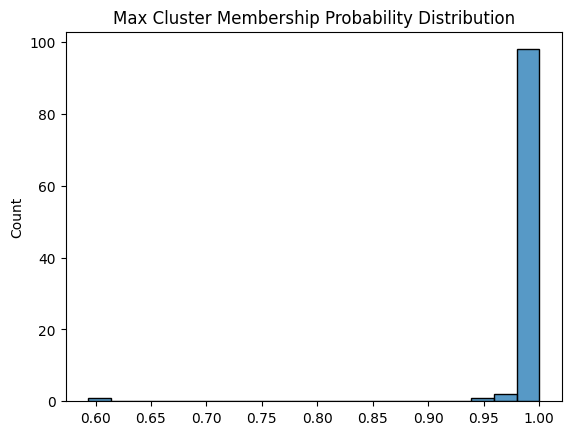

Silhouette score (UMAP + GMM): 0.214
DBI score (UMAP + GMM): 1.347


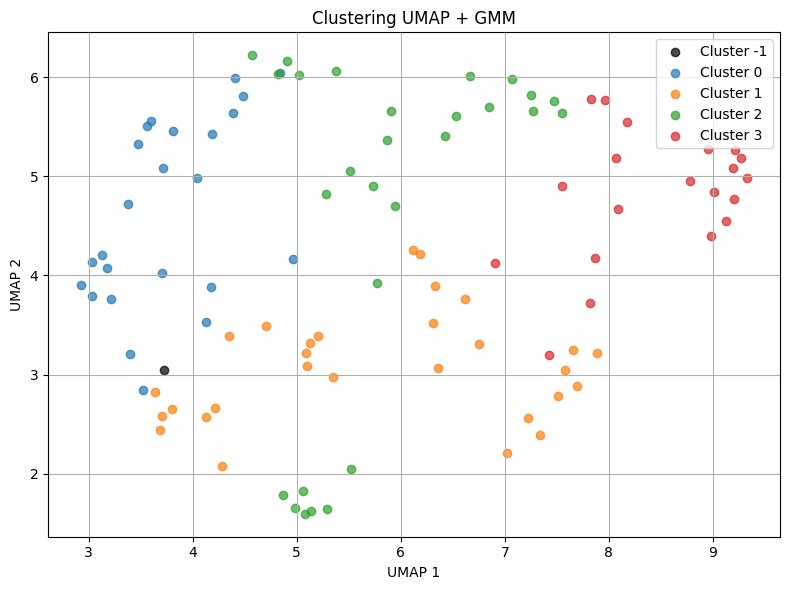

on response_ on hard.csv
umap dimensions: 8


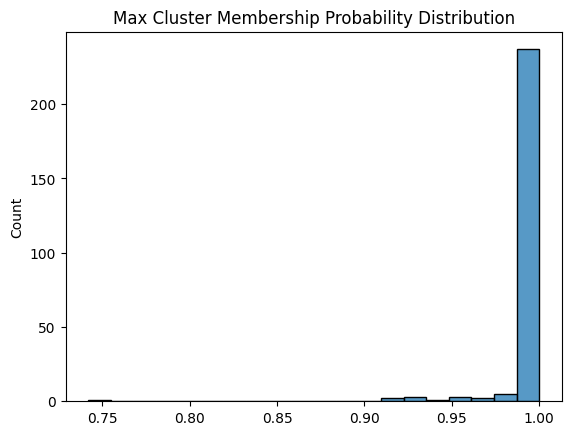

Silhouette score (UMAP + GMM): 0.298
DBI score (UMAP + GMM): 1.240


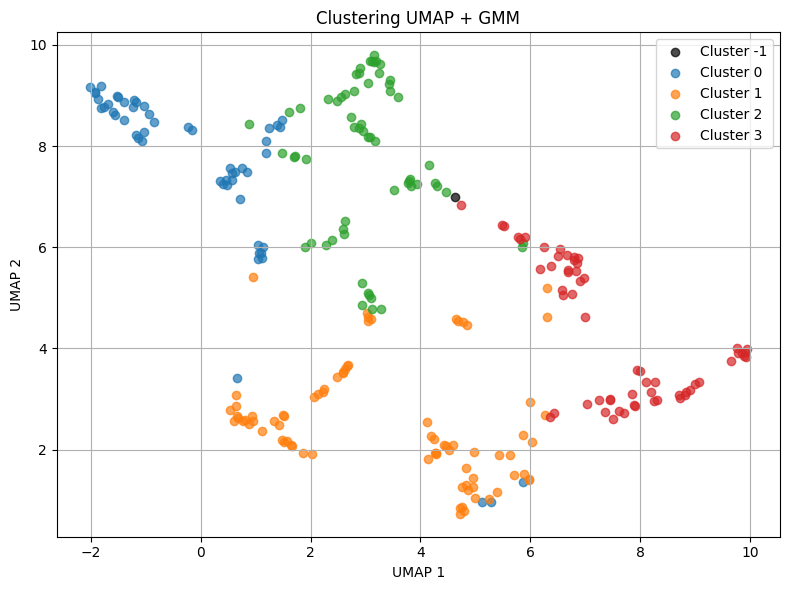

on serve_ on clay.csv
umap dimensions: 8


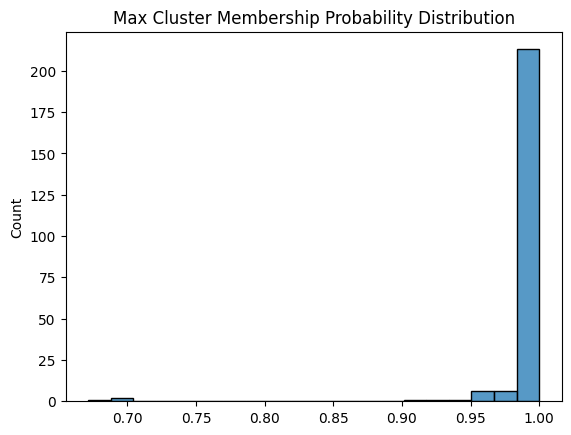

Silhouette score (UMAP + GMM): 0.302
DBI score (UMAP + GMM): 1.191


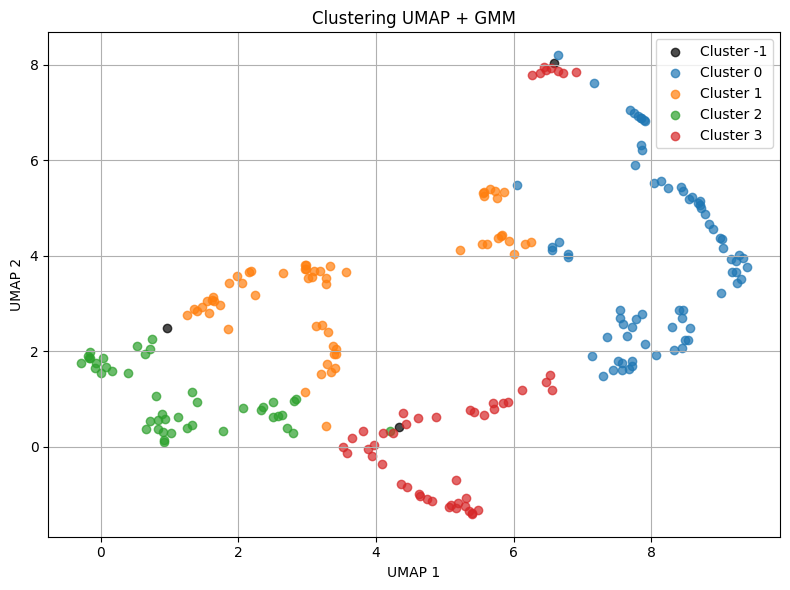

on serve_ on grass.csv
umap dimensions: 8


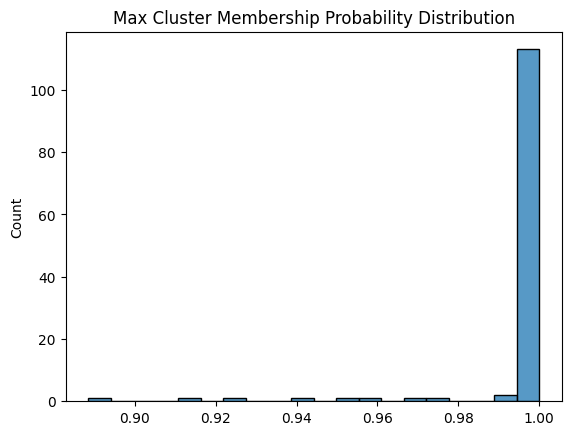

Silhouette score (UMAP + GMM): 0.293
DBI score (UMAP + GMM): 1.187


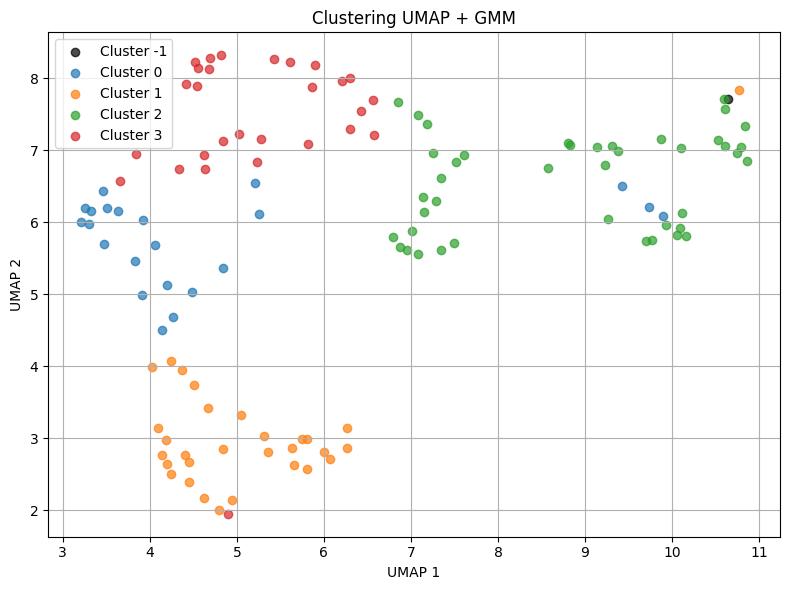

on serve_ on hard.csv
umap dimensions: 8


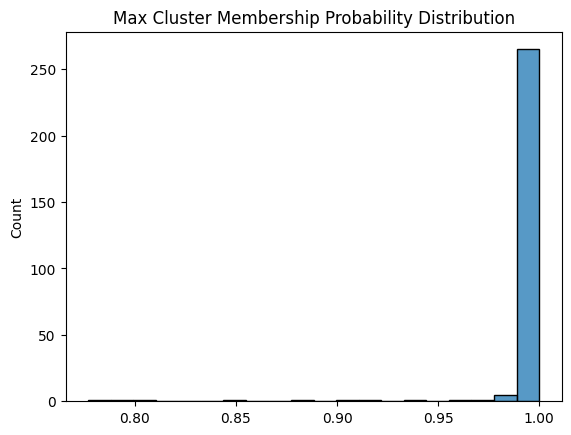

Silhouette score (UMAP + GMM): 0.247
DBI score (UMAP + GMM): 1.281


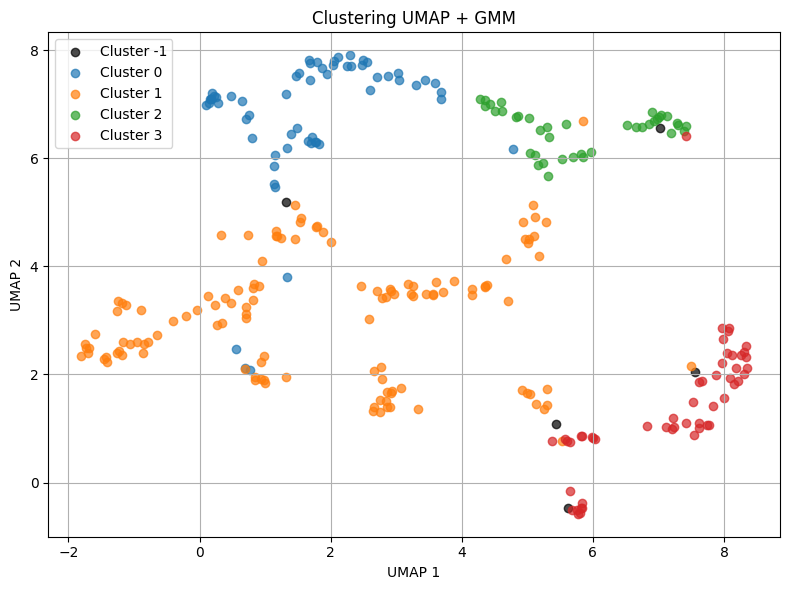

In [10]:
from run_clustering import run_umap_gmm_clustering

dfs_clustered_gmm = []

for dfs_umap in (dfs_umap_2d, dfs_umap_8d):
    umap_comp = 2 if dfs_umap is dfs_umap_2d else 8
    for name, dataframe in dfs_umap:
        print(name)
        print("umap dimensions: " + str(umap_comp))
        metrics = []
        df_clustered = run_umap_gmm_clustering(dataframe, umap_comp=umap_comp)
        dfs_clustered_gmm.append((name, df_clustered))


The results show that when using UMAP with 2 components, there are slightly more ambiguous points, whereas with 8 components the number of ambiguous points decreases. This is likely because, although UMAP in 2D preserves local structure well (high trustworthiness), the representation is too compressed for the GMM to effectively separate clusters, resulting in lower membership probabilities. On the other hand, the scores obtained in 8D — calculated excluding ambiguous points — are not very high and do not demonstrate an improvement compared to KMeans.

<span style="font-size:15px">**Results visualization**</span>

Once the clusters are formed, the playing styles can be visualized. For each cluster, the centroid is computed, and the deviation of each feature from the overall dataset mean is calculated. This provides general insight into the characteristics of each cluster, allowing for a textual description to be written. 
Since KMeans UMAP 2D appears to be the most effective algorithm, the visualization is based on its clusters, and the clustered datasets are saved into files. These datasets contain UMAP components, so in order to visualize the results, the cluster labels must be inserted into the original dataset.

In [ ]:
import os

features_dataset_clustered_dir = 'feature_datasets_csv_reduced_contexts&features_clustered_kmeans'
original_feature_dataset = 'feature_datasets_csv_reduced_contexts&features'

dfs_not_scaled=[]
for dataset_name in os.listdir(original_feature_dataset):
    if dataset_name.endswith('.csv'):
        file_path = os.path.join(original_feature_dataset, dataset_name)
        dfs_not_scaled.append((dataset_name, pd.read_csv(file_path, low_memory=False)))
        
for name_clustered, df_clustered in dfs_clustered_kmeans2d:
    for name_original, df in dfs_not_scaled:
        if name_original == name_clustered:
            # the column "cluster" is added to the original dataset
            df["cluster"] = df_clustered["cluster"]
            file_path = os.path.join(features_dataset_clustered_dir, name_original)
            df.to_csv(file_path, index=False)

Upload dfs clustered.

In [ ]:
import os
import pandas as pd

features_dataset_clustered_dir = 'feature_datasets_csv_reduced_contexts&features_clustered_kmeans'
dfs_clustered = []
for dataset_name in os.listdir(features_dataset_clustered_dir):
    if dataset_name.endswith('.csv'):
        file_path = os.path.join(features_dataset_clustered_dir, dataset_name)
        dfs_clustered.append((dataset_name, pd.read_csv(file_path)))

Now, for each dataset, a list of the 5 most representative players for each cluster is extracted, in order to provide player examples for each cluster visualization.

In [ ]:
import os
import pandas as pd

features_dataset_dir = 'feature_datasets_csv_reduced_contexts&features_clustered_kmeans'
for dataset_name in os.listdir(features_dataset_dir):
    players_per_cluster = {}
    file_path = os.path.join(features_dataset_dir, dataset_name)
    df = pd.read_csv(file_path)
    df_grouped=df.groupby('cluster')
    print(f"Dataset: {dataset_name}")
    for cluster_id, group in df_grouped:
        players = group['player']
        print(f"Cluster {cluster_id}: {list(players)}\n\n")

import os
import pandas as pd

# Dictionary that saves the lists and the context
clusters = {
    "on response_ on clay, cluster 0": ["Alexander_Zverev", "Casper_Ruud", "Jack_Draper", "Jannik_Sinner", "Taylor_Fritz"],
    "on response_ on clay, cluster 1": ["Andrey_Rublev", "Arthur_Fils", "Ben_Shelton", "Novak_Djokovic", "Grigor_Dimitrov"],
    "on response_ on clay, cluster 2": ["Carlos_Alcaraz", "Felix_Auger_Aliassime", "Karen_Khachanov", "Sebastian_Korda", "Stefanos_Tsitsipas"],
    "on response_ on clay, cluster 3": ["Alex_De_Minaur", "Daniil_Medvedev", "Holger_Rune", "Lorenzo_Musetti", "Gael_Monfils"],
    "on response_ on grass, cluster 0": ["Alexander_Bublik", "Arthur_Fils", "Daniil_Medvedev", "Stefanos_Tsitsipas", "Taylor_Fritz"],
    "on response_ on grass, cluster 1": ["Grigor_Dimitrov", "Hubert_Hurkacz", "John_Isner", "Sebastian_Korda", "Jiri_Lehecka"],
    "on response_ on grass, cluster 2": ["Andrey_Rublev", "Ben_Shelton", "Cameron_Norrie", "Jannik_Sinner", "Matteo_Berrettini"],
    "on response_ on grass, cluster 3": ["Alex_De_Minaur", "Alexander_Zverev", "Carlos_Alcaraz", "Novak_Djokovic", "Jack_Draper"],
    "on response_ on hard, cluster 0": ["Alex_De_Minaur", "Andy_Murray", "Daniil_Medvedev", "Gael_Monfils", "Botic_Van_De_Zandschulp"],
    "on response_ on hard, cluster 1": ["Arthur_Fils", "Ben_Shelton", "Casper_Ruud", "Holger_Rune", "Matteo_Berrettini"],
    "on response_ on hard, cluster 2": ["Alexander_Zverev", "Carlos_Alcaraz", "Jack_Draper", "Jannik_Sinner", "Stefanos_Tsitsipas"],
    "on response_ on hard, cluster 3": ["Grigor_Dimitrov", "Hubert_Hurkacz", "Lorenzo_Musetti", "Daniel_Evans", "Tallon_Griekspoor"],
    "on serve_ on clay, cluster 0": ["Arthur_Fils", "Cameron_Norrie", "Jiri_Lehecka", "Sebastian_Korda", "Tommy_Paul"],
    "on serve_ on clay, cluster 1": ["Alex_De_Minaur", "Jannik_Sinner", "Botic_Van_De_Zandschulp", "Jesper_De_Jong", "Thanasi_Kokkinakis"],
    "on serve_ on clay, cluster 2": ["Carlos_Alcaraz", "Daniil_Medvedev", "Grigor_Dimitrov", "Holger_Rune", "Novak_Djokovic"],
    "on serve_ on clay, cluster 3": ["Alexander_Zverev", "Ben_Shelton", "Casper_Ruud", "Matteo_Berrettini", "Taylor_Fritz"],
    "on serve_ on grass, cluster 0": ["Arthur_Fils", "Gael_Monfils", "Lorenzo_Musetti", "Tommy_Paul", "Ugo_Humbert"],
    "on serve_ on grass, cluster 1": ["Alexander_Bublik", "Casper_Ruud", "Grigor_Dimitrov", "Hubert_Hurkacz", "Matteo_Berrettini"],
    "on serve_ on grass, cluster 2": ["Alex_De_Minaur", "Carlos_Alcaraz", "Frances_Tiafoe", "Jannik_Sinner", "Marton_Fucsovics"],
    "on serve_ on grass, cluster 3": ["Alexander_Zverev", "Ben_Shelton", "Jack_Draper", "Novak_Djokovic", "Taylor_Fritz"],
    "on serve_ on hard, cluster 0": ["Alexander_Zverev", "Andrey_Rublev", "Casper_Ruud", "Holger_Rune", "Taylor_Fritz"],
    "on serve_ on hard, cluster 1": ["Arthur_Fils", "Ben_Shelton", "Hubert_Hurkacz", "Jack_Draper", "Novak_Djokovic"],
    "on serve_ on hard, cluster 2": ["Andy_Murray", "Carlos_Alcaraz", "Grigor_Dimitrov", "Lorenzo_Musetti", "Matteo_Berrettini"],
    "on serve_ on hard, cluster 3": ["Adrian_Mannarino", "Alex_De_Minaur", "Aslan_Karatsev", "Jannik_Sinner", "Juan_Manuel_Cerundolo"]
}

top_players_per_context_dir = '../top_players_per_context/'

for context, list_of_players in clusters.items():
    dest_file_path = os.path.join(top_players_per_context_dir, context)
    df = pd.DataFrame({'player': list_of_players})
    df.to_csv(dest_file_path, index=False)

Calculate for each context, for each cluster, the top n representative features with how much in percentage the centroid of the cluster differs from the overall mean, and then printed. The list of the most important player belonging to the cluster is also shown.

In [ ]:
from visualize_results import analyze_cluster_profiles

for name, df_clustered in dfs_clustered:
    print("\n"+name)
    analyze_cluster_profiles(df_clustered, context=name.replace(".csv", ""))

It's also interesting to understand how clusters across different contexts are related. For example, it is worth checking whether a player who belongs to cluster 1 on grass (on return) also falls into a cluster with similar characteristics on clay (on return).

To explore this, two similarity matrix is computed, one for serve context and the other for response, measuring the distance between each cluster in one context and all clusters in the other contexts.

In [ ]:
from visualize_results import calculate_centroid_similarity

# Computing the centroid similarity
clustered_data_on_serve = []
clustered_data_on_response = []
for context, df_clustered in dfs_clustered:
    if "on serve" in context:
        clustered_data_on_serve.append((context, df_clustered))
    else:
        clustered_data_on_response.append((context, df_clustered))
similarity_df_on_serve = calculate_centroid_similarity(clustered_data_on_serve)
similarity_df_on_response = calculate_centroid_similarity(clustered_data_on_response)

In [ ]:
from visualize_results import visualize_similarity_matrix

# Similarity matrix visualized
visualize_similarity_matrix(similarity_df_on_serve, clustered_data_on_serve)
visualize_similarity_matrix(similarity_df_on_response, clustered_data_on_response)

Finally, a player — such as Roger Federer in this example — can view his trajectory across various contexts.

In [ ]:
from visualize_results import create_player_trajectories, visualize_player_trajectory

visualize_player_trajectory(create_player_trajectories(dfs_clustered), "Roger_Federer", dfs_clustered)

<span style="font-size:20px">**Sequential pattern mining Analysis**</span>

In order to provide players with a tool to better understand their most frequently used shot sequences, an analysis of the point opening phase is performed. In particular, the function `frequent_shots_py_player()` in the file [get_freq_shots_seqs.py](get_freq_shots_seqs.py) returns the frequent sequential patterns of the first three shots in the points, based on a predefined minimum support threshold set within the function.

It is important to note that this approach considers only the **first three consecutive** shots and does not perform a full sequential pattern analysis, which would include also **non-consecutive** shots. While the original idea was to implement this broader type of analysis, it was ultimately deemed less useful: sequences of non-consecutive shots within a point lack clear structure and are harder to interpret meaningfully. On the other hand, analyzing three consecutive shots provides more interpretable and actionable insights for players.

However, future work in this direction could be valuable, aiming to better understand potential relationships among non-consecutive shots within a point.

Although full sequential pattern analysis algorithms are not necessary for this specific purpose, `seqmining()`, an FreeSpan-like algorithm, was still tested and compared with a simple frequency count of the most common opening-phase triplets. The results in terms of computational time are clear: the `seqmining()` algorithm is not suitable for this task, as its execution time is significantly higher than that of a basic counting approach.

The results below show the frequent sequences extracted for each context for the player Carlos Alcaraz, sorted in descending order of support. For each sequence, the winning percentage and the most frequent outcome are reported, along with a textual description of the sequence, provided by the function `decode_point()` in the file [decode_point.py](decode_point.py).

`Counter()` approach:

In [ ]:
from costants import PLAYER_SURFACES_DICT
from decode_point import decode_point
from get_freq_shots_seqs import frequent_shots_py_player
import pandas as pd

# calculation using Counter()

# original dataset
df_points = pd.read_csv('points_datasets/charting-m-points-2020s.csv', low_memory=False)

print("Legend: * = winner, # = forced error, @ = unforced error\n")

# iterate on all the context surface-type of point for the player Carlos Alcaraz
for surface in PLAYER_SURFACES_DICT.get("Carlos_Alcaraz", []):
    for context in ["on serve", "on response"]:
        print("\n" + context + " on " + surface + "\n")
        
        # the frequent shot sequences are returned
        for (sequence, support, win_percentage, most_frequent_outcome), time_duration in frequent_shots_py_player("Carlos_Alcaraz",df_points, surface, context):
            shots = []
            
            # the sequence is decoded in a human readable format 
            for shot in sequence:
                shots.append(decode_point(shot))
                
            # the sequences are returned sorted by support, from the higher to the lowest
            print(
                f"Sequence: {shots} | Support: {support} | Win percentage: {win_percentage} | Most frequent outcome: {most_frequent_outcome}\n")
        print("Time duration:", time_duration)



`Seqmining()` approach:

In [ ]:
from costants import PLAYER_SURFACES_DICT
from decode_point import decode_point
from get_freq_shots_seqs import frequent_shots_py_player
import pandas as pd

# calculation using seqmining()

# original dataset
df_points = pd.read_csv('points_datasets/charting-m-points-2020s.csv', low_memory=False)

print("Legend: * = winner, # = forced error, @ = unforced error\n")

# iterate on all the context surface-type of point for the player Carlos Alcaraz
for surface in PLAYER_SURFACES_DICT.get("Carlos_Alcaraz", []):
    for context in ["on serve", "on response"]:
        print("\n" + context + " on " + surface + "\n")
        
        # the frequent shot sequences are returned
        for (sequence, support, win_percentage, most_frequent_outcome), time_duration in frequent_shots_py_player("Carlos_Alcaraz",df_points, surface, context, seqmining=True):
            shots = []
            
            # the sequence is decoded in a human readable format 
            for shot in sequence:
                shots.append(decode_point(shot))
                
            # the sequences are returned sorted by support, from the higher to the lowest
            print(
                f"Sequence: {shots} | Support: {support} | Win percentage: {win_percentage} | Most frequent outcome: {most_frequent_outcome}\n")
        print("Time duration:", time_duration)
